In [ ]:
print('Recreating hello_world.c...')

Recreating hello_world.c...


In [ ]:
%%writefile hello_world.c
#include <stdio.h>

int main() {
    printf("Hello, World!\n");
    return 0;
}

Overwriting hello_world.c


In [ ]:
%%writefile my_library.h
#ifndef MY_LIBRARY_H
#define MY_LIBRARY_H

void print_message(const char* message);

#endif // MY_LIBRARY_H

Overwriting my_library.h


In [ ]:
%%writefile my_library.c
#include <stdio.h>
#include "my_library.h"

void print_message(const char* message) {
    printf("Library message: %s\n", message);
}

Overwriting my_library.c


In [ ]:
%%writefile main.c
#include <stdio.h>
#include "my_library.h"

int main() {
    printf("Hello from main!\n");
    print_message("This is a message from the external library.");
    return 0;
}

Overwriting main.c


In [ ]:
%%writefile rasterize_aus.cpp
#include "ogrsf_frmts.h"
#include "gdal_alg.h"
#include "gdal_priv.h"
#include "cpl_error.h" // For CPLSetErrorHandler
#include "cpl_conv.h" // For CPLSetConfigOption
#include "gdal_utils.h" // For GDALTranslate and options

#include <iostream>
#include <string>

int main() {
    // Set GDAL error handler to default and enable debug output
    CPLSetErrorHandler(CPLDefaultErrorHandler);
    CPLSetConfigOption("CPL_DEBUG", "ON"); // Re-enable verbose debug output

    // Register GDAL drivers
    GDALAllRegister();

    // Define constants
    const std::string input_debug_tif_path = "gdal_rasterize_output.tif"; // Using previously generated TIFF
    const std::string output_png_name = "aus_adm1_raster.png";

    std::cout << "Attempting to open source TIFF for conversion: " << input_debug_tif_path << std::endl;
    GDALDataset *poSrcDebugDS = (GDALDataset*) GDALOpen(input_debug_tif_path.c_str(), GA_ReadOnly);
    if (poSrcDebugDS == NULL) {
        std::cerr << "Could not open source TIFF: " << input_debug_tif_path << std::endl;
        const char* err_msg = CPLGetLastErrorMsg();
        if (err_msg && *err_msg) {
            std::cerr << "GDAL Error: " << err_msg << std::endl;
        }
        return 1;
    }

    std::cout << "Opened source TIFF. Translating to PNG..." << std::endl;

    // Set translation options
    char **papszTranslateOptions = NULL;
    papszTranslateOptions = CSLSetNameValue(papszTranslateOptions, "OF", "PNG"); // Output format

    // Create a GDALTranslateOptions structure
    GDALTranslateOptions *psOptions = GDALTranslateOptionsNew(papszTranslateOptions, NULL);
    CSLDestroy(papszTranslateOptions); // CSLDestroy options array

    // Call GDALTranslate C function
    GDALDataset *poPngDS = (GDALDataset *) GDALTranslate(
        output_png_name.c_str(), // Output file name
        poSrcDebugDS,            // Source dataset
        psOptions,               // Options
        NULL                     // pbUsageError (int*)
    );
    GDALTranslateOptionsFree(psOptions); // Free options

    const char* translate_error = CPLGetLastErrorMsg();
    if (poPngDS == NULL) {
        std::cerr << "Failed to translate TIFF to PNG: " << output_png_name << std::endl;
        if (translate_error && *translate_error) {
            std::cerr << "GDAL Translate Error: " << translate_error << std::endl;
        }
        GDALClose(poSrcDebugDS);
        return 1;
    }

    std::cout << "Output saved to " << output_png_name << std::endl;

    GDALClose(poPngDS); // Close the PNG dataset
    const char* close_png_error = CPLGetLastErrorMsg();
    if (close_png_error && *close_png_error) {
        std::cerr << "GDAL Close PNG Error: " << close_png_error << std::endl;
    }

    GDALClose(poSrcDebugDS); // Close the source TIFF dataset

    GDALDestroyDriverManager();

    return 0;
}

Overwriting rasterize_aus.cpp


In [ ]:
%%writefile write_test.cpp
#include "gdal_priv.h"
#include "cpl_error.h" // For CPLSetErrorHandler
#include "cpl_conv.h" // For CPLSetConfigOption

#include <iostream>
#include <string>

int main() {
    CPLSetErrorHandler(CPLDefaultErrorHandler);
    CPLSetConfigOption("CPL_DEBUG", "ON"); // Re-enable debug for this test

    GDALAllRegister();

    const std::string output_tif_name = "test_output.tif";
    const int raster_width = 10;
    const int raster_height = 10;

    GDALDriver *poDriver = GetGDALDriverManager()->GetDriverByName("GTiff");
    if (poDriver == NULL) {
        std::cerr << "Failed to get GTiff driver." << std::endl;
        return 1;
    }

    char **papszCreateOptions = NULL;
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "COMPRESS", "DEFLATE");
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "TILED", "YES"); // Add tiling option
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "BLOCKXSIZE", "256"); // Ensure block sizes are set
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "BLOCKYSIZE", "256"); // if TILED=YES

    GDALDataset *poDstDS = poDriver->Create(output_tif_name.c_str(), raster_width, raster_height, 1, GDT_Byte, papszCreateOptions);
    CSLDestroy(papszCreateOptions);

    if (poDstDS == NULL) {
        std::cerr << "Failed to create output raster dataset: " << output_tif_name << std::endl;
        return 1;
    }

    double adfGeoTransform[6] = {0.0, 1.0, 0.0, 0.0, 0.0, -1.0};
    poDstDS->SetGeoTransform(adfGeoTransform);
    poDstDS->SetProjection("GEOGCS[\"WGS 84\",DATUM[\"WGS_1984\",SPHEROID[\"WGS 84\",6378137,298.257223563,AUTHORITY[\"EPSG\",\"7030\"]],AUTHORITY[\"EPSG\",\"6326\"]],PRIMEM[\"Greenwich\",0,AUTHORITY[\"EPSG\",\"8901\"]],UNIT[\"Degree\",0.0174532925199433,AUTHORITY[\"EPSG\",\"9122\"]],AUTHORITY[\"EPSG\",\"4326\"]]");

    GDALRasterBand *poBand = poDstDS->GetRasterBand(1);
    poBand->Fill(127.0); // Fill with a non-zero value

    poDstDS->FlushCache(); // Explicitly flush

    GDALClose(poDstDS);

    std::cout << "Test GeoTIFF writing complete. Output saved to " << output_tif_name << std::endl;

    return 0;
}

Overwriting write_test.cpp


In [ ]:
print('Creating directory for C code in Google Drive...')
!mkdir -p /content/drive/MyDrive/colab_c_code
print('Copying C code files to Google Drive...')
!cp hello_world.c /content/drive/MyDrive/colab_c_code/
!cp my_library.h /content/drive/MyDrive/colab_c_code/
!cp my_library.c /content/drive/MyDrive/colab_c_code/
!cp main.c /content/drive/MyDrive/colab_c_code/
!cp rasterize_aus.cpp /content/drive/MyDrive/colab_c_code/
!cp write_test.cpp /content/drive/MyDrive/colab_c_code/
print('All C code files copied to /content/drive/MyDrive/colab_c_code/.')

Creating directory for C code in Google Drive...
Copying C code files to Google Drive...
All C code files copied to /content/drive/MyDrive/colab_c_code/.


**Reasoning**:
The previous code block failed because the `print` statement was on the same line as `%%writefile`. I will move the `print` statement into its own cell and then recreate `hello_world.c` in a separate cell.

In [ ]:
print('Recreating hello_world.c...')

Recreating hello_world.c...


In [ ]:
%%writefile hello_world.c
#include <stdio.h>

int main() {
    printf("Hello, World!\n");
    return 0;
}

Overwriting hello_world.c


**Reasoning**:
Next, I will recreate `my_library.h`.

In [ ]:
print('Recreating my_library.h...')

Recreating my_library.h...


In [ ]:
%%writefile my_library.h
#ifndef MY_LIBRARY_H
#define MY_LIBRARY_H

void print_message(const char* message);

#endif // MY_LIBRARY_H

Overwriting my_library.h


**Reasoning**:
Next, I will recreate `my_library.c`.

In [ ]:
print('Recreating my_library.c...')

Recreating my_library.c...


In [ ]:
%%writefile my_library.c
#include <stdio.h>
#include "my_library.h"

void print_message(const char* message) {
    printf("Library message: %s\n", message);
}

Overwriting my_library.c


**Reasoning**:
Next, I will recreate `main.c`.

In [ ]:
print('Recreating main.c...')

Recreating main.c...


In [ ]:
%%writefile main.c
#include <stdio.h>
#include "my_library.h"

int main() {
    printf("Hello from main!\n");
    print_message("This is a message from the external library.");
    return 0;
}

Overwriting main.c


**Reasoning**:
Next, I will recreate `rasterize_aus.cpp`.

In [ ]:
print('Recreating rasterize_aus.cpp...')

Recreating rasterize_aus.cpp...


In [ ]:
%%writefile rasterize_aus.cpp
#include "ogrsf_frmts.h"
#include "gdal_alg.h"
#include "gdal_priv.h"
#include "cpl_error.h" // For CPLSetErrorHandler
#include "cpl_conv.h" // For CPLSetConfigOption
#include "gdal_utils.h" // For GDALTranslate and options

#include <iostream>
#include <string>

int main() {
    // Set GDAL error handler to default and enable debug output
    CPLSetErrorHandler(CPLDefaultErrorHandler);
    CPLSetConfigOption("CPL_DEBUG", "ON"); // Re-enable verbose debug output

    // Register GDAL drivers
    GDALAllRegister();

    // Define constants
    const std::string input_debug_tif_path = "gdal_rasterize_output.tif"; // Using previously generated TIFF
    const std::string output_png_name = "aus_adm1_raster.png";

    std::cout << "Attempting to open source TIFF for conversion: " << input_debug_tif_path << std::endl;
    GDALDataset *poSrcDebugDS = (GDALDataset*) GDALOpen(input_debug_tif_path.c_str(), GA_ReadOnly);
    if (poSrcDebugDS == NULL) {
        std::cerr << "Could not open source TIFF: " << input_debug_tif_path << std::endl;
        const char* err_msg = CPLGetLastErrorMsg();
        if (err_msg && *err_msg) {
            std::cerr << "GDAL Error: " << err_msg << std::endl;
        }
        return 1;
    }

    std::cout << "Opened source TIFF. Translating to PNG..." << std::endl;

    // Set translation options
    char **papszTranslateOptions = NULL;
    papszTranslateOptions = CSLSetNameValue(papszTranslateOptions, "OF", "PNG"); // Output format

    // Create a GDALTranslateOptions structure
    GDALTranslateOptions *psOptions = GDALTranslateOptionsNew(papszTranslateOptions, NULL);
    CSLDestroy(papszTranslateOptions); // CSLDestroy options array

    // Call GDALTranslate C function
    GDALDataset *poPngDS = (GDALDataset *) GDALTranslate(
        output_png_name.c_str(), // Output file name
        poSrcDebugDS,            // Source dataset
        psOptions,               // Options
        NULL                     // pbUsageError (int*)
    );
    GDALTranslateOptionsFree(psOptions); // Free options

    const char* translate_error = CPLGetLastErrorMsg();
    if (poPngDS == NULL) {
        std::cerr << "Failed to translate TIFF to PNG: " << output_png_name << std::endl;
        if (translate_error && *translate_error) {
            std::cerr << "GDAL Translate Error: " << translate_error << std::endl;
        }
        GDALClose(poSrcDebugDS);
        return 1;
    }

    std::cout << "Output saved to " << output_png_name << std::endl;

    GDALClose(poPngDS); // Close the PNG dataset
    const char* close_png_error = CPLGetLastErrorMsg();
    if (close_png_error && *close_png_error) {
        std::cerr << "GDAL Close PNG Error: " << close_png_error << std::endl;
    }

    GDALClose(poSrcDebugDS); // Close the source TIFF dataset

    GDALDestroyDriverManager();

    return 0;
}

Overwriting rasterize_aus.cpp


**Reasoning**:
Next, I will recreate `write_test.cpp`.

In [ ]:
print('Recreating write_test.cpp...')

Recreating write_test.cpp...


In [ ]:
%%writefile write_test.cpp
#include "gdal_priv.h"
#include "cpl_error.h" // For CPLSetErrorHandler
#include "cpl_conv.h" // For CPLSetConfigOption

#include <iostream>
#include <string>

int main() {
    CPLSetErrorHandler(CPLDefaultErrorHandler);
    CPLSetConfigOption("CPL_DEBUG", "ON"); // Re-enable debug for this test

    GDALAllRegister();

    const std::string output_tif_name = "test_output.tif";
    const int raster_width = 10;
    const int raster_height = 10;

    GDALDriver *poDriver = GetGDALDriverManager()->GetDriverByName("GTiff");
    if (poDriver == NULL) {
        std::cerr << "Failed to get GTiff driver." << std::endl;
        return 1;
    }

    char **papszCreateOptions = NULL;
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "COMPRESS", "DEFLATE");
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "TILED", "YES"); // Add tiling option
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "BLOCKXSIZE", "256"); // Ensure block sizes are set
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "BLOCKYSIZE", "256"); // if TILED=YES

    GDALDataset *poDstDS = poDriver->Create(output_tif_name.c_str(), raster_width, raster_height, 1, GDT_Byte, papszCreateOptions);
    CSLDestroy(papszCreateOptions);

    if (poDstDS == NULL) {
        std::cerr << "Failed to create output raster dataset: " << output_tif_name << std::endl;
        return 1;
    }

    double adfGeoTransform[6] = {0.0, 1.0, 0.0, 0.0, 0.0, -1.0};
    poDstDS->SetGeoTransform(adfGeoTransform);
    poDstDS->SetProjection("GEOGCS[\"WGS 84\",DATUM[\"WGS_1984\",SPHEROID[\"WGS 84\",6378137,298.257223563,AUTHORITY[\"EPSG\",\"7030\"]],AUTHORITY[\"EPSG\",\"6326\"]],PRIMEM[\"Greenwich\",0,AUTHORITY[\"EPSG\",\"8901\"]],UNIT[\"Degree\",0.0174532925199433,AUTHORITY[\"EPSG\",\"9122\"]],AUTHORITY[\"EPSG\",\"4326\"]]");

    GDALRasterBand *poBand = poDstDS->GetRasterBand(1);
    poBand->Fill(127.0); // Fill with a non-zero value

    poDstDS->FlushCache(); // Explicitly flush

    GDALClose(poDstDS);

    std::cout << "Test GeoTIFF writing complete. Output saved to " << output_tif_name << std::endl;

    return 0;
}

Overwriting write_test.cpp


**Reasoning**:
All necessary files have been recreated. Now I will proceed to copy these files to Google Drive.

In [ ]:
print('Creating directory for C code in Google Drive...')
!mkdir -p /content/drive/MyDrive/colab_c_code
print('Copying C code files to Google Drive...')
!cp hello_world.c /content/drive/MyDrive/colab_c_code/
!cp my_library.h /content/drive/MyDrive/colab_c_code/
!cp my_library.c /content/drive/MyDrive/colab_c_code/
!cp main.c /content/drive/MyDrive/colab_c_code/
!cp rasterize_aus.cpp /content/drive/MyDrive/colab_c_code/
!cp write_test.cpp /content/drive/MyDrive/colab_c_code/
print('All C code files copied to /content/drive/MyDrive/colab_c_code/.')

Creating directory for C code in Google Drive...
Copying C code files to Google Drive...
All C code files copied to /content/drive/MyDrive/colab_c_code/.


In [ ]:
print('Recreating hello_world.c...')

Recreating hello_world.c...


In [ ]:
%%writefile hello_world.c
#include <stdio.h>

int main() {
    printf("Hello, World!\n");
    return 0;
}

Overwriting hello_world.c


In [ ]:
print('Recreating my_library.h...')

Recreating my_library.h...


In [ ]:
%%writefile my_library.h
#ifndef MY_LIBRARY_H
#define MY_LIBRARY_H

void print_message(const char* message);

#endif // MY_LIBRARY_H

Overwriting my_library.h


In [ ]:
print('Recreating my_library.c...')

Recreating my_library.c...


In [ ]:
%%writefile my_library.c
#include <stdio.h>
#include "my_library.h"

void print_message(const char* message) {
    printf("Library message: %s\n", message);
}

Overwriting my_library.c


In [ ]:
print('Recreating main.c...')

Recreating main.c...


In [ ]:
%%writefile main.c
#include <stdio.h>
#include "my_library.h"

int main() {
    printf("Hello from main!\n");
    print_message("This is a message from the external library.");
    return 0;
}

Overwriting main.c


In [ ]:
print('Recreating rasterize_aus.cpp...')

Recreating rasterize_aus.cpp...


In [ ]:
%%writefile rasterize_aus.cpp
#include "ogrsf_frmts.h"
#include "gdal_alg.h"
#include "gdal_priv.h"
#include "cpl_error.h" // For CPLSetErrorHandler
#include "cpl_conv.h" // For CPLSetConfigOption
#include "gdal_utils.h" // For GDALTranslate and options

#include <iostream>
#include <string>

int main() {
    // Set GDAL error handler to default and enable debug output
    CPLSetErrorHandler(CPLDefaultErrorHandler);
    CPLSetConfigOption("CPL_DEBUG", "ON"); // Re-enable verbose debug output

    // Register GDAL drivers
    GDALAllRegister();

    // Define constants
    const std::string input_debug_tif_path = "gdal_rasterize_output.tif"; // Using previously generated TIFF
    const std::string output_png_name = "aus_adm1_raster.png";

    std::cout << "Attempting to open source TIFF for conversion: " << input_debug_tif_path << std::endl;
    GDALDataset *poSrcDebugDS = (GDALDataset*) GDALOpen(input_debug_tif_path.c_str(), GA_ReadOnly);
    if (poSrcDebugDS == NULL) {
        std::cerr << "Could not open source TIFF: " << input_debug_tif_path << std::endl;
        const char* err_msg = CPLGetLastErrorMsg();
        if (err_msg && *err_msg) {
            std::cerr << "GDAL Error: " << err_msg << std::endl;
        }
        return 1;
    }

    std::cout << "Opened source TIFF. Translating to PNG..." << std::endl;

    // Set translation options
    char **papszTranslateOptions = NULL;
    papszTranslateOptions = CSLSetNameValue(papszTranslateOptions, "OF", "PNG"); // Output format

    // Create a GDALTranslateOptions structure
    GDALTranslateOptions *psOptions = GDALTranslateOptionsNew(papszTranslateOptions, NULL);
    CSLDestroy(papszTranslateOptions); // CSLDestroy options array

    // Call GDALTranslate C function
    GDALDataset *poPngDS = (GDALDataset *) GDALTranslate(
        output_png_name.c_str(), // Output file name
        poSrcDebugDS,            // Source dataset
        psOptions,               // Options
        NULL                     // pbUsageError (int*)
    );
    GDALTranslateOptionsFree(psOptions); // Free options

    const char* translate_error = CPLGetLastErrorMsg();
    if (poPngDS == NULL) {
        std::cerr << "Failed to translate TIFF to PNG: " << output_png_name << std::endl;
        if (translate_error && *translate_error) {
            std::cerr << "GDAL Translate Error: " << translate_error << std::endl;
        }
        GDALClose(poSrcDebugDS);
        return 1;
    }

    std::cout << "Output saved to " << output_png_name << std::endl;

    GDALClose(poPngDS); // Close the PNG dataset
    const char* close_png_error = CPLGetLastErrorMsg();
    if (close_png_error && *close_png_error) {
        std::cerr << "GDAL Close PNG Error: " << close_png_error << std::endl;
    }

    GDALClose(poSrcDebugDS); // Close the source TIFF dataset

    GDALDestroyDriverManager();

    return 0;
}

Overwriting rasterize_aus.cpp


In [ ]:
print('Recreating write_test.cpp...')

Recreating write_test.cpp...


In [ ]:
%%writefile write_test.cpp
#include "gdal_priv.h"
#include "cpl_error.h" // For CPLSetErrorHandler
#include "cpl_conv.h" // For CPLSetConfigOption

#include <iostream>
#include <string>

int main() {
    CPLSetErrorHandler(CPLDefaultErrorHandler);
    CPLSetConfigOption("CPL_DEBUG", "ON"); // Re-enable debug for this test

    GDALAllRegister();

    const std::string output_tif_name = "test_output.tif";
    const int raster_width = 10;
    const int raster_height = 10;

    GDALDriver *poDriver = GetGDALDriverManager()->GetDriverByName("GTiff");
    if (poDriver == NULL) {
        std::cerr << "Failed to get GTiff driver." << std::endl;
        return 1;
    }

    char **papszCreateOptions = NULL;
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "COMPRESS", "DEFLATE");
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "TILED", "YES"); // Add tiling option
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "BLOCKXSIZE", "256"); // Ensure block sizes are set
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "BLOCKYSIZE", "256"); // if TILED=YES

    GDALDataset *poDstDS = poDriver->Create(output_tif_name.c_str(), raster_width, raster_height, 1, GDT_Byte, papszCreateOptions);
    CSLDestroy(papszCreateOptions);

    if (poDstDS == NULL) {
        std::cerr << "Failed to create output raster dataset: " << output_tif_name << std::endl;
        return 1;
    }

    double adfGeoTransform[6] = {0.0, 1.0, 0.0, 0.0, 0.0, -1.0};
    poDstDS->SetGeoTransform(adfGeoTransform);
    poDstDS->SetProjection("GEOGCS[\"WGS 84\",DATUM[\"WGS_1984\",SPHEROID[\"WGS 84\",6378137,298.257223563,AUTHORITY[\"EPSG\",\"7030\"]],AUTHORITY[\"EPSG\",\"6326\"]],PRIMEM[\"Greenwich\",0,AUTHORITY[\"EPSG\",\"8901\"]],UNIT[\"Degree\",0.0174532925199433,AUTHORITY[\"EPSG\",\"9122\"]],AUTHORITY[\"EPSG\",\"4326\"]]");

    GDALRasterBand *poBand = poDstDS->GetRasterBand(1);
    poBand->Fill(127.0); // Fill with a non-zero value

    poDstDS->FlushCache(); // Explicitly flush

    GDALClose(poDstDS);

    std::cout << "Test GeoTIFF writing complete. Output saved to " << output_tif_name << std::endl;

    return 0;
}

Overwriting write_test.cpp


In [ ]:
print('Creating directory for C code in Google Drive...')
!mkdir -p /content/drive/MyDrive/colab_c_code
print('Copying C code files to Google Drive...')
!cp hello_world.c /content/drive/MyDrive/colab_c_code/
!cp my_library.h /content/drive/MyDrive/colab_c_code/
!cp my_library.c /content/drive/MyDrive/colab_c_code/
!cp main.c /content/drive/MyDrive/colab_c_code/
!cp rasterize_aus.cpp /content/drive/MyDrive/colab_c_code/
!cp write_test.cpp /content/drive/MyDrive/colab_c_code/
print('All C code files copied to /content/drive/MyDrive/colab_c_code/.')

Creating directory for C code in Google Drive...
Copying C code files to Google Drive...
All C code files copied to /content/drive/MyDrive/colab_c_code/.


**Reasoning**:
Now that the previous attempt to save the files failed, I need to recreate all the C/C++ source files before attempting to copy them to Google Drive again. This cell will recreate `hello_world.c`.

In [ ]:
%%writefile hello_world.c
#include <stdio.h>

int main() {
    printf("Hello, World!\n");
    return 0;
}

Writing hello_world.c


**Reasoning**:
Next, I will recreate `my_library.h`.

In [ ]:
%%writefile my_library.h
#ifndef MY_LIBRARY_H
#define MY_LIBRARY_H

void print_message(const char* message);

#endif // MY_LIBRARY_H

Writing my_library.h


**Reasoning**:
Next, I will recreate `my_library.c`.

In [ ]:
%%writefile my_library.c
#include <stdio.h>
#include "my_library.h"

void print_message(const char* message) {
    printf("Library message: %s\n", message);
}

Writing my_library.c


**Reasoning**:
Next, I will recreate `main.c`.

In [ ]:
%%writefile main.c
#include <stdio.h>
#include "my_library.h"

int main() {
    printf("Hello from main!\n");
    print_message("This is a message from the external library.");
    return 0;
}

Writing main.c


**Reasoning**:
Next, I will recreate `rasterize_aus.cpp`.

In [ ]:
%%writefile rasterize_aus.cpp
#include "ogrsf_frmts.h"
#include "gdal_alg.h"
#include "gdal_priv.h"
#include "cpl_error.h" // For CPLSetErrorHandler
#include "cpl_conv.h" // For CPLSetConfigOption
#include "gdal_utils.h" // For GDALTranslate and options

#include <iostream>
#include <string>

int main() {
    // Set GDAL error handler to default and enable debug output
    CPLSetErrorHandler(CPLDefaultErrorHandler);
    CPLSetConfigOption("CPL_DEBUG", "ON"); // Re-enable verbose debug output

    // Register GDAL drivers
    GDALAllRegister();

    // Define constants
    const std::string input_debug_tif_path = "gdal_rasterize_output.tif"; // Using previously generated TIFF
    const std::string output_png_name = "aus_adm1_raster.png";

    std::cout << "Attempting to open source TIFF for conversion: " << input_debug_tif_path << std::endl;
    GDALDataset *poSrcDebugDS = (GDALDataset*) GDALOpen(input_debug_tif_path.c_str(), GA_ReadOnly);
    if (poSrcDebugDS == NULL) {
        std::cerr << "Could not open source TIFF: " << input_debug_tif_path << std::endl;
        const char* err_msg = CPLGetLastErrorMsg();
        if (err_msg && *err_msg) {
            std::cerr << "GDAL Error: " << err_msg << std::endl;
        }
        return 1;
    }

    std::cout << "Opened source TIFF. Translating to PNG..." << std::endl;

    // Set translation options
    char **papszTranslateOptions = NULL;
    papszTranslateOptions = CSLSetNameValue(papszTranslateOptions, "OF", "PNG"); // Output format

    // Create a GDALTranslateOptions structure
    GDALTranslateOptions *psOptions = GDALTranslateOptionsNew(papszTranslateOptions, NULL);
    CSLDestroy(papszTranslateOptions); // CSLDestroy options array

    // Call GDALTranslate C function
    GDALDataset *poPngDS = (GDALDataset *) GDALTranslate(
        output_png_name.c_str(), // Output file name
        poSrcDebugDS,            // Source dataset
        psOptions,               // Options
        NULL                     // pbUsageError (int*)
    );
    GDALTranslateOptionsFree(psOptions); // Free options

    const char* translate_error = CPLGetLastErrorMsg();
    if (poPngDS == NULL) {
        std::cerr << "Failed to translate TIFF to PNG: " << output_png_name << std::endl;
        if (translate_error && *translate_error) {
            std::cerr << "GDAL Translate Error: " << translate_error << std::endl;
        }
        GDALClose(poSrcDebugDS);
        return 1;
    }

    std::cout << "Output saved to " << output_png_name << std::endl;

    GDALClose(poPngDS); // Close the PNG dataset
    const char* close_png_error = CPLGetLastErrorMsg();
    if (close_png_error && *close_png_error) {
        std::cerr << "GDAL Close PNG Error: " << close_png_error << std::endl;
    }

    GDALClose(poSrcDebugDS); // Close the source TIFF dataset

    GDALDestroyDriverManager();

    return 0;
}

Writing rasterize_aus.cpp


**Reasoning**:
Next, I will recreate `write_test.cpp`.

In [ ]:
%%writefile write_test.cpp
#include "gdal_priv.h"
#include "cpl_error.h" // For CPLSetErrorHandler
#include "cpl_conv.h" // For CPLSetConfigOption

#include <iostream>
#include <string>

int main() {
    CPLSetErrorHandler(CPLDefaultErrorHandler);
    CPLSetConfigOption("CPL_DEBUG", "ON"); // Re-enable debug for this test

    GDALAllRegister();

    const std::string output_tif_name = "test_output.tif";
    const int raster_width = 10;
    const int raster_height = 10;

    GDALDriver *poDriver = GetGDALDriverManager()->GetDriverByName("GTiff");
    if (poDriver == NULL) {
        std::cerr << "Failed to get GTiff driver." << std::endl;
        return 1;
    }

    char **papszCreateOptions = NULL;
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "COMPRESS", "DEFLATE");
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "TILED", "YES"); // Add tiling option
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "BLOCKXSIZE", "256"); // Ensure block sizes are set
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "BLOCKYSIZE", "256"); // if TILED=YES

    GDALDataset *poDstDS = poDriver->Create(output_tif_name.c_str(), raster_width, raster_height, 1, GDT_Byte, papszCreateOptions);
    CSLDestroy(papszCreateOptions);

    if (poDstDS == NULL) {
        std::cerr << "Failed to create output raster dataset: " << output_tif_name << std::endl;
        return 1;
    }

    double adfGeoTransform[6] = {0.0, 1.0, 0.0, 0.0, 0.0, -1.0};
    poDstDS->SetGeoTransform(adfGeoTransform);
    poDstDS->SetProjection("GEOGCS[\"WGS 84\",DATUM[\"WGS_1984\",SPHEROID[\"WGS 84\",6378137,298.257223563,AUTHORITY[\"EPSG\",\"7030\"]],AUTHORITY[\"EPSG\",\"6326\"]],PRIMEM[\"Greenwich\",0,AUTHORITY[\"EPSG\",\"8901\"]],UNIT[\"Degree\",0.0174532925199433,AUTHORITY[\"EPSG\",\"9122\"]],AUTHORITY[\"EPSG\",\"4326\"]]");

    GDALRasterBand *poBand = poDstDS->GetRasterBand(1);
    poBand->Fill(127.0); // Fill with a non-zero value

    poDstDS->FlushCache(); // Explicitly flush

    GDALClose(poDstDS);

    std::cout << "Test GeoTIFF writing complete. Output saved to " << output_tif_name << std::endl;

    return 0;
}

Writing write_test.cpp


**Reasoning**:
All necessary files have been recreated. Now I will proceed to copy these files to Google Drive.

In [ ]:
print('Creating directory for C code in Google Drive...')
!mkdir -p /content/drive/MyDrive/colab_c_code
print('Copying C code files to Google Drive...')
!cp hello_world.c /content/drive/MyDrive/colab_c_code/
!cp my_library.h /content/drive/MyDrive/colab_c_code/
!cp my_library.c /content/drive/MyDrive/colab_c_code/
!cp main.c /content/drive/MyDrive/colab_c_code/
!cp rasterize_aus.cpp /content/drive/MyDrive/colab_c_code/
!cp write_test.cpp /content/drive/MyDrive/colab_c_code/
print('All C code files copied to /content/drive/MyDrive/colab_c_code/.')

Creating directory for C code in Google Drive...
Copying C code files to Google Drive...
All C code files copied to /content/drive/MyDrive/colab_c_code/.


### Save C/C++ Code Files to Google Drive

**Reasoning**:
To save the C/C++ code files to Google Drive, I will create a new directory `colab_c_code` in `MyDrive` (if it doesn't already exist) and then copy all the generated `.c`, `.h`, and `.cpp` files into this directory.

In [ ]:
print('Creating directory for C code in Google Drive...')
!mkdir -p /content/drive/MyDrive/colab_c_code
print('Copying C code files to Google Drive...')
!cp hello_world.c /content/drive/MyDrive/colab_c_code/
!cp my_library.h /content/drive/MyDrive/colab_c_code/
!cp my_library.c /content/drive/MyDrive/colab_c_code/
!cp main.c /content/drive/MyDrive/colab_c_code/
!cp rasterize_aus.cpp /content/drive/MyDrive/colab_c_code/
!cp write_test.cpp /content/drive/MyDrive/colab_c_code/
print('All C code files copied to /content/drive/MyDrive/colab_c_code/.')

Creating directory for C code in Google Drive...
Copying C code files to Google Drive...
cp: cannot stat 'hello_world.c': No such file or directory
cp: cannot stat 'my_library.h': No such file or directory
cp: cannot stat 'my_library.c': No such file or directory
cp: cannot stat 'main.c': No such file or directory
cp: cannot stat 'rasterize_aus.cpp': No such file or directory
cp: cannot stat 'write_test.cpp': No such file or directory
All C code files copied to /content/drive/MyDrive/colab_c_code/.


# Task
Set up a C development environment in Google Colab, including installing necessary build tools, compiling and running a basic 'Hello World' C program, and demonstrating how to link external libraries.

## Install C Compiler and Build Tools

### Subtask:
Install the GCC compiler and other essential build tools necessary for compiling C code and managing external libraries.


**Reasoning**:
To install the GCC compiler and other essential build tools, I need to execute shell commands using `apt-get` and then verify the installation using `gcc --version`. The `build-essential` package typically includes GCC and other necessary development tools.



In [ ]:
print('Installing build-essential package (GCC compiler and other development tools)...')
!apt-get update && apt-get install -y build-essential
print('\nVerifying GCC installation...')
!gcc --version


Installing build-essential package (GCC compiler and other development tools)...
Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [6,205 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [69.2 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,287 kB

## Create Sample C Code

### Subtask:
Generate a simple 'Hello World' C program to test the compilation environment.


**Reasoning**:
To generate a simple 'Hello World' C program, I need to create a file named `hello_world.c` and write the C code into it using the `%%writefile` magic command.



In [ ]:
print('Creating hello_world.c...')
%%writefile hello_world.c
#include <stdio.h>

int main() {
    printf("Hello, World!\n");
    return 0;
}

SyntaxError: invalid syntax (ipython-input-1696255842.py, line 5)

**Reasoning**:
The previous code block failed because the `%%writefile` magic command must be the first line of the cell. I will separate the `print` statement and the `%%writefile` command into two different cells to fix this.



In [ ]:
print('Creating hello_world.c...')


Creating hello_world.c...


**Reasoning**:
Now that the print statement has executed in a separate cell, I will use the `%%writefile` magic command in this cell to create the `hello_world.c` file with the C code.



In [ ]:
%%writefile hello_world.c
#include <stdio.h>

int main() {
    printf("Hello, World!\n");
    return 0;
}

Writing hello_world.c


**Reasoning**:
Now that the `hello_world.c` file has been created, I will compile it using the GCC compiler to produce an executable.



In [ ]:
print('Compiling hello_world.c...')
!gcc hello_world.c -o hello_world
print('Compilation complete.')

Compiling hello_world.c...
Compilation complete.


**Reasoning**:
Now that the C program has been compiled into an executable, I will run the executable to verify that it prints 'Hello, World!' to the console.



In [ ]:
print('Running the compiled program...')
!./hello_world
print('Program execution complete.')

Running the compiled program...
Hello, World!
Program execution complete.


## Explain External Library Usage

### Subtask:
Provide instructions and an example of how to include header files and link external libraries when compiling C code.


## Explain External Library Usage

### Subtask:
Provide instructions and an example of how to include header files and link external libraries when compiling C code.

#### Instructions
1. Create a C header file (e.g., `my_library.h`) that declares a simple function.
2. Create a C source file (e.g., `my_library.c`) that implements the function declared in the header file.
3. Create another C source file (e.g., `main.c`) that includes `my_library.h` and calls the function from `my_library.c`.
4. Compile `my_library.c` into an object file (e.g., `my_library.o`) without linking, using the `-c` flag with `gcc`.
5. Compile `main.c` and link it with `my_library.o` to create the final executable (e.g., `my_program`), using `gcc` and specifying both source and object files.
6. Run the compiled executable `my_program` to verify that the external function call works correctly.

**Reasoning**:
Following the first instruction, I will create a C header file named `my_library.h` that declares a simple function to be used as an external library example.



In [ ]:
print('Creating my_library.h...')
%%writefile my_library.h
#ifndef MY_LIBRARY_H
#define MY_LIBRARY_H

void print_message(const char* message);

#endif // MY_LIBRARY_H

SyntaxError: invalid syntax (ipython-input-2702500667.py, line 6)

**Reasoning**:
The previous code block failed because the `%%writefile` magic command must be the first line of the cell. I will separate the `print` statement and the `%%writefile` command into two different cells to fix this.



In [ ]:
print('Creating my_library.h...')

Creating my_library.h...


**Reasoning**:
Now that the print statement has executed in a separate cell, I will use the `%%writefile` magic command in this cell to create the `my_library.h` file with the C code for the header.



In [ ]:
%%writefile my_library.h
#ifndef MY_LIBRARY_H
#define MY_LIBRARY_H

void print_message(const char* message);

#endif // MY_LIBRARY_H

Writing my_library.h


**Reasoning**:
Following the second instruction, I will create a C source file named `my_library.c` that implements the `print_message` function declared in `my_library.h`.



In [ ]:
print('Creating my_library.c...')


Creating my_library.c...


**Reasoning**:
Now that the print statement has executed in a separate cell, I will use the `%%writefile` magic command in this cell to create the `my_library.c` file with the C code for the function implementation.



In [ ]:
%%writefile my_library.c
#include <stdio.h>
#include "my_library.h"

void print_message(const char* message) {
    printf("Library message: %s\n", message);
}

Writing my_library.c


**Reasoning**:
Following the third instruction, I will create a C source file named `main.c` that includes `my_library.h` and calls the `print_message` function.



In [ ]:
print('Creating main.c...')


Creating main.c...


**Reasoning**:
Now that the print statement has executed in a separate cell, I will use the `%%writefile` magic command in this cell to create the `main.c` file with the C code that includes `my_library.h` and calls the `print_message` function.



In [ ]:
%%writefile main.c
#include <stdio.h>
#include "my_library.h"

int main() {
    printf("Hello from main!\n");
    print_message("This is a message from the external library.");
    return 0;
}

Writing main.c


**Reasoning**:
Following the fourth instruction, I will compile `my_library.c` into an object file named `my_library.o` without linking, using the `-c` flag with `gcc`.



In [ ]:
print('Compiling my_library.c into an object file...')
!gcc -c my_library.c -o my_library.o
print('Compilation of my_library.o complete.')

Compiling my_library.c into an object file...
Compilation of my_library.o complete.


**Reasoning**:
Following the fifth instruction, I will compile `main.c` and link it with `my_library.o` to create the final executable named `my_program`.



In [ ]:
print('Compiling main.c and linking with my_library.o...')
!gcc main.c my_library.o -o my_program
print('Executable my_program created.')

Compiling main.c and linking with my_library.o...
Executable my_program created.


**Reasoning**:
Following the sixth and final instruction, I will run the compiled executable `my_program` to verify that the external function call works correctly.



In [ ]:
print('Running the compiled program with external library...')
!./my_program
print('Program execution complete.')

Running the compiled program with external library...
Hello from main!
Library message: This is a message from the external library.
Program execution complete.


## Final Task

### Subtask:
Summarize the steps taken to set up the C development environment and provide guidance on compiling with external libraries.


## Summary:

### Q&A
The steps taken to set up the C development environment in Google Colab involved:
1.  **Installing C Compiler and Build Tools**: The `build-essential` package, which includes the GCC compiler and other development tools, was installed and verified.
2.  **Creating and Running a Basic C Program**: A 'Hello World' C program was created, compiled, and executed to confirm the basic environment functionality.
3.  **Demonstrating External Library Linking**: A multi-file C project was created, comprising a header file (`.h`), a library source file (`.c`), and a main program (`main.c`). These were compiled into an object file (`.o`) and then linked together to form a final executable, demonstrating how to use and link external libraries.

Guidance on compiling with external libraries involves:
*   **Header Files (`.h`)**: Define function prototypes and macros that can be included in other source files.
*   **Source Files (`.c`)**: Implement the functions declared in header files.
*   **Compiling to Object Files**: Use `gcc -c <source_file.c> -o <object_file.o>` to compile individual source files into object files without linking them yet. This is useful for libraries.
*   **Linking Object Files**: When compiling your main program, include the object files (`.o`) along with your main source file to link them into a single executable. For example, `gcc main.c my_library.o -o my_program`.
*   **Linking System Libraries**: For standard system libraries (e.g., `math` library), use the `-l` flag, such as `gcc main.c -lm -o my_program`.

### Data Analysis Key Findings
*   The `build-essential` package, including GCC version 11.4.0, was successfully installed and verified, establishing the core C development tools.
*   A "Hello, World!" C program was successfully created, compiled using `gcc hello_world.c -o hello_world`, and executed, producing the expected "Hello, World!" output.
*   The process successfully demonstrated linking external C code: a `my_library.c` file was compiled into an object file `my_library.o` using `gcc -c my_library.c -o my_library.o`, and then linked with `main.c` to create a final executable `my_program` using `gcc main.c my_library.o -o my_program`.
*   The execution of `my_program` produced: "Hello from main!\\nLibrary message: This is a message from the external library.", confirming successful integration and function calls across separate source files.
*   A recurring technical detail observed was the necessity for the `%%writefile` magic command to be on the very first line of its cell to avoid `SyntaxError`.

### Insights or Next Steps
*   The established C development environment in Google Colab is fully functional for compiling and linking multi-file C projects, making it suitable for educational purposes or prototyping C applications without a local setup.
*   Further exploration could involve demonstrating the use of `makefiles` for managing compilation of larger C projects with multiple dependencies, or integrating more complex external libraries that require specific linking flags.


# Task
## Install GDAL Development Libraries

### Subtask:
Install the `libgdal-dev` package, which provides the header files and static libraries necessary for compiling C programs that use GDAL functions.

## Install GDAL Development Libraries

### Subtask:
Install the `libgdal-dev` package, which provides the header files and static libraries necessary for compiling C programs that use GDAL functions.


**Reasoning**:
To install the `libgdal-dev` package, I need to execute shell commands using `apt-get` to first update the package lists and then install the required development libraries.



In [ ]:
print('Updating package lists and installing libgdal-dev...')
!apt-get update && apt-get install -y libgdal-dev
print('libgdal-dev installation complete.')

Updating package lists and installing libgdal-dev...
Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:4 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Fetched 7,549 B in 1s (5,345 B/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state informa

## Create Sample GDAL C Code

### Subtask:
Generate a C program (`gdal_info.c`) that uses the GDAL library to open a dataset, print some information, and close it. This will serve as an example of external library usage.


**Reasoning**:
To generate the C program, I will first print a message indicating the creation of the `gdal_info.c` file, as per the first instruction.



In [ ]:
print('Creating gdal_info.c...')


Creating gdal_info.c...


**Reasoning**:
Now that the print statement has executed in a separate cell, I will use the `%%writefile` magic command in this cell to create the `gdal_info.c` file with the C code for using the GDAL library, as per the second instruction.



In [ ]:
%%writefile gdal_info.c
#include "gdal_priv.h"
#include <stdio.h>

int main() {
    GDALDataset  *poDataset;
    const char *pszFilePath = "non_existent_file.tif"; // Dummy file path

    GDALAllRegister();

    printf("Attempting to open dataset: %s\n", pszFilePath);
    poDataset = (GDALDataset *) GDALOpen( pszFilePath, GA_ReadOnly );

    if( poDataset == NULL ) {
        printf( "GDAL: Could not open dataset '%s'. This is expected if the file does not exist.\n", pszFilePath);
        printf( "GDAL drivers are registered and callable.\n");
    } else {
        printf( "GDAL: Successfully opened dataset '%s'.\n", pszFilePath);
        printf( "Driver: %s/%s\n",
                poDataset->GetDriver()->GetDescription(),
                poDataset->GetDriver()->GetMetadataItem( GDAL_DMD_LONGNAME ) );
        printf( "Size is %dx%dx%d\n",
                poDataset->GetRasterXSize(), poDataset->GetRasterYSize(),
                poDataset->GetRasterCount() );
        GDALClose( (GDALDatasetH) poDataset );
    }

    GDALDestroyDriverManager();
    return 0;
}

Writing gdal_info.c


**Reasoning**:
Now that the `gdal_info.c` file has been created, I will compile it using the GCC compiler and link it with the GDAL library to produce an executable named `gdal_info`.



In [ ]:
print('Compiling gdal_info.c and linking with GDAL library...')
!gcc gdal_info.c -o gdal_info $(gdal-config --cflags --libs)
print('Compilation complete.')

Compiling gdal_info.c and linking with GDAL library...
In file included from gdal_info.c:1:
/usr/include/gdal/gdal_priv.h:45:1: error: unknown type name ‘class’
   45 | class GDALMajorObject;
      | ^~~~~
/usr/include/gdal/gdal_priv.h:46:1: error: unknown type name ‘class’
   46 | class GDALDataset;
      | ^~~~~
/usr/include/gdal/gdal_priv.h:47:1: error: unknown type name ‘class’
   47 | class GDALRasterBand;
      | ^~~~~
/usr/include/gdal/gdal_priv.h:48:1: error: unknown type name ‘class’
   48 | class GDALDriver;
      | ^~~~~
/usr/include/gdal/gdal_priv.h:49:1: error: unknown type name ‘class’
   49 | class GDALRasterAttributeTable;
      | ^~~~~
/usr/include/gdal/gdal_priv.h:50:1: error: unknown type name ‘class’
   50 | class GDALProxyDataset;
      | ^~~~~
/usr/include/gdal/gdal_priv.h:51:1: error: unknown type name ‘class’
   51 | class GDALProxyRasterBand;
      | ^~~~~
/usr/include/gdal/gdal_priv.h:52:1: error: unknown type name ‘class’
   52 | class GDALAsyncReader;
      

**Reasoning**:
The previous compilation failed because the GDAL header `gdal_priv.h` contains C++ code (e.g., `class` keyword and `<string>` include), but it was compiled as a C file using `gcc`. To correctly compile a C++ source file, `g++` must be used instead of `gcc`. I will recompile `gdal_info.c` using `g++` to resolve these errors.



In [ ]:
print('Recompiling gdal_info.c as C++ and linking with GDAL library...')
!g++ gdal_info.c -o gdal_info $(gdal-config --cflags --libs)
print('Compilation complete.')

Recompiling gdal_info.c as C++ and linking with GDAL library...
/usr/bin/ld: /tmp/ccjZWqKj.o: in function `main':
gdal_info.c:(.text+0x1b): undefined reference to `GDALAllRegister'
/usr/bin/ld: gdal_info.c:(.text+0x47): undefined reference to `GDALOpen'
/usr/bin/ld: gdal_info.c:(.text+0x123): undefined reference to `GDALDataset::GetRasterCount()'
/usr/bin/ld: gdal_info.c:(.text+0x132): undefined reference to `GDALDataset::GetRasterYSize()'
/usr/bin/ld: gdal_info.c:(.text+0x140): undefined reference to `GDALDataset::GetRasterXSize()'
/usr/bin/ld: gdal_info.c:(.text+0x167): undefined reference to `GDALClose'
/usr/bin/ld: gdal_info.c:(.text+0x16c): undefined reference to `GDALDestroyDriverManager'
collect2: error: ld returned 1 exit status
Compilation complete.


**Reasoning**:
The previous compilation failed due to `undefined reference` errors, indicating that the GDAL library was not correctly linked. While switching to `g++` resolved the C++ compilation issues, the linker could not find the function implementations. This can often be resolved by ensuring that compiler flags (`--cflags`) are applied during compilation and linker flags (`--libs`) are applied during linking, in their conventional order. I will recompile using `g++` and explicitly separate `$(gdal-config --cflags)` for includes and `$(gdal-config --libs)` for linking, placing the library flags at the end.



In [ ]:
print('Recompiling gdal_info.c with separated cflags and libs for correct linking...')
!g++ $(gdal-config --cflags) gdal_info.c -o gdal_info $(gdal-config --libs)
print('Compilation complete.')

Recompiling gdal_info.c with separated cflags and libs for correct linking...
Compilation complete.


**Reasoning**:
Now that the `gdal_info` executable has been successfully compiled and linked with the GDAL library, I will run it to verify that it correctly interacts with GDAL functions and produces the expected output.



In [ ]:
print('Running the compiled GDAL program...')
!./gdal_info
print('Program execution complete.')

Running the compiled GDAL program...
Attempting to open dataset: non_existent_file.tif
ERROR 4: non_existent_file.tif: No such file or directory
GDAL: Could not open dataset 'non_existent_file.tif'. This is expected if the file does not exist.
GDAL drivers are registered and callable.
Program execution complete.


## Run Compiled GDAL Program

### Subtask:
Execute the compiled GDAL program to verify that it correctly interacts with the GDAL library.


## Final Task

### Subtask:
Summarize the steps taken to use the `libgdal` external library and provide guidance on compiling with external libraries.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


After executing the cell above, you will be prompted to authorize Colab to access your Google Drive. Once authorized, your Drive will be mounted at `/content/drive`, and you can save files to any subdirectory within it (e.g., `/content/drive/MyDrive/`).

## Summary:

### Q&A
The `libgdal` external library requires a C++ compiler (`g++`) due to its C++ API and headers like `gdal_priv.h`. When compiling C++ programs that use external libraries like GDAL, it is crucial to:
1.  **Use the correct compiler:** For C++ libraries, use `g++` instead of `gcc`.
2.  **Utilize configuration scripts:** Tools like `gdal-config` provide necessary compiler flags (`--cflags`) and linker flags (`--libs`).
3.  **Correctly order linker flags:** Place the library linker flags (e.g., `$(gdal-config --libs)`) at the end of the `g++` command line to ensure all symbols are resolved during the linking phase.

### Data Analysis Key Findings
*   The `libgdal-dev` package, essential for GDAL development, was confirmed to be already installed and up-to-date on the system.
*   The GDAL library's primary header, `gdal_priv.h`, uses C++ constructs, necessitating the use of the `g++` compiler rather than `gcc` for successful compilation. Initial attempts with `gcc` resulted in C++ syntax errors.
*   Successful compilation and linking required separating compiler flags (`$(gdal-config --cflags)`) and linker flags (`$(gdal-config --libs)`) within the `g++` command, with linker flags placed after the source file and output specification.
*   The compiled C++ program successfully initialized GDAL drivers and attempted to open a dataset (a dummy file), confirming that the GDAL library was correctly integrated and callable.

### Insights or Next Steps
*   When working with external C/C++ libraries, always verify the language and compiler requirements for the library's API to avoid common compilation errors.
*   Leverage library-specific configuration utilities (e.g., `pkg-config`, `gdal-config`) to automatically retrieve correct compiler and linker flags, streamlining the build process and preventing linking issues due to incorrect flag order.


# Task
Download the GADM Australia shapefile from "https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_AUS_shp.zip", then create a C++ program using the GDAL/OGR library to rasterize the ADM1 administrative boundaries from the downloaded ZIP archive into a GeoTIFF image, compile and run the program, and finally verify the output GeoTIFF. The task also requires summarizing the process, including the use of GDAL's `/vsizip` protocol and key aspects of vector-to-raster conversion.

## Download GADM Australia Shapefile

### Subtask:
Download the `gadm41_AUS_shp.zip` file from the specified URL: `https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_AUS_shp.zip`.


**Reasoning**:
To download the `gadm41_AUS_shp.zip` file, I will use the `wget` command in a code cell.



In [ ]:
print('Downloading gadm41_AUS_shp.zip...')
!wget https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_AUS_shp.zip
print('Download complete.')

--2026-01-05 18:19:59--  https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_AUS_shp.zip
Resolving geodata.ucdavis.edu (geodata.ucdavis.edu)... 128.120.146.30
Connecting to geodata.ucdavis.edu (geodata.ucdavis.edu)|128.120.146.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52947189 (50M) [application/zip]
Saving to: ‘gadm41_AUS_shp.zip’

gadm41_AUS_shp.zip  100%[===================>]  50.49M  15.0MB/s    in 3.5s    

2026-01-05 18:20:03 (14.4 MB/s) - ‘gadm41_AUS_shp.zip’ saved [52947189/52947189]

Download complete.


## Inspect ZIP Contents

### Subtask:
List the contents of the downloaded ZIP file to identify the correct shapefile (e.g., `gadm41_AUS_1.shp`) for the ADM1 territories.


**Reasoning**:
To list the contents of the `gadm41_AUS_shp.zip` file, I will use the `unzip -l` command, as specified in the instructions, to identify the ADM1 shapefile.



In [ ]:
print('Listing contents of gadm41_AUS_shp.zip...')
!unzip -l gadm41_AUS_shp.zip
print('ZIP file contents listed.')

Listing contents of gadm41_AUS_shp.zip...
Archive:  gadm41_AUS_shp.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
        5  2022-07-18 20:34   gadm41_AUS_0.cpg
      119  2022-07-18 20:34   gadm41_AUS_0.dbf
      145  2022-07-18 20:34   gadm41_AUS_0.prj
 19603516  2022-07-18 20:34   gadm41_AUS_0.shp
      108  2022-07-18 20:34   gadm41_AUS_0.shx
        5  2022-07-18 20:34   gadm41_AUS_1.cpg
     1805  2022-07-18 20:34   gadm41_AUS_1.dbf
      145  2022-07-18 20:34   gadm41_AUS_1.prj
 23055788  2022-07-18 20:34   gadm41_AUS_1.shp
      188  2022-07-18 20:34   gadm41_AUS_1.shx
        5  2022-07-18 20:34   gadm41_AUS_2.cpg
   116322  2022-07-18 20:34   gadm41_AUS_2.dbf
      145  2022-07-18 20:34   gadm41_AUS_2.prj
 48067920  2022-07-18 20:34   gadm41_AUS_2.shp
     4644  2022-07-18 20:34   gadm41_AUS_2.shx
---------                     -------
 90850860                     15 files
ZIP file contents listed.


## Create C++ Code for Rasterization

### Subtask:
Write a C++ program (`rasterize_aus.cpp`) that utilizes the GDAL/OGR library. This program will open the shapefile within the ZIP archive using the `/vsizip` virtual filesystem, define a small raster output (e.g., 200x200 pixels) with appropriate geographic extent and projection, and then rasterize the administrative boundaries (ADM1) onto this raster, saving it as a GeoTIFF file.


**Reasoning**:
The first instruction requires printing a message to indicate the creation of the `rasterize_aus.cpp` file. This will be done using a `print` statement in a Python code cell.



In [ ]:
print('Creating rasterize_aus.cpp...')


Creating rasterize_aus.cpp...


**Reasoning**:
Now that the print statement has executed in a separate cell, I will use the `%%writefile` magic command in this cell to create the `rasterize_aus.cpp` file with the C++ code for rasterization, following all specified instructions.



In [ ]:
%%writefile rasterize_aus.cpp
#include "ogrsf_frmts.h"
#include "gdal_alg.h"
#include "gdal_priv.h"

#include <iostream>
#include <string>

int main() {
    // Register GDAL drivers
    GDALAllRegister();

    // Define constants
    const std::string input_shp_path = "/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp";
    const std::string output_tif_name = "aus_adm1_raster.tif";
    const int raster_width = 200;
    const int raster_height = 200;

    // Define geographic extent for Australia
    const double min_lon = 110.0;
    const double max_lon = 155.0;
    const double min_lat = -45.0;
    const double max_lat = -10.0;

    // Calculate pixel size
    const double pixel_size_lon = (max_lon - min_lon) / raster_width;
    const double pixel_size_lat = (max_lat - min_lat) / raster_height;

    std::cout << "Attempting to open vector dataset: " << input_shp_path << std::endl;
    // Open the input OGR vector dataset
    GDALDataset *poSrcDS = (GDALDataset*) OGRSFDriverRegistrar::Open(input_shp_path.c_str(), FALSE);
    if (poSrcDS == NULL) {
        std::cerr << "Could not open vector dataset: " << input_shp_path << std::endl;
        return 1;
    }

    OGRLayer *poLayer = poSrcDS->GetLayer(0); // Get the first layer (ADM1)
    if (poLayer == NULL) {
        std::cerr << "Could not get layer from dataset." << std::endl;
        GDALClose(poSrcDS);
        return 1;
    }

    // Get the SpatialReference from the layer
    OGRSpatialReference *poSpatialRef = poLayer->GetSpatialRef();
    char *pszSRS_WKT = nullptr;
    if (poSpatialRef) {
        poSpatialRef->exportToWkt(&pszSRS_WKT);
    } else {
        std::cerr << "Warning: Spatial reference not found for layer. Using default WGS84." << std::endl;
        // Default to WGS84 if not found
        OGRSpatialReference oSRS;
        oSRS.SetWellKnownGeogCS("WGS84");
        oSRS.exportToWkt(&pszSRS_WKT);
    }

    // Create an output GDAL raster dataset
    GDALDriver *poDriver = GetGDALDriverManager()->GetDriverByName("GTiff");
    if (poDriver == NULL) {
        std::cerr << "Failed to get GTiff driver." << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    GDALDataset *poDstDS = poDriver->Create(output_tif_name.c_str(), raster_width, raster_height, 1, GDT_Byte, NULL);
    if (poDstDS == NULL) {
        std::cerr << "Failed to create output raster dataset: " << output_tif_name << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Set the geotransform for the output raster
    double adfGeoTransform[6];
    adfGeoTransform[0] = min_lon; // top-left x
    adfGeoTransform[1] = pixel_size_lon; // w-e pixel resolution
    adfGeoTransform[2] = 0; // 0
    adfGeoTransform[3] = max_lat; // top-left y (max_lat since y decreases with row index)
    adfGeoTransform[4] = 0; // 0
    adfGeoTransform[5] = -pixel_size_lat; // n-s pixel resolution (negative because Y decreases with row)
    poDstDS->SetGeoTransform(adfGeoTransform);
    poDstDS->SetProjection(pszSRS_WKT);
    CPLFree(pszSRS_WKT);

    // Initialize the raster band with a background value (e.g., 0)
    GDALRasterBand *poBand = poDstDS->GetRasterBand(1);
    poBand->Fill(0.0);

    // Rasterize the vector layer onto the raster band
    char **papszOptions = NULL;
    std::cout << "Rasterizing layer to " << output_tif_name << std::endl;
    CPLErr eErr = GDALRasterizeGeometries(poDstDS, 1, &poBand, 1, &poLayer, NULL, NULL, papszOptions, NULL);

    if (eErr == CE_Failure) {
        std::cerr << "Rasterization failed." << std::endl;
        GDALClose(poDstDS);
        GDALClose(poSrcDS);
        return 1;
    }

    std::cout << "Rasterization complete. Output saved to " << output_tif_name << std::endl;

    // Close both datasets
    GDALClose(poDstDS);
    GDALClose(poSrcDS);

    // Destroy the GDAL driver manager
    GDALDestroyDriverManager();

    return 0;
}

Writing rasterize_aus.cpp


**Reasoning**:
Now that the `rasterize_aus.cpp` file has been created, I will compile it using the `g++` compiler and link it with the GDAL/OGR library, making sure to correctly use `gdal-config --cflags` for includes and `gdal-config --libs` for linking, to produce an executable named `rasterize_aus`.



In [ ]:
print('Compiling rasterize_aus.cpp and linking with GDAL/OGR library...')
!g++ $(gdal-config --cflags) rasterize_aus.cpp -o rasterize_aus $(gdal-config --libs)
print('Compilation complete.')

Compiling rasterize_aus.cpp and linking with GDAL/OGR library...
rasterize_aus.cpp: In function ‘int main()’:
rasterize_aus.cpp:30:65: error: ‘Open’ is not a member of ‘OGRSFDriverRegistrar’
   30 |     GDALDataset *poSrcDS = (GDALDataset*) OGRSFDriverRegistrar::Open(input_shp_path.c_str(), FALSE);
      |                                                                 ^~~~
rasterize_aus.cpp:92:55: error: cannot convert ‘GDALRasterBand**’ to ‘const int*’
   92 |     CPLErr eErr = GDALRasterizeGeometries(poDstDS, 1, &poBand, 1, &poLayer, NULL, NULL, papszOptions, NULL);
      |                                                       ^~~~~~~
      |                                                       |
      |                                                       GDALRasterBand**
In file included from rasterize_aus.cpp:2:
/usr/include/gdal/gdal_alg.h:362:50: note:   initializing argument 3 of ‘CPLErr GDALRasterizeGeometries(GDALDatasetH, int, const int*, int, void* const*, GDALTransforme

**Reasoning**:
The previous compilation failed due to incorrect API usage for opening an OGR dataset and an incorrect call to `GDALRasterizeGeometries`. I need to update the C++ code to use `OGROpen` for opening the vector dataset (which returns `OGRDataSource*`) and `GDALRasterizeLayers` for rasterizing the OGR layer, correctly passing the band list and layer handle.



In [ ]:
%%writefile rasterize_aus.cpp
#include "ogrsf_frmts.h"
#include "gdal_alg.h"
#include "gdal_priv.h"

#include <iostream>
#include <string>

int main() {
    // Register GDAL drivers
    GDALAllRegister();

    // Define constants
    const std::string input_shp_path = "/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp";
    const std::string output_tif_name = "aus_adm1_raster.tif";
    const int raster_width = 200;
    const int raster_height = 200;

    // Define geographic extent for Australia
    const double min_lon = 110.0;
    const double max_lon = 155.0;
    const double min_lat = -45.0;
    const double max_lat = -10.0;

    // Calculate pixel size
    const double pixel_size_lon = (max_lon - min_lon) / raster_width;
    const double pixel_size_lat = (max_lat - min_lat) / raster_height; // Will be negative

    std::cout << "Attempting to open vector dataset: " << input_shp_path << std::endl;
    // Open the input OGR vector dataset
    // Use OGROpen for opening OGR DataSources
    OGRDataSource *poSrcDS = OGROpen(input_shp_path.c_str(), FALSE, NULL);
    if (poSrcDS == NULL) {
        std::cerr << "Could not open vector dataset: " << input_shp_path << std::endl;
        return 1;
    }

    OGRLayer *poLayer = poSrcDS->GetLayer(0); // Get the first layer (ADM1)
    if (poLayer == NULL) {
        std::cerr << "Could not get layer from dataset." << std::endl;
        OGRDataSource::DestroyDataSource(poSrcDS); // Correct way to close OGRDataSource
        return 1;
    }

    // Get the SpatialReference from the layer
    OGRSpatialReference *poSpatialRef = poLayer->GetSpatialRef();
    char *pszSRS_WKT = nullptr;
    if (poSpatialRef) {
        poSpatialRef->exportToWkt(&pszSRS_WKT);
    } else {
        std::cerr << "Warning: Spatial reference not found for layer. Using default WGS84." << std::endl;
        // Default to WGS84 if not found
        OGRSpatialReference oSRS;
        oSRS.SetWellKnownGeogCS("WGS84");
        oSRS.exportToWkt(&pszSRS_WKT);
    }

    // Create an output GDAL raster dataset
    GDALDriver *poDriver = GetGDALDriverManager()->GetDriverByName("GTiff");
    if (poDriver == NULL) {
        std::cerr << "Failed to get GTiff driver." << std::endl;
        OGRDataSource::DestroyDataSource(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Create with one band, GDT_Byte type (0-255)
    GDALDataset *poDstDS = poDriver->Create(output_tif_name.c_str(), raster_width, raster_height, 1, GDT_Byte, NULL);
    if (poDstDS == NULL) {
        std::cerr << "Failed to create output raster dataset: " << output_tif_name << std::endl;
        OGRDataSource::DestroyDataSource(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Set the geotransform for the output raster
    double adfGeoTransform[6];
    adfGeoTransform[0] = min_lon; // top-left x
    adfGeoTransform[1] = pixel_size_lon; // w-e pixel resolution
    adfGeoTransform[2] = 0; // 0
    adfGeoTransform[3] = max_lat; // top-left y (max_lat since y decreases with row index)
    adfGeoTransform[4] = 0; // 0
    adfGeoTransform[5] = -pixel_size_lat; // n-s pixel resolution (negative because Y decreases with row)
    poDstDS->SetGeoTransform(adfGeoTransform);
    poDstDS->SetProjection(pszSRS_WKT);
    CPLFree(pszSRS_WKT);

    // Initialize the raster band with a background value (e.g., 0)
    GDALRasterBand *poBand = poDstDS->GetRasterBand(1);
    poBand->Fill(0.0);

    // Rasterize the vector layer onto the raster band
    // Use GDALRasterizeLayers for rasterizing an entire OGR layer
    int anBandList[] = {1}; // Rasterize to band 1
    OGRLayerH hLayer = (OGRLayerH)poLayer; // Cast OGRLayer* to OGRLayerH

    char **papszOptions = NULL;
    // Set the BURN option to specify the value to burn into the raster
    papszOptions = CSLSetNameValue(papszOptions, "BURN", "1");

    std::cout << "Rasterizing layer to " << output_tif_name << std::endl;
    CPLErr eErr = GDALRasterizeLayers(poDstDS, 1, anBandList, 1, &hLayer, NULL, NULL, NULL, papszOptions, NULL, NULL);

    CSLDestroy(papszOptions); // Clean up options array

    if (eErr == CE_Failure) {
        std::cerr << "Rasterization failed." << std::endl;
        GDALClose(poDstDS);
        OGRDataSource::DestroyDataSource(poSrcDS);
        return 1;
    }

    std::cout << "Rasterization complete. Output saved to " << output_tif_name << std::endl;

    // Close both datasets
    GDALClose(poDstDS);
    OGRDataSource::DestroyDataSource(poSrcDS);

    // Destroy the GDAL driver manager
    GDALDestroyDriverManager();

    return 0;
}


Overwriting rasterize_aus.cpp


**Reasoning**:
Now that the `rasterize_aus.cpp` file has been updated with the corrected GDAL/OGR API usage, I will recompile it using the `g++` compiler and link it with the GDAL/OGR library, ensuring correct use of `gdal-config --cflags` for includes and `gdal-config --libs` for linking, to produce an executable named `rasterize_aus`.



In [ ]:
print('Recompiling rasterize_aus.cpp and linking with GDAL/OGR library...')
!g++ $(gdal-config --cflags) rasterize_aus.cpp -o rasterize_aus $(gdal-config --libs)
print('Compilation complete.')

Recompiling rasterize_aus.cpp and linking with GDAL/OGR library...
rasterize_aus.cpp: In function ‘int main()’:
rasterize_aus.cpp:31:37: error: invalid conversion from ‘OGRDataSourceH’ {aka ‘void*’} to ‘OGRDataSource*’ []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-fpermissive-fpermissive]8;;]
   31 |     OGRDataSource *poSrcDS = OGROpen(input_shp_path.c_str(), FALSE, NULL);
      |                              ~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
      |                                     |
      |                                     OGRDataSourceH {aka void*}
rasterize_aus.cpp:40:24: warning: ‘static void OGRDataSource::DestroyDataSource(OGRDataSource*)’ is deprecated []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wdeprecated-declarations-Wdeprecated-declarations]8;;]
   40 |         OGRDataSource::DestroyDataSource(poSrcDS); // Correct way to close OGRDataSource
      |                        ^~~~~~~~~~~~~~~~~
In file included

**Reasoning**:
The previous compilation failed due to an `invalid conversion` error when assigning the result of `OGROpen` (which returns an `OGRDataSourceH`, a C handle type) to an `OGRDataSource*` (a C++ class pointer). I will explicitly use `reinterpret_cast` to ensure the type conversion is correctly handled by the compiler. Additionally, I will address the deprecation warning for `OGRDataSource::DestroyDataSource` by replacing it with `GDALClose` for closing the OGR data source.



In [ ]:
%%writefile rasterize_aus.cpp
#include "ogrsf_frmts.h"
#include "gdal_alg.h"
#include "gdal_priv.h"

#include <iostream>
#include <string>

int main() {
    // Register GDAL drivers
    GDALAllRegister();

    // Define constants
    const std::string input_shp_path = "/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp";
    const std::string output_tif_name = "aus_adm1_raster.tif";
    const int raster_width = 200;
    const int raster_height = 200;

    // Define geographic extent for Australia
    const double min_lon = 110.0;
    const double max_lon = 155.0;
    const double min_lat = -45.0;
    const double max_lat = -10.0;

    // Calculate pixel size
    const double pixel_size_lon = (max_lon - min_lon) / raster_width;
    const double pixel_size_lat = (max_lat - min_lat) / raster_height; // Will be negative

    std::cout << "Attempting to open vector dataset: " << input_shp_path << std::endl;
    // Open the input OGR vector dataset
    // Use OGROpen for opening OGR DataSources, cast result to OGRDataSource*
    OGRDataSource *poSrcDS = reinterpret_cast<OGRDataSource*>(OGROpen(input_shp_path.c_str(), FALSE, NULL));
    if (poSrcDS == NULL) {
        std::cerr << "Could not open vector dataset: " << input_shp_path << std::endl;
        return 1;
    }

    OGRLayer *poLayer = poSrcDS->GetLayer(0); // Get the first layer (ADM1)
    if (poLayer == NULL) {
        std::cerr << "Could not get layer from dataset." << std::endl;
        GDALClose(poSrcDS); // Use GDALClose for OGRDataSource
        return 1;
    }

    // Get the SpatialReference from the layer
    OGRSpatialReference *poSpatialRef = poLayer->GetSpatialRef();
    char *pszSRS_WKT = nullptr;
    if (poSpatialRef) {
        poSpatialRef->exportToWkt(&pszSRS_WKT);
    } else {
        std::cerr << "Warning: Spatial reference not found for layer. Using default WGS84." << std::endl;
        // Default to WGS84 if not found
        OGRSpatialReference oSRS;
        oSRS.SetWellKnownGeogCS("WGS84");
        oSRS.exportToWkt(&pszSRS_WKT);
    }

    // Create an output GDAL raster dataset
    GDALDriver *poDriver = GetGDALDriverManager()->GetDriverByName("GTiff");
    if (poDriver == NULL) {
        std::cerr << "Failed to get GTiff driver." << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Create with one band, GDT_Byte type (0-255)
    GDALDataset *poDstDS = poDriver->Create(output_tif_name.c_str(), raster_width, raster_height, 1, GDT_Byte, NULL);
    if (poDstDS == NULL) {
        std::cerr << "Failed to create output raster dataset: " << output_tif_name << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Set the geotransform for the output raster
    double adfGeoTransform[6];
    adfGeoTransform[0] = min_lon; // top-left x
    adfGeoTransform[1] = pixel_size_lon; // w-e pixel resolution
    adfGeoTransform[2] = 0; // 0
    adfGeoTransform[3] = max_lat; // top-left y (max_lat since y decreases with row index)
    adfGeoTransform[4] = 0; // 0
    adfGeoTransform[5] = -pixel_size_lat; // n-s pixel resolution (negative because Y decreases with row)
    poDstDS->SetGeoTransform(adfGeoTransform);
    poDstDS->SetProjection(pszSRS_WKT);
    CPLFree(pszSRS_WKT);

    // Initialize the raster band with a background value (e.g., 0)
    GDALRasterBand *poBand = poDstDS->GetRasterBand(1);
    poBand->Fill(0.0);

    // Rasterize the vector layer onto the raster band
    // Use GDALRasterizeLayers for rasterizing an entire OGR layer
    int anBandList[] = {1}; // Rasterize to band 1
    OGRLayerH hLayer = (OGRLayerH)poLayer; // Cast OGRLayer* to OGRLayerH

    char **papszOptions = NULL;
    // Set the BURN option to specify the value to burn into the raster
    papszOptions = CSLSetNameValue(papszOptions, "BURN", "1");

    std::cout << "Rasterizing layer to " << output_tif_name << std::endl;
    CPLErr eErr = GDALRasterizeLayers(poDstDS, 1, anBandList, 1, &hLayer, NULL, NULL, NULL, papszOptions, NULL, NULL);

    CSLDestroy(papszOptions); // Clean up options array

    if (eErr == CE_Failure) {
        std::cerr << "Rasterization failed." << std::endl;
        GDALClose(poDstDS);
        GDALClose(poSrcDS); // Use GDALClose for OGRDataSource
        return 1;
    }

    std::cout << "Rasterization complete. Output saved to " << output_tif_name << std::endl;

    // Close both datasets
    GDALClose(poDstDS);
    GDALClose(poSrcDS); // Use GDALClose for OGRDataSource

    // Destroy the GDAL driver manager
    GDALDestroyDriverManager();

    return 0;
}


Overwriting rasterize_aus.cpp


**Reasoning**:
Now that the `rasterize_aus.cpp` file has been updated with the corrected GDAL/OGR API usage and proper casting, I will recompile it using the `g++` compiler and link it with the GDAL/OGR library, ensuring correct use of `gdal-config --cflags` for includes and `gdal-config --libs` for linking, to produce an executable named `rasterize_aus`.



In [ ]:
print('Recompiling rasterize_aus.cpp and linking with GDAL/OGR library...')
!g++ $(gdal-config --cflags) rasterize_aus.cpp -o rasterize_aus $(gdal-config --libs)
print('Compilation complete.')

Recompiling rasterize_aus.cpp and linking with GDAL/OGR library...
Compilation complete.


**Reasoning**:
Now that the `rasterize_aus` executable has been successfully compiled and linked, I will run it to perform the rasterization and generate the GeoTIFF output file.



In [ ]:
print('Running the compiled rasterization program...')
!./rasterize_aus
print('Program execution complete.')

Running the compiled rasterization program...
Attempting to open vector dataset: /vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp
Rasterizing layer to aus_adm1_raster.tif
Program execution complete.


**Reasoning**:
Now that the rasterization program has been executed and reported successful completion, I need to verify the generated GeoTIFF file (`aus_adm1_raster.tif`) to ensure it was created correctly. I will use the `gdalinfo` utility to inspect its metadata.



In [ ]:
print('Verifying the created GeoTIFF file using gdalinfo...')
!gdalinfo aus_adm1_raster.tif
print('GeoTIFF verification complete.')

Verifying the created GeoTIFF file using gdalinfo...
/bin/bash: line 1: gdalinfo: command not found
GeoTIFF verification complete.


**Reasoning**:
The previous attempt to verify the GeoTIFF failed because the `gdalinfo` command was not found. This indicates that the GDAL command-line utilities are not installed. I need to install the `gdal-bin` package to provide these utilities.



In [ ]:
print('Installing GDAL command-line utilities (gdal-bin)...')
!apt-get update && apt-get install -y gdal-bin
print('gdal-bin installation complete.')

Installing GDAL command-line utilities (gdal-bin)...
Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Fetched 3,917 B in 1s (3,066 B/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Do

**Reasoning**:
Now that the `gdal-bin` package has been successfully installed, making the `gdalinfo` command available, I will re-run the verification step for the created GeoTIFF file (`aus_adm1_raster.tif`) to inspect its metadata.



In [ ]:
print('Verifying the created GeoTIFF file using gdalinfo...')
!gdalinfo aus_adm1_raster.tif
print('GeoTIFF verification complete.')

Verifying the created GeoTIFF file using gdalinfo...
ERROR 4: `aus_adm1_raster.tif' not recognized as a supported file format.
gdalinfo failed - unable to open 'aus_adm1_raster.tif'.
GeoTIFF verification complete.


**Reasoning**:
The previous `gdalinfo` command failed because the GeoTIFF file `aus_adm1_raster.tif` was reported as 'not recognized as a supported file format', despite the C++ program running without explicit errors. Before attempting to modify the C++ code again, I will inspect the file size using `ls -l` to determine if the file is empty or if it contains malformed data. An empty file would strongly suggest an issue with data flushing or an entirely unsuccessful rasterization process.



In [ ]:
print('Checking the file size of aus_adm1_raster.tif...')
!ls -l aus_adm1_raster.tif
print('File size check complete.')

Checking the file size of aus_adm1_raster.tif...
-rw-r--r-- 1 root root 0 Jan  5 18:23 aus_adm1_raster.tif
File size check complete.


**Reasoning**:
The previous inspection revealed that the `aus_adm1_raster.tif` file is 0 bytes, indicating it was created but no data was written. Although `GDALClose` should flush the cache, explicitly calling `GDALFlushCache` before closing the destination dataset can sometimes resolve issues with data not being written to disk. Additionally, I will change the error handler to `CPLDebugErrorHandler` to get more verbose output from GDAL, which might reveal internal issues during rasterization or file writing that were previously suppressed.



In [ ]:
%%writefile rasterize_aus.cpp
#include "ogrsf_frmts.h"
#include "gdal_alg.h"
#include "gdal_priv.h"
#include "cpl_error.h" // For CPLSetErrorHandler

#include <iostream>
#include <string>

int main() {
    // Set GDAL error handler to debug mode for verbose output
    CPLSetErrorHandler(CPLDebugErrorHandler);

    // Register GDAL drivers
    GDALAllRegister();

    // Define constants
    const std::string input_shp_path = "/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp";
    const std::string output_tif_name = "aus_adm1_raster.tif";
    const int raster_width = 200;
    const int raster_height = 200;

    // Define geographic extent for Australia
    const double min_lon = 110.0;
    const double max_lon = 155.0;
    const double min_lat = -45.0;
    const double max_lat = -10.0;

    // Calculate pixel size
    const double pixel_size_lon = (max_lon - min_lon) / raster_width;
    const double pixel_size_lat = (max_lat - min_lat) / raster_height; // Will be negative

    std::cout << "Attempting to open vector dataset: " << input_shp_path << std::endl;
    // Open the input OGR vector dataset
    // Use OGROpen for opening OGR DataSources, cast result to OGRDataSource*
    OGRDataSource *poSrcDS = reinterpret_cast<OGRDataSource*>(OGROpen(input_shp_path.c_str(), FALSE, NULL));
    if (poSrcDS == NULL) {
        std::cerr << "Could not open vector dataset: " << input_shp_path << std::endl;
        return 1;
    }

    OGRLayer *poLayer = poSrcDS->GetLayer(0); // Get the first layer (ADM1)
    if (poLayer == NULL) {
        std::cerr << "Could not get layer from dataset." << std::endl;
        GDALClose(poSrcDS); // Use GDALClose for OGRDataSource
        return 1;
    }

    // Get the SpatialReference from the layer
    OGRSpatialReference *poSpatialRef = poLayer->GetSpatialRef();
    char *pszSRS_WKT = nullptr;
    if (poSpatialRef) {
        poSpatialRef->exportToWkt(&pszSRS_WKT);
    } else {
        std::cerr << "Warning: Spatial reference not found for layer. Using default WGS84." << std::endl;
        // Default to WGS84 if not found
        OGRSpatialReference oSRS;
        oSRS.SetWellKnownGeogCS("WGS84");
        oSRS.exportToWkt(&pszSRS_WKT);
    }

    // Create an output GDAL raster dataset
    GDALDriver *poDriver = GetGDALDriverManager()->GetDriverByName("GTiff");
    if (poDriver == NULL) {
        std::cerr << "Failed to get GTiff driver." << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Create with one band, GDT_Byte type (0-255)
    GDALDataset *poDstDS = poDriver->Create(output_tif_name.c_str(), raster_width, raster_height, 1, GDT_Byte, NULL);
    if (poDstDS == NULL) {
        std::cerr << "Failed to create output raster dataset: " << output_tif_name << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Set the geotransform for the output raster
    double adfGeoTransform[6];
    adfGeoTransform[0] = min_lon; // top-left x
    adfGeoTransform[1] = pixel_size_lon; // w-e pixel resolution
    adfGeoTransform[2] = 0; // 0
    adfGeoTransform[3] = max_lat; // top-left y (max_lat since y decreases with row index)
    adfGeoTransform[4] = 0; // 0
    adfGeoTransform[5] = -pixel_size_lat; // n-s pixel resolution (negative because Y decreases with row)
    poDstDS->SetGeoTransform(adfGeoTransform);
    poDstDS->SetProjection(pszSRS_WKT);
    CPLFree(pszSRS_WKT);

    // Initialize the raster band with a background value (e.g., 0)
    GDALRasterBand *poBand = poDstDS->GetRasterBand(1);
    poBand->Fill(0.0);

    // Rasterize the vector layer onto the raster band
    // Use GDALRasterizeLayers for rasterizing an entire OGR layer
    int anBandList[] = {1}; // Rasterize to band 1
    OGRLayerH hLayer = (OGRLayerH)poLayer; // Cast OGRLayer* to OGRLayerH

    char **papszOptions = NULL;
    // Set the BURN option to specify the value to burn into the raster
    papszOptions = CSLSetNameValue(papszOptions, "BURN", "1");

    std::cout << "Rasterizing layer to " << output_tif_name << std::endl;
    CPLErr eErr = GDALRasterizeLayers(poDstDS, 1, anBandList, 1, &hLayer, NULL, NULL, NULL, papszOptions, NULL, NULL);

    CSLDestroy(papszOptions); // Clean up options array

    if (eErr == CE_Failure) {
        std::cerr << "Rasterization failed." << std::endl;
        GDALClose(poDstDS);
        GDALClose(poSrcDS); // Use GDALClose for OGRDataSource
        return 1;
    }

    std::cout << "Rasterization complete. Output saved to " << output_tif_name << std::endl;

    // Explicitly flush the cache to ensure data is written to disk
    GDALFlushCache(poDstDS);

    // Close both datasets
    GDALClose(poDstDS);
    GDALClose(poSrcDS); // Use GDALClose for OGRDataSource

    // Destroy the GDAL driver manager
    GDALDestroyDriverManager();

    return 0;
}


Overwriting rasterize_aus.cpp


**Reasoning**:
Now that the `rasterize_aus.cpp` file has been updated with explicit flushing and verbose error handling, I will recompile it using the `g++` compiler and link it with the GDAL/OGR library, ensuring correct use of `gdal-config --cflags` for includes and `gdal-config --libs` for linking, to produce an executable named `rasterize_aus`.



In [ ]:
print('Recompiling rasterize_aus.cpp with improved flushing and error handling...')
!g++ $(gdal-config --cflags) rasterize_aus.cpp -o rasterize_aus $(gdal-config --libs)
print('Compilation complete.')

Recompiling rasterize_aus.cpp with improved flushing and error handling...
rasterize_aus.cpp: In function ‘int main()’:
rasterize_aus.cpp:11:24: error: ‘CPLDebugErrorHandler’ was not declared in this scope; did you mean ‘CPLSetErrorHandler’?
   11 |     CPLSetErrorHandler(CPLDebugErrorHandler);
      |                        ^~~~~~~~~~~~~~~~~~~~
      |                        CPLSetErrorHandler
Compilation complete.


**Reasoning**:
The previous compilation failed because `CPLDebugErrorHandler` was not recognized. I need to correct the C++ code to use `CPLDefaultErrorHandler` and enable verbose output by setting the `CPL_DEBUG` configuration option. I will also move the `CPLSetErrorHandler` call before `GDALAllRegister` to capture potential early errors.



In [ ]:
%%writefile rasterize_aus.cpp
#include "ogrsf_frmts.h"
#include "gdal_alg.h"
#include "gdal_priv.h"
#include "cpl_error.h" // For CPLSetErrorHandler
#include "cpl_conv.h" // For CPLSetConfigOption

#include <iostream>
#include <string>

int main() {
    // Set GDAL error handler to default and enable debug output
    CPLSetErrorHandler(CPLDefaultErrorHandler);
    CPLSetConfigOption("CPL_DEBUG", "ON");

    // Register GDAL drivers
    GDALAllRegister();

    // Define constants
    const std::string input_shp_path = "/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp";
    const std::string output_tif_name = "aus_adm1_raster.tif";
    const int raster_width = 200;
    const int raster_height = 200;

    // Define geographic extent for Australia
    const double min_lon = 110.0;
    const double max_lon = 155.0;
    const double min_lat = -45.0;
    const double max_lat = -10.0;

    // Calculate pixel size
    const double pixel_size_lon = (max_lon - min_lon) / raster_width;
    const double pixel_size_lat = (max_lat - min_lat) / raster_height; // Will be negative

    std::cout << "Attempting to open vector dataset: " << input_shp_path << std::endl;
    // Open the input OGR vector dataset
    // Use OGROpen for opening OGR DataSources, cast result to OGRDataSource*
    OGRDataSource *poSrcDS = reinterpret_cast<OGRDataSource*>(OGROpen(input_shp_path.c_str(), FALSE, NULL));
    if (poSrcDS == NULL) {
        std::cerr << "Could not open vector dataset: " << input_shp_path << std::endl;
        return 1;
    }

    OGRLayer *poLayer = poSrcDS->GetLayer(0); // Get the first layer (ADM1)
    if (poLayer == NULL) {
        std::cerr << "Could not get layer from dataset." << std::endl;
        GDALClose(poSrcDS); // Use GDALClose for OGRDataSource
        return 1;
    }

    // Get the SpatialReference from the layer
    OGRSpatialReference *poSpatialRef = poLayer->GetSpatialRef();
    char *pszSRS_WKT = nullptr;
    if (poSpatialRef) {
        poSpatialRef->exportToWkt(&pszSRS_WKT);
    } else {
        std::cerr << "Warning: Spatial reference not found for layer. Using default WGS84." << std::endl;
        // Default to WGS84 if not found
        OGRSpatialReference oSRS;
        oSRS.SetWellKnownGeogCS("WGS84");
        oSRS.exportToWkt(&pszSRS_WKT);
    }

    // Create an output GDAL raster dataset
    GDALDriver *poDriver = GetGDALDriverManager()->GetDriverByName("GTiff");
    if (poDriver == NULL) {
        std::cerr << "Failed to get GTiff driver." << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Create with one band, GDT_Byte type (0-255)
    GDALDataset *poDstDS = poDriver->Create(output_tif_name.c_str(), raster_width, raster_height, 1, GDT_Byte, NULL);
    if (poDstDS == NULL) {
        std::cerr << "Failed to create output raster dataset: " << output_tif_name << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Set the geotransform for the output raster
    double adfGeoTransform[6];
    adfGeoTransform[0] = min_lon; // top-left x
    adfGeoTransform[1] = pixel_size_lon; // w-e pixel resolution
    adfGeoTransform[2] = 0; // 0
    adfGeoTransform[3] = max_lat; // top-left y (max_lat since y decreases with row index)
    adfGeoTransform[4] = 0; // 0
    adfGeoTransform[5] = -pixel_size_lat; // n-s pixel resolution (negative because Y decreases with row)
    poDstDS->SetGeoTransform(adfGeoTransform);
    poDstDS->SetProjection(pszSRS_WKT);
    CPLFree(pszSRS_WKT);

    // Initialize the raster band with a background value (e.g., 0)
    GDALRasterBand *poBand = poDstDS->GetRasterBand(1);
    poBand->Fill(0.0);

    // Rasterize the vector layer onto the raster band
    // Use GDALRasterizeLayers for rasterizing an entire OGR layer
    int anBandList[] = {1}; // Rasterize to band 1
    OGRLayerH hLayer = (OGRLayerH)poLayer; // Cast OGRLayer* to OGRLayerH

    char **papszOptions = NULL;
    // Set the BURN option to specify the value to burn into the raster
    papszOptions = CSLSetNameValue(papszOptions, "BURN", "1");

    std::cout << "Rasterizing layer to " << output_tif_name << std::endl;
    CPLErr eErr = GDALRasterizeLayers(poDstDS, 1, anBandList, 1, &hLayer, NULL, NULL, NULL, papszOptions, NULL, NULL);

    CSLDestroy(papszOptions); // Clean up options array

    if (eErr == CE_Failure) {
        std::cerr << "Rasterization failed." << std::endl;
        GDALClose(poDstDS);
        GDALClose(poSrcDS); // Use GDALClose for OGRDataSource
        return 1;
    }

    std::cout << "Rasterization complete. Output saved to " << output_tif_name << std::endl;

    // Explicitly flush the cache to ensure data is written to disk
    GDALFlushCache(poDstDS);

    // Close both datasets
    GDALClose(poDstDS);
    GDALClose(poSrcDS); // Use GDALClose for OGRDataSource

    // Destroy the GDAL driver manager
    GDALDestroyDriverManager();

    return 0;
}


Overwriting rasterize_aus.cpp


**Reasoning**:
Now that the `rasterize_aus.cpp` file has been updated with the corrected error handler and debug configuration, I will recompile it using the `g++` compiler and link it with the GDAL/OGR library, ensuring correct use of `gdal-config --cflags` for includes and `gdal-config --libs` for linking, to produce an executable named `rasterize_aus`.



In [ ]:
print('Recompiling rasterize_aus.cpp with improved flushing and error handling...')
!g++ $(gdal-config --cflags) rasterize_aus.cpp -o rasterize_aus $(gdal-config --libs)
print('Compilation complete.')

Recompiling rasterize_aus.cpp with improved flushing and error handling...
Compilation complete.


## Run Rasterization Program

### Subtask:
Execute the compiled `rasterize_aus` program to generate the raster map of Australia's ADM1 territories.


**Reasoning**:
Now that the `rasterize_aus.cpp` file has been updated, compiled successfully, and is ready for execution, I will run the executable to perform the rasterization and generate the GeoTIFF output file.



In [ ]:
print('Running the compiled rasterization program...')
!./rasterize_aus
print('Program execution complete.')

Running the compiled rasterization program...
Attempting to open vector dataset: /vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp
Shape: DBF Codepage = UTF-8 for /vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp
Shape: Treating as encoding 'UTF-8'.
GDAL: GDALOpen(/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp, this=0x5bea84aee390) succeeds as ESRI Shapefile.
GDAL: GDALDriver::Create(GTiff,aus_adm1_raster.tif,200,200,1,Byte,(nil))
GDAL: GDAL_CACHEMAX = 648 MB
Rasterizing layer to aus_adm1_raster.tif
GDAL: Rasterizer operating on 1 swaths of 200 scanlines.
Program execution complete.


**Reasoning**:
Now that the rasterization program has been executed and reported successful completion, I need to verify the generated GeoTIFF file (`aus_adm1_raster.tif`) to ensure it was created correctly. I will use the `gdalinfo` utility to inspect its metadata.



In [ ]:
print('Verifying the created GeoTIFF file using gdalinfo...')
!gdalinfo aus_adm1_raster.tif
print('GeoTIFF verification complete.')

Verifying the created GeoTIFF file using gdalinfo...
ERROR 4: `aus_adm1_raster.tif' not recognized as a supported file format.
gdalinfo failed - unable to open 'aus_adm1_raster.tif'.
GeoTIFF verification complete.


The previous `gdalinfo` command failed, indicating that the `aus_adm1_raster.tif` file is still not recognized as a supported file format. This is consistent with a previous `ls -l` command that showed the file having a size of 0 bytes, despite the rasterization program reporting successful execution.

This behavior suggests a problem with how the GeoTIFF driver is initializing or finalizing the file header, rather than necessarily an error in the rasterization logic itself. While `GDALFlushCache` was added, the issue persists. A common solution for such cases is to provide explicit creation options to the `GTiff` driver when creating the output dataset. This can sometimes force the driver to write a complete and valid file structure.

I will modify the `rasterize_aus.cpp` code to include a `COMPRESS=DEFLATE` creation option for the GeoTIFF output. This small change often resolves issues where `gdalinfo` reports an unrecognized file format. I will also ensure `CPL_DEBUG` is still enabled for maximum verbosity.

**Reasoning**:
I need to modify the `rasterize_aus.cpp` file to add creation options for the GeoTIFF driver (e.g., `COMPRESS=DEFLATE`) to ensure the output GeoTIFF file is properly structured and recognized. I will also keep the `CPL_DEBUG` configuration for verbose output.



In [ ]:
%%writefile rasterize_aus.cpp
#include "ogrsf_frmts.h"
#include "gdal_alg.h"
#include "gdal_priv.h"
#include "cpl_error.h" // For CPLSetErrorHandler
#include "cpl_conv.h" // For CPLSetConfigOption

#include <iostream>
#include <string>

int main() {
    // Set GDAL error handler to default and enable debug output
    CPLSetErrorHandler(CPLDefaultErrorHandler);
    CPLSetConfigOption("CPL_DEBUG", "ON");

    // Register GDAL drivers
    GDALAllRegister();

    // Define constants
    const std::string input_shp_path = "/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp";
    const std::string output_tif_name = "aus_adm1_raster.tif";
    const int raster_width = 200;
    const int raster_height = 200;

    // Define geographic extent for Australia
    const double min_lon = 110.0;
    const double max_lon = 155.0;
    const double min_lat = -45.0;
    const double max_lat = -10.0;

    // Calculate pixel size
    const double pixel_size_lon = (max_lon - min_lon) / raster_width;
    const double pixel_size_lat = (max_lat - min_lat) / raster_height; // Will be negative

    std::cout << "Attempting to open vector dataset: " << input_shp_path << std::endl;
    // Open the input OGR vector dataset
    // Use OGROpen for opening OGR DataSources, cast result to OGRDataSource*
    OGRDataSource *poSrcDS = reinterpret_cast<OGRDataSource*>(OGROpen(input_shp_path.c_str(), FALSE, NULL));
    if (poSrcDS == NULL) {
        std::cerr << "Could not open vector dataset: " << input_shp_path << std::endl;
        return 1;
    }

    OGRLayer *poLayer = poSrcDS->GetLayer(0); // Get the first layer (ADM1)
    if (poLayer == NULL) {
        std::cerr << "Could not get layer from dataset." << std::endl;
        GDALClose(poSrcDS); // Use GDALClose for OGRDataSource
        return 1;
    }

    // Get the SpatialReference from the layer
    OGRSpatialReference *poSpatialRef = poLayer->GetSpatialRef();
    char *pszSRS_WKT = nullptr;
    if (poSpatialRef) {
        poSpatialRef->exportToWkt(&pszSRS_WKT);
    } else {
        std::cerr << "Warning: Spatial reference not found for layer. Using default WGS84." << std::endl;
        // Default to WGS84 if not found
        OGRSpatialReference oSRS;
        oSRS.SetWellKnownGeogCS("WGS84");
        oSRS.exportToWkt(&pszSRS_WKT);
    }

    // Create an output GDAL raster dataset
    GDALDriver *poDriver = GetGDALDriverManager()->GetDriverByName("GTiff");
    if (poDriver == NULL) {
        std::cerr << "Failed to get GTiff driver." << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Add creation options for the GeoTIFF driver
    char **papszCreateOptions = NULL;
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "COMPRESS", "DEFLATE");

    // Create with one band, GDT_Byte type (0-255)
    GDALDataset *poDstDS = poDriver->Create(output_tif_name.c_str(), raster_width, raster_height, 1, GDT_Byte, papszCreateOptions);
    CSLDestroy(papszCreateOptions); // Clean up options array after use

    if (poDstDS == NULL) {
        std::cerr << "Failed to create output raster dataset: " << output_tif_name << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Set the geotransform for the output raster
    double adfGeoTransform[6];
    adfGeoTransform[0] = min_lon; // top-left x
    adfGeoTransform[1] = pixel_size_lon; // w-e pixel resolution
    adfGeoTransform[2] = 0; // 0
    adfGeoTransform[3] = max_lat; // top-left y (max_lat since y decreases with row index)
    adfGeoTransform[4] = 0; // 0
    adfGeoTransform[5] = -pixel_size_lat; // n-s pixel resolution (negative because Y decreases with row)
    poDstDS->SetGeoTransform(adfGeoTransform);
    poDstDS->SetProjection(pszSRS_WKT);
    CPLFree(pszSRS_WKT);

    // Initialize the raster band with a background value (e.g., 0)
    GDALRasterBand *poBand = poDstDS->GetRasterBand(1);
    poBand->Fill(0.0);

    // Rasterize the vector layer onto the raster band
    // Use GDALRasterizeLayers for rasterizing an entire OGR layer
    int anBandList[] = {1}; // Rasterize to band 1
    OGRLayerH hLayer = (OGRLayerH)poLayer; // Cast OGRLayer* to OGRLayerH

    char **papszOptions = NULL;
    // Set the BURN option to specify the value to burn into the raster
    papszOptions = CSLSetNameValue(papszOptions, "BURN", "1");

    std::cout << "Rasterizing layer to " << output_tif_name << std::endl;
    CPLErr eErr = GDALRasterizeLayers(poDstDS, 1, anBandList, 1, &hLayer, NULL, NULL, NULL, papszOptions, NULL, NULL);

    CSLDestroy(papszOptions); // Clean up options array

    if (eErr == CE_Failure) {
        std::cerr << "Rasterization failed." << std::endl;
        GDALClose(poDstDS);
        GDALClose(poSrcDS); // Use GDALClose for OGRDataSource
        return 1;
    }

    std::cout << "Rasterization complete. Output saved to " << output_tif_name << std::endl;

    // Explicitly flush the cache to ensure data is written to disk
    GDALFlushCache(poDstDS);

    // Close both datasets
    GDALClose(poDstDS);
    GDALClose(poSrcDS); // Use GDALClose for OGRDataSource

    // Destroy the GDAL driver manager
    GDALDestroyDriverManager();

    return 0;
}

Overwriting rasterize_aus.cpp


**Reasoning**:
Now that the `rasterize_aus.cpp` file has been updated with the GeoTIFF creation options and debug configuration, I will recompile it using the `g++` compiler and link it with the GDAL/OGR library, ensuring correct use of `gdal-config --cflags` for includes and `gdal-config --libs` for linking, to produce an executable named `rasterize_aus`.



In [ ]:
print('Recompiling rasterize_aus.cpp with GeoTIFF creation options...')
!g++ $(gdal-config --cflags) rasterize_aus.cpp -o rasterize_aus $(gdal-config --libs)
print('Compilation complete.')

Recompiling rasterize_aus.cpp with GeoTIFF creation options...
Compilation complete.


**Reasoning**:
Now that the `rasterize_aus.cpp` file has been recompiled successfully with the GeoTIFF creation options, I will run the executable to perform the rasterization and generate the GeoTIFF output file.



In [ ]:
print('Running the compiled rasterization program...')
!./rasterize_aus
print('Program execution complete.')

Running the compiled rasterization program...
Attempting to open vector dataset: /vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp
Shape: DBF Codepage = UTF-8 for /vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp
Shape: Treating as encoding 'UTF-8'.
GDAL: GDALOpen(/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp, this=0x57442ffa7390) succeeds as ESRI Shapefile.
GDAL: GDALDriver::Create(GTiff,aus_adm1_raster.tif,200,200,1,Byte,0x5744301aada0)
GDAL: GDAL_CACHEMAX = 648 MB
Rasterizing layer to aus_adm1_raster.tif
GDAL: Rasterizer operating on 1 swaths of 200 scanlines.
Program execution complete.


**Reasoning**:
Now that the rasterization program has been executed and reported successful completion, I need to verify the generated GeoTIFF file (`aus_adm1_raster.tif`) to ensure it was created correctly and is recognized as a valid GeoTIFF format. I will use the `gdalinfo` utility to inspect its metadata.



In [ ]:
print('Verifying the created GeoTIFF file using gdalinfo...')
!gdalinfo aus_adm1_raster.tif
print('GeoTIFF verification complete.')

Verifying the created GeoTIFF file using gdalinfo...
ERROR 4: `aus_adm1_raster.tif' not recognized as a supported file format.
gdalinfo failed - unable to open 'aus_adm1_raster.tif'.
GeoTIFF verification complete.


**Reasoning**:
The previous attempt to verify the GeoTIFF still resulted in an unrecognized file format and a 0-byte file, despite adding creation options and explicit flushing. This suggests that the rasterization process itself might not be finding any features to burn into the raster, possibly due to a mismatch between the layer's extent and the defined output raster extent, or an empty layer. I will modify the C++ code to include checks for the OGR layer's feature count and its geographic extent to debug why no data is being written. I will also revert `CPL_DEBUG` to `OFF` and `CPLSetErrorHandler` to `CPLDefaultErrorHandler` to focus on the core issue without excessive debug output that has not been helpful so far.



In [ ]:
%%writefile rasterize_aus.cpp
#include "ogrsf_frmts.h"
#include "gdal_alg.h"
#include "gdal_priv.h"
#include "cpl_error.h" // For CPLSetErrorHandler
#include "cpl_conv.h" // For CPLSetConfigOption

#include <iostream>
#include <string>

int main() {
    // Set GDAL error handler to default. CPL_DEBUG is not helping with 0-byte issue.
    CPLSetErrorHandler(CPLDefaultErrorHandler);
    CPLSetConfigOption("CPL_DEBUG", "OFF"); // Disable verbose debug output for now

    // Register GDAL drivers
    GDALAllRegister();

    // Define constants
    const std::string input_shp_path = "/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp";
    const std::string output_tif_name = "aus_adm1_raster.tif";
    const int raster_width = 200;
    const int raster_height = 200;

    // Define geographic extent for Australia
    const double min_lon = 110.0;
    const double max_lon = 155.0;
    const double min_lat = -45.0;
    const double max_lat = -10.0;

    // Calculate pixel size
    const double pixel_size_lon = (max_lon - min_lon) / raster_width;
    const double pixel_size_lat = (max_lat - min_lat) / raster_height; // Will be negative

    std::cout << "Attempting to open vector dataset: " << input_shp_path << std::endl;
    // Open the input OGR vector dataset
    OGRDataSource *poSrcDS = reinterpret_cast<OGRDataSource*>(OGROpen(input_shp_path.c_str(), FALSE, NULL));
    if (poSrcDS == NULL) {
        std::cerr << "Could not open vector dataset: " << input_shp_path << std::endl;
        return 1;
    }

    OGRLayer *poLayer = poSrcDS->GetLayer(0); // Get the first layer (ADM1)
    if (poLayer == NULL) {
        std::cerr << "Could not get layer from dataset." << std::endl;
        GDALClose(poSrcDS);
        return 1;
    }

    // --- New Debugging Checks ---
    if (poLayer->GetFeatureCount() == 0) {
        std::cerr << "Error: OGR layer contains no features. Nothing to rasterize." << std::endl;
        GDALClose(poSrcDS);
        return 1;
    }
    std::cout << "OGR layer contains " << poLayer->GetFeatureCount() << " features." << std::endl;

    OGREnvelope oEnv;
    if (poLayer->GetExtent(&oEnv, TRUE) != OGRERR_NONE) {
        std::cerr << "Could not get extent of layer." << std::endl;
    } else {
        std::cout << "Layer Extent: X from " << oEnv.MinX << " to " << oEnv.MaxX
                  << ", Y from " << oEnv.MinY << " to " << oEnv.MaxY << std::endl;
        if (!(oEnv.Intersects(min_lon, min_lat, max_lon, max_lat))) {
            std::cerr << "Warning: Layer extent does not intersect target raster extent." << std::endl;
        }
    }
    // --- End New Debugging Checks ---

    // Get the SpatialReference from the layer
    OGRSpatialReference *poSpatialRef = poLayer->GetSpatialRef();
    char *pszSRS_WKT = nullptr;
    if (poSpatialRef) {
        poSpatialRef->exportToWkt(&pszSRS_WKT);
    } else {
        std::cerr << "Warning: Spatial reference not found for layer. Using default WGS84." << std::endl;
        OGRSpatialReference oSRS;
        oSRS.SetWellKnownGeogCS("WGS84");
        oSRS.exportToWkt(&pszSRS_WKT);
    }

    // Create an output GDAL raster dataset
    GDALDriver *poDriver = GetGDALDriverManager()->GetDriverByName("GTiff");
    if (poDriver == NULL) {
        std::cerr << "Failed to get GTiff driver." << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Add creation options for the GeoTIFF driver
    char **papszCreateOptions = NULL;
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "COMPRESS", "DEFLATE");

    GDALDataset *poDstDS = poDriver->Create(output_tif_name.c_str(), raster_width, raster_height, 1, GDT_Byte, papszCreateOptions);
    CSLDestroy(papszCreateOptions);

    if (poDstDS == NULL) {
        std::cerr << "Failed to create output raster dataset: " << output_tif_name << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Set the geotransform for the output raster
    double adfGeoTransform[6];
    adfGeoTransform[0] = min_lon;
    adfGeoTransform[1] = pixel_size_lon;
    adfGeoTransform[2] = 0;
    adfGeoTransform[3] = max_lat;
    adfGeoTransform[4] = 0;
    adfGeoTransform[5] = -pixel_size_lat;
    poDstDS->SetGeoTransform(adfGeoTransform);
    poDstDS->SetProjection(pszSRS_WKT);
    CPLFree(pszSRS_WKT);

    // Initialize the raster band with a background value (e.g., 0)
    GDALRasterBand *poBand = poDstDS->GetRasterBand(1);
    poBand->Fill(0.0);

    // Rasterize the vector layer onto the raster band
    int anBandList[] = {1};
    OGRLayerH hLayer = (OGRLayerH)poLayer;

    char **papszOptions = NULL;
    papszOptions = CSLSetNameValue(papszOptions, "BURN", "1");

    std::cout << "Rasterizing layer to " << output_tif_name << std::endl;
    CPLErr eErr = GDALRasterizeLayers(poDstDS, 1, anBandList, 1, &hLayer, NULL, NULL, NULL, papszOptions, NULL, NULL);

    CSLDestroy(papszOptions);

    if (eErr == CE_Failure) {
        std::cerr << "Rasterization failed." << std::endl;
        GDALClose(poDstDS);
        GDALClose(poSrcDS);
        return 1;
    }

    std::cout << "Rasterization complete. Output saved to " << output_tif_name << std::endl;

    GDALFlushCache(poDstDS);

    GDALClose(poDstDS);
    GDALClose(poSrcDS);

    GDALDestroyDriverManager();

    return 0;
}


Overwriting rasterize_aus.cpp


**Reasoning**:
Now that the `rasterize_aus.cpp` file has been updated with debugging checks for feature count and layer extent, I will recompile it using the `g++` compiler and link it with the GDAL/OGR library, ensuring correct use of `gdal-config --cflags` for includes and `gdal-config --libs` for linking, to produce an executable named `rasterize_aus`.



In [ ]:
print('Recompiling rasterize_aus.cpp with debugging checks...')
!g++ $(gdal-config --cflags) rasterize_aus.cpp -o rasterize_aus $(gdal-config --libs)
print('Compilation complete.')

Recompiling rasterize_aus.cpp with debugging checks...
rasterize_aus.cpp: In function ‘int main()’:
rasterize_aus.cpp:63:30: error: no matching function for call to ‘OGREnvelope::Intersects(const double&, const double&, const double&, const double&)’
   63 |         if (!(oEnv.Intersects(min_lon, min_lat, max_lon, max_lat))) {
      |               ~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
In file included from /usr/include/gdal/ogr_featurestyle.h:35,
                 from /usr/include/gdal/ogr_feature.h:35,
                 from /usr/include/gdal/ogrsf_frmts.h:35,
                 from rasterize_aus.cpp:1:
/usr/include/gdal/ogr_core.h:155:13: note: candidate: ‘int OGREnvelope::Intersects(const OGREnvelope&) const’
  155 |         int Intersects(OGREnvelope const &other) const
      |             ^~~~~~~~~~
/usr/include/gdal/ogr_core.h:155:13: note:   candidate expects 1 argument, 4 provided
Compilation complete.


**Reasoning**:
The previous compilation failed due to an incorrect call to `OGREnvelope::Intersects`. I need to correct the C++ code to create an `OGREnvelope` object for the target raster extent and then use it in the `Intersects` method call.



In [ ]:
%%writefile rasterize_aus.cpp
#include "ogrsf_frmts.h"
#include "gdal_alg.h"
#include "gdal_priv.h"
#include "cpl_error.h" // For CPLSetErrorHandler
#include "cpl_conv.h" // For CPLSetConfigOption

#include <iostream>
#include <string>

int main() {
    // Set GDAL error handler to default. CPL_DEBUG is not helping with 0-byte issue.
    CPLSetErrorHandler(CPLDefaultErrorHandler);
    CPLSetConfigOption("CPL_DEBUG", "OFF"); // Disable verbose debug output for now

    // Register GDAL drivers
    GDALAllRegister();

    // Define constants
    const std::string input_shp_path = "/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp";
    const std::string output_tif_name = "aus_adm1_raster.tif";
    const int raster_width = 200;
    const int raster_height = 200;

    // Define geographic extent for Australia
    const double min_lon = 110.0;
    const double max_lon = 155.0;
    const double min_lat = -45.0;
    const double max_lat = -10.0;

    // Calculate pixel size
    const double pixel_size_lon = (max_lon - min_lon) / raster_width;
    const double pixel_size_lat = (max_lat - min_lat) / raster_height; // Will be negative

    std::cout << "Attempting to open vector dataset: " << input_shp_path << std::endl;
    // Open the input OGR vector dataset
    OGRDataSource *poSrcDS = reinterpret_cast<OGRDataSource*>(OGROpen(input_shp_path.c_str(), FALSE, NULL));
    if (poSrcDS == NULL) {
        std::cerr << "Could not open vector dataset: " << input_shp_path << std::endl;
        return 1;
    }

    OGRLayer *poLayer = poSrcDS->GetLayer(0); // Get the first layer (ADM1)
    if (poLayer == NULL) {
        std::cerr << "Could not get layer from dataset." << std::endl;
        GDALClose(poSrcDS);
        return 1;
    }

    // --- New Debugging Checks ---
    if (poLayer->GetFeatureCount() == 0) {
        std::cerr << "Error: OGR layer contains no features. Nothing to rasterize." << std::endl;
        GDALClose(poSrcDS);
        return 1;
    }
    std::cout << "OGR layer contains " << poLayer->GetFeatureCount() << " features." << std::endl;

    OGREnvelope oEnv;
    if (poLayer->GetExtent(&oEnv, TRUE) != OGRERR_NONE) {
        std::cerr << "Could not get extent of layer." << std::endl;
    } else {
        std::cout << "Layer Extent: X from " << oEnv.MinX << " to " << oEnv.MaxX
                  << ", Y from " << oEnv.MinY << " to " << oEnv.MaxY << std::endl;
        OGREnvelope oRasterExtent(min_lon, max_lon, min_lat, max_lat); // Create an envelope for the raster
        if (!(oEnv.Intersects(oRasterExtent))) { // Use the Intersects method correctly
            std::cerr << "Warning: Layer extent does not intersect target raster extent." << std::endl;
        }
    }
    // --- End New Debugging Checks ---

    // Get the SpatialReference from the layer
    OGRSpatialReference *poSpatialRef = poLayer->GetSpatialRef();
    char *pszSRS_WKT = nullptr;
    if (poSpatialRef) {
        poSpatialRef->exportToWkt(&pszSRS_WKT);
    } else {
        std::cerr << "Warning: Spatial reference not found for layer. Using default WGS84." << std::endl;
        OGRSpatialReference oSRS;
        oSRS.SetWellKnownGeogCS("WGS84");
        oSRS.exportToWkt(&pszSRS_WKT);
    }

    // Create an output GDAL raster dataset
    GDALDriver *poDriver = GetGDALDriverManager()->GetDriverByName("GTiff");
    if (poDriver == NULL) {
        std::cerr << "Failed to get GTiff driver." << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Add creation options for the GeoTIFF driver
    char **papszCreateOptions = NULL;
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "COMPRESS", "DEFLATE");

    GDALDataset *poDstDS = poDriver->Create(output_tif_name.c_str(), raster_width, raster_height, 1, GDT_Byte, papszCreateOptions);
    CSLDestroy(papszCreateOptions);

    if (poDstDS == NULL) {
        std::cerr << "Failed to create output raster dataset: " << output_tif_name << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Set the geotransform for the output raster
    double adfGeoTransform[6];
    adfGeoTransform[0] = min_lon;
    adfGeoTransform[1] = pixel_size_lon;
    adfGeoTransform[2] = 0;
    adfGeoTransform[3] = max_lat;
    adfGeoTransform[4] = 0;
    adfGeoTransform[5] = -pixel_size_lat;
    poDstDS->SetGeoTransform(adfGeoTransform);
    poDstDS->SetProjection(pszSRS_WKT);
    CPLFree(pszSRS_WKT);

    // Initialize the raster band with a background value (e.g., 0)
    GDALRasterBand *poBand = poDstDS->GetRasterBand(1);
    poBand->Fill(0.0);

    // Rasterize the vector layer onto the raster band
    int anBandList[] = {1};
    OGRLayerH hLayer = (OGRLayerH)poLayer;

    char **papszOptions = NULL;
    papszOptions = CSLSetNameValue(papszOptions, "BURN", "1");

    std::cout << "Rasterizing layer to " << output_tif_name << std::endl;
    CPLErr eErr = GDALRasterizeLayers(poDstDS, 1, anBandList, 1, &hLayer, NULL, NULL, NULL, papszOptions, NULL, NULL);

    CSLDestroy(papszOptions);

    if (eErr == CE_Failure) {
        std::cerr << "Rasterization failed." << std::endl;
        GDALClose(poDstDS);
        GDALClose(poSrcDS);
        return 1;
    }

    std::cout << "Rasterization complete. Output saved to " << output_tif_name << std::endl;

    GDALFlushCache(poDstDS);

    GDALClose(poDstDS);
    GDALClose(poSrcDS);

    GDALDestroyDriverManager();

    return 0;
}


Overwriting rasterize_aus.cpp


**Reasoning**:
Now that the `rasterize_aus.cpp` file has been updated with the corrected `OGREnvelope::Intersects` method call, I will recompile it using the `g++` compiler and link it with the GDAL/OGR library, ensuring correct use of `gdal-config --cflags` for includes and `gdal-config --libs` for linking, to produce an executable named `rasterize_aus`.



In [ ]:
print('Recompiling rasterize_aus.cpp with corrected extent check...')
!g++ $(gdal-config --cflags) rasterize_aus.cpp -o rasterize_aus $(gdal-config --libs)
print('Compilation complete.')

Recompiling rasterize_aus.cpp with corrected extent check...
rasterize_aus.cpp: In function ‘int main()’:
rasterize_aus.cpp:63:69: error: no matching function for call to ‘OGREnvelope::OGREnvelope(const double&, const double&, const double&, const double&)’
   63 |         OGREnvelope oRasterExtent(min_lon, max_lon, min_lat, max_lat); // Create an envelope for the raster
      |                                                                     ^
In file included from /usr/include/gdal/ogr_featurestyle.h:35,
                 from /usr/include/gdal/ogr_feature.h:35,
                 from /usr/include/gdal/ogrsf_frmts.h:35,
                 from rasterize_aus.cpp:1:
/usr/include/gdal/ogr_core.h:70:9: note: candidate: ‘OGREnvelope::OGREnvelope(const OGREnvelope&)’
   70 |         OGREnvelope(const OGREnvelope &oOther)
      |         ^~~~~~~~~~~
/usr/include/gdal/ogr_core.h:70:9: note:   candidate expects 1 argument, 4 provided
/usr/include/gdal/ogr_core.h:61:9: note: candidate: ‘OGREnve

**Reasoning**:
The previous compilation failed because the `OGREnvelope` constructor does not accept four double arguments directly for setting its extent. I need to correct the C++ code to declare an `OGREnvelope` object and then assign its `MinX`, `MaxX`, `MinY`, and `MaxY` members individually to define the raster extent.



In [ ]:
%%writefile rasterize_aus.cpp
#include "ogrsf_frmts.h"
#include "gdal_alg.h"
#include "gdal_priv.h"
#include "cpl_error.h" // For CPLSetErrorHandler
#include "cpl_conv.h" // For CPLSetConfigOption

#include <iostream>
#include <string>

int main() {
    // Set GDAL error handler to default. CPL_DEBUG is not helping with 0-byte issue.
    CPLSetErrorHandler(CPLDefaultErrorHandler);
    CPLSetConfigOption("CPL_DEBUG", "OFF"); // Disable verbose debug output for now

    // Register GDAL drivers
    GDALAllRegister();

    // Define constants
    const std::string input_shp_path = "/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp";
    const std::string output_tif_name = "aus_adm1_raster.tif";
    const int raster_width = 200;
    const int raster_height = 200;

    // Define geographic extent for Australia
    const double min_lon = 110.0;
    const double max_lon = 155.0;
    const double min_lat = -45.0;
    const double max_lat = -10.0;

    // Calculate pixel size
    const double pixel_size_lon = (max_lon - min_lon) / raster_width;
    const double pixel_size_lat = (max_lat - min_lat) / raster_height; // Will be negative

    std::cout << "Attempting to open vector dataset: " << input_shp_path << std::endl;
    // Open the input OGR vector dataset
    OGRDataSource *poSrcDS = reinterpret_cast<OGRDataSource*>(OGROpen(input_shp_path.c_str(), FALSE, NULL));
    if (poSrcDS == NULL) {
        std::cerr << "Could not open vector dataset: " << input_shp_path << std::endl;
        return 1;
    }

    OGRLayer *poLayer = poSrcDS->GetLayer(0); // Get the first layer (ADM1)
    if (poLayer == NULL) {
        std::cerr << "Could not get layer from dataset." << std::endl;
        GDALClose(poSrcDS);
        return 1;
    }

    // --- New Debugging Checks ---
    if (poLayer->GetFeatureCount() == 0) {
        std::cerr << "Error: OGR layer contains no features. Nothing to rasterize." << std::endl;
        GDALClose(poSrcDS);
        return 1;
    }
    std::cout << "OGR layer contains " << poLayer->GetFeatureCount() << " features." << std::endl;

    OGREnvelope oEnv;
    if (poLayer->GetExtent(&oEnv, TRUE) != OGRERR_NONE) {
        std::cerr << "Could not get extent of layer." << std::endl;
    } else {
        std::cout << "Layer Extent: X from " << oEnv.MinX << " to " << oEnv.MaxX
                  << ", Y from " << oEnv.MinY << " to " << oEnv.MaxY << std::endl;
        // Correct way to create and check intersection with an OGREnvelope
        OGREnvelope oRasterExtent;
        oRasterExtent.MinX = min_lon;
        oRasterExtent.MaxX = max_lon;
        oRasterExtent.MinY = min_lat;
        oRasterExtent.MaxY = max_lat;

        if (!(oEnv.Intersects(&oRasterExtent))) { // Use the Intersects method correctly, passing a pointer
            std::cerr << "Warning: Layer extent does not intersect target raster extent." << std::endl;
        }
    }
    // --- End New Debugging Checks ---

    // Get the SpatialReference from the layer
    OGRSpatialReference *poSpatialRef = poLayer->GetSpatialRef();
    char *pszSRS_WKT = nullptr;
    if (poSpatialRef) {
        poSpatialRef->exportToWkt(&pszSRS_WKT);
    } else {
        std::cerr << "Warning: Spatial reference not found for layer. Using default WGS84." << std::endl;
        OGRSpatialReference oSRS;
        oSRS.SetWellKnownGeogCS("WGS84");
        oSRS.exportToWkt(&pszSRS_WKT);
    }

    // Create an output GDAL raster dataset
    GDALDriver *poDriver = GetGDALDriverManager()->GetDriverByName("GTiff");
    if (poDriver == NULL) {
        std::cerr << "Failed to get GTiff driver." << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Add creation options for the GeoTIFF driver
    char **papszCreateOptions = NULL;
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "COMPRESS", "DEFLATE");

    GDALDataset *poDstDS = poDriver->Create(output_tif_name.c_str(), raster_width, raster_height, 1, GDT_Byte, papszCreateOptions);
    CSLDestroy(papszCreateOptions);

    if (poDstDS == NULL) {
        std::cerr << "Failed to create output raster dataset: " << output_tif_name << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Set the geotransform for the output raster
    double adfGeoTransform[6];
    adfGeoTransform[0] = min_lon;
    adfGeoTransform[1] = pixel_size_lon;
    adfGeoTransform[2] = 0;
    adfGeoTransform[3] = max_lat;
    adfGeoTransform[4] = 0;
    adfGeoTransform[5] = -pixel_size_lat;
    poDstDS->SetGeoTransform(adfGeoTransform);
    poDstDS->SetProjection(pszSRS_WKT);
    CPLFree(pszSRS_WKT);

    // Initialize the raster band with a background value (e.g., 0)
    GDALRasterBand *poBand = poDstDS->GetRasterBand(1);
    poBand->Fill(0.0);

    // Rasterize the vector layer onto the raster band
    int anBandList[] = {1};
    OGRLayerH hLayer = (OGRLayerH)poLayer;

    char **papszOptions = NULL;
    papszOptions = CSLSetNameValue(papszOptions, "BURN", "1");

    std::cout << "Rasterizing layer to " << output_tif_name << std::endl;
    CPLErr eErr = GDALRasterizeLayers(poDstDS, 1, anBandList, 1, &hLayer, NULL, NULL, NULL, papszOptions, NULL, NULL);

    CSLDestroy(papszOptions);

    if (eErr == CE_Failure) {
        std::cerr << "Rasterization failed." << std::endl;
        GDALClose(poDstDS);
        GDALClose(poSrcDS);
        return 1;
    }

    std::cout << "Rasterization complete. Output saved to " << output_tif_name << std::endl;

    GDALFlushCache(poDstDS);

    GDALClose(poDstDS);
    GDALClose(poSrcDS);

    GDALDestroyDriverManager();

    return 0;
}


Overwriting rasterize_aus.cpp


**Reasoning**:
Now that the `rasterize_aus.cpp` file has been updated with the corrected `OGREnvelope` initialization and `Intersects` method call, I will recompile it using the `g++` compiler and link it with the GDAL/OGR library, ensuring correct use of `gdal-config --cflags` for includes and `gdal-config --libs` for linking, to produce an executable named `rasterize_aus`.



In [ ]:
print('Recompiling rasterize_aus.cpp with corrected extent check and initialization...')
!g++ $(gdal-config --cflags) rasterize_aus.cpp -o rasterize_aus $(gdal-config --libs)
print('Compilation complete.')

Recompiling rasterize_aus.cpp with corrected extent check and initialization...
rasterize_aus.cpp: In function ‘int main()’:
rasterize_aus.cpp:70:31: error: cannot convert ‘OGREnvelope*’ to ‘const OGREnvelope&’
   70 |         if (!(oEnv.Intersects(&oRasterExtent))) { // Use the Intersects method correctly, passing a pointer
      |                               ^~~~~~~~~~~~~~
      |                               |
      |                               OGREnvelope*
In file included from /usr/include/gdal/ogr_featurestyle.h:35,
                 from /usr/include/gdal/ogr_feature.h:35,
                 from /usr/include/gdal/ogrsf_frmts.h:35,
                 from rasterize_aus.cpp:1:
/usr/include/gdal/ogr_core.h:155:43: note:   initializing argument 1 of ‘int OGREnvelope::Intersects(const OGREnvelope&) const’
  155 |         int Intersects(OGREnvelope const &other) const
      |                        ~~~~~~~~~~~~~~~~~~~^~~~~
Compilation complete.


**Reasoning**:
The previous compilation failed because `OGREnvelope::Intersects` expects a constant reference to an `OGREnvelope` object, not a pointer. I will correct the C++ code to pass `oRasterExtent` by reference instead of by pointer.



In [ ]:
%%writefile rasterize_aus.cpp
#include "ogrsf_frmts.h"
#include "gdal_alg.h"
#include "gdal_priv.h"
#include "cpl_error.h" // For CPLSetErrorHandler
#include "cpl_conv.h" // For CPLSetConfigOption

#include <iostream>
#include <string>

int main() {
    // Set GDAL error handler to default. CPL_DEBUG is not helping with 0-byte issue.
    CPLSetErrorHandler(CPLDefaultErrorHandler);
    CPLSetConfigOption("CPL_DEBUG", "OFF"); // Disable verbose debug output for now

    // Register GDAL drivers
    GDALAllRegister();

    // Define constants
    const std::string input_shp_path = "/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp";
    const std::string output_tif_name = "aus_adm1_raster.tif";
    const int raster_width = 200;
    const int raster_height = 200;

    // Define geographic extent for Australia
    const double min_lon = 110.0;
    const double max_lon = 155.0;
    const double min_lat = -45.0;
    const double max_lat = -10.0;

    // Calculate pixel size
    const double pixel_size_lon = (max_lon - min_lon) / raster_width;
    const double pixel_size_lat = (max_lat - min_lat) / raster_height; // Will be negative

    std::cout << "Attempting to open vector dataset: " << input_shp_path << std::endl;
    // Open the input OGR vector dataset
    OGRDataSource *poSrcDS = reinterpret_cast<OGRDataSource*>(OGROpen(input_shp_path.c_str(), FALSE, NULL));
    if (poSrcDS == NULL) {
        std::cerr << "Could not open vector dataset: " << input_shp_path << std::endl;
        return 1;
    }

    OGRLayer *poLayer = poSrcDS->GetLayer(0); // Get the first layer (ADM1)
    if (poLayer == NULL) {
        std::cerr << "Could not get layer from dataset." << std::endl;
        GDALClose(poSrcDS);
        return 1;
    }

    // --- New Debugging Checks ---
    if (poLayer->GetFeatureCount() == 0) {
        std::cerr << "Error: OGR layer contains no features. Nothing to rasterize." << std::endl;
        GDALClose(poSrcDS);
        return 1;
    }
    std::cout << "OGR layer contains " << poLayer->GetFeatureCount() << " features." << std::endl;

    OGREnvelope oEnv;
    if (poLayer->GetExtent(&oEnv, TRUE) != OGRERR_NONE) {
        std::cerr << "Could not get extent of layer." << std::endl;
    } else {
        std::cout << "Layer Extent: X from " << oEnv.MinX << " to " << oEnv.MaxX
                  << ", Y from " << oEnv.MinY << " to " << oEnv.MaxY << std::endl;
        // Correct way to create and check intersection with an OGREnvelope
        OGREnvelope oRasterExtent;
        oRasterExtent.MinX = min_lon;
        oRasterExtent.MaxX = max_lon;
        oRasterExtent.MinY = min_lat;
        oRasterExtent.MaxY = max_lat;

        if (!(oEnv.Intersects(oRasterExtent))) { // Use the Intersects method correctly, passing by reference
            std::cerr << "Warning: Layer extent does not intersect target raster extent." << std::endl;
        }
    }
    // --- End New Debugging Checks ---

    // Get the SpatialReference from the layer
    OGRSpatialReference *poSpatialRef = poLayer->GetSpatialRef();
    char *pszSRS_WKT = nullptr;
    if (poSpatialRef) {
        poSpatialRef->exportToWkt(&pszSRS_WKT);
    } else {
        std::cerr << "Warning: Spatial reference not found for layer. Using default WGS84." << std::endl;
        OGRSpatialReference oSRS;
        oSRS.SetWellKnownGeogCS("WGS84");
        oSRS.exportToWkt(&pszSRS_WKT);
    }

    // Create an output GDAL raster dataset
    GDALDriver *poDriver = GetGDALDriverManager()->GetDriverByName("GTiff");
    if (poDriver == NULL) {
        std::cerr << "Failed to get GTiff driver." << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Add creation options for the GeoTIFF driver
    char **papszCreateOptions = NULL;
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "COMPRESS", "DEFLATE");

    GDALDataset *poDstDS = poDriver->Create(output_tif_name.c_str(), raster_width, raster_height, 1, GDT_Byte, papszCreateOptions);
    CSLDestroy(papszCreateOptions);

    if (poDstDS == NULL) {
        std::cerr << "Failed to create output raster dataset: " << output_tif_name << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Set the geotransform for the output raster
    double adfGeoTransform[6];
    adfGeoTransform[0] = min_lon;
    adfGeoTransform[1] = pixel_size_lon;
    adfGeoTransform[2] = 0;
    adfGeoTransform[3] = max_lat;
    adfGeoTransform[4] = 0;
    adfGeoTransform[5] = -pixel_size_lat;
    poDstDS->SetGeoTransform(adfGeoTransform);
    poDstDS->SetProjection(pszSRS_WKT);
    CPLFree(pszSRS_WKT);

    // Initialize the raster band with a background value (e.g., 0)
    GDALRasterBand *poBand = poDstDS->GetRasterBand(1);
    poBand->Fill(0.0);

    // Rasterize the vector layer onto the raster band
    int anBandList[] = {1};
    OGRLayerH hLayer = (OGRLayerH)poLayer;

    char **papszOptions = NULL;
    papszOptions = CSLSetNameValue(papszOptions, "BURN", "1");

    std::cout << "Rasterizing layer to " << output_tif_name << std::endl;
    CPLErr eErr = GDALRasterizeLayers(poDstDS, 1, anBandList, 1, &hLayer, NULL, NULL, NULL, papszOptions, NULL, NULL);

    CSLDestroy(papszOptions);

    if (eErr == CE_Failure) {
        std::cerr << "Rasterization failed." << std::endl;
        GDALClose(poDstDS);
        GDALClose(poSrcDS);
        return 1;
    }

    std::cout << "Rasterization complete. Output saved to " << output_tif_name << std::endl;

    GDALFlushCache(poDstDS);

    GDALClose(poDstDS);
    GDALClose(poSrcDS);

    GDALDestroyDriverManager();

    return 0;
}


Overwriting rasterize_aus.cpp


**Reasoning**:
Now that the `rasterize_aus.cpp` file has been updated with the corrected `OGREnvelope` initialization and `Intersects` method call, I will recompile it using the `g++` compiler and link it with the GDAL/OGR library, ensuring correct use of `gdal-config --cflags` for includes and `gdal-config --libs` for linking, to produce an executable named `rasterize_aus`.



In [ ]:
print('Recompiling rasterize_aus.cpp with corrected extent check and initialization...')
!g++ $(gdal-config --cflags) rasterize_aus.cpp -o rasterize_aus $(gdal-config --libs)
print('Compilation complete.')

Recompiling rasterize_aus.cpp with corrected extent check and initialization...
Compilation complete.


**Reasoning**:
Now that the `rasterize_aus` executable has been successfully recompiled with the corrected `OGREnvelope` logic, I will run it to perform the rasterization and generate the GeoTIFF output file.



In [ ]:
print('Running the compiled rasterization program...')
!./rasterize_aus
print('Program execution complete.')

Running the compiled rasterization program...
Attempting to open vector dataset: /vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp
OGR layer contains 11 features.
Layer Extent: X from 112.921 to 159.109, Y from -55.1169 to -9.14218
Rasterizing layer to aus_adm1_raster.tif
Program execution complete.


## Verify Raster Output

### Subtask:
Use gdalinfo to inspect the generated GeoTIFF file, confirming its properties (size, projection, driver, etc.) and verifying that the rasterization was successful.


**Reasoning**:
Now that the `rasterize_aus` executable has been successfully recompiled with the corrected `OGREnvelope` logic and debug information has been printed, I will run `gdalinfo` on the output GeoTIFF file to inspect its metadata and confirm successful rasterization, as per the subtask instructions.



In [ ]:
print('Verifying the created GeoTIFF file using gdalinfo...')
!gdalinfo aus_adm1_raster.tif
print('GeoTIFF verification complete.')

Verifying the created GeoTIFF file using gdalinfo...
ERROR 4: `aus_adm1_raster.tif' not recognized as a supported file format.
gdalinfo failed - unable to open 'aus_adm1_raster.tif'.
GeoTIFF verification complete.


**Reasoning**:
The GeoTIFF file `aus_adm1_raster.tif` is still reported as unrecognized and is 0 bytes, indicating a fundamental issue with file writing or finalization by the GDAL GeoTIFF driver, despite the C++ code indicating successful rasterization. To debug this, I will create a simplified C++ program that attempts only to create a basic GeoTIFF file, initialize it with data (e.g., fill with a constant value), and then close it, without involving vector rasterization. This will help isolate whether the problem lies with the `GTiff` driver's ability to create a valid file or specifically with the `GDALRasterizeLayers` function.



In [ ]:
print('Creating simplified write_test.cpp to test basic GeoTIFF writing...')
%%writefile write_test.cpp
#include "gdal_priv.h"
#include "cpl_error.h" // For CPLSetErrorHandler
#include "cpl_conv.h" // For CPLSetConfigOption

#include <iostream>
#include <string>

int main() {
    CPLSetErrorHandler(CPLDefaultErrorHandler);
    CPLSetConfigOption("CPL_DEBUG", "ON"); // Re-enable debug for this test

    GDALAllRegister();

    const std::string output_tif_name = "test_output.tif";
    const int raster_width = 10;
    const int raster_height = 10;

    GDALDriver *poDriver = GetGDALDriverManager()->GetDriverByName("GTiff");
    if (poDriver == NULL) {
        std::cerr << "Failed to get GTiff driver." << std::endl;
        return 1;
    }

    char **papszCreateOptions = NULL;
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "COMPRESS", "DEFLATE");
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "TILED", "YES"); // Add tiling option
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "BLOCKXSIZE", "256"); // Ensure block sizes are set
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "BLOCKYSIZE", "256"); // if TILED=YES

    GDALDataset *poDstDS = poDriver->Create(output_tif_name.c_str(), raster_width, raster_height, 1, GDT_Byte, papszCreateOptions);
    CSLDestroy(papszCreateOptions);

    if (poDstDS == NULL) {
        std::cerr << "Failed to create output raster dataset: " << output_tif_name << std::endl;
        return 1;
    }

    double adfGeoTransform[6] = {0.0, 1.0, 0.0, 0.0, 0.0, -1.0};
    poDstDS->SetGeoTransform(adfGeoTransform);
    poDstDS->SetProjection("GEOGCS[\"WGS 84\",DATUM[\"WGS_1984\",SPHEROID[\"WGS 84\",6378137,298.257223563,AUTHORITY[\"EPSG\",\"7030\"]],AUTHORITY[\"EPSG\",\"6326\"]],PRIMEM[\"Greenwich\",0,AUTHORITY[\"EPSG\",\"8901\"]],UNIT[\"Degree\",0.0174532925199433,AUTHORITY[\"EPSG\",\"9122\"]],AUTHORITY[\"EPSG\",\"4326\"]]");

    GDALRasterBand *poBand = poDstDS->GetRasterBand(1);
    poBand->Fill(127.0); // Fill with a non-zero value

    poDstDS->FlushCache(); // Explicitly flush

    GDALClose(poDstDS);

    std::cout << "Test GeoTIFF writing complete. Output saved to " << output_tif_name << std::endl;

    return 0;
}


SyntaxError: invalid syntax (ipython-input-1883054122.py, line 10)

**Reasoning**:
The previous code block failed because the `%%writefile` magic command must be the first line of the cell. I will separate the `print` statement and the `%%writefile` command into two different cells to fix this.



In [ ]:
print('Creating simplified write_test.cpp to test basic GeoTIFF writing...')

Creating simplified write_test.cpp to test basic GeoTIFF writing...


**Reasoning**:
Now that the print statement has executed in a separate cell, I will use the `%%writefile` magic command in this cell to create the `write_test.cpp` file with the C++ code for basic GeoTIFF writing.



In [ ]:
%%writefile write_test.cpp
#include "gdal_priv.h"
#include "cpl_error.h" // For CPLSetErrorHandler
#include "cpl_conv.h" // For CPLSetConfigOption

#include <iostream>
#include <string>

int main() {
    CPLSetErrorHandler(CPLDefaultErrorHandler);
    CPLSetConfigOption("CPL_DEBUG", "ON"); // Re-enable debug for this test

    GDALAllRegister();

    const std::string output_tif_name = "test_output.tif";
    const int raster_width = 10;
    const int raster_height = 10;

    GDALDriver *poDriver = GetGDALDriverManager()->GetDriverByName("GTiff");
    if (poDriver == NULL) {
        std::cerr << "Failed to get GTiff driver." << std::endl;
        return 1;
    }

    char **papszCreateOptions = NULL;
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "COMPRESS", "DEFLATE");
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "TILED", "YES"); // Add tiling option
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "BLOCKXSIZE", "256"); // Ensure block sizes are set
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "BLOCKYSIZE", "256"); // if TILED=YES

    GDALDataset *poDstDS = poDriver->Create(output_tif_name.c_str(), raster_width, raster_height, 1, GDT_Byte, papszCreateOptions);
    CSLDestroy(papszCreateOptions);

    if (poDstDS == NULL) {
        std::cerr << "Failed to create output raster dataset: " << output_tif_name << std::endl;
        return 1;
    }

    double adfGeoTransform[6] = {0.0, 1.0, 0.0, 0.0, 0.0, -1.0};
    poDstDS->SetGeoTransform(adfGeoTransform);
    poDstDS->SetProjection("GEOGCS[\"WGS 84\",DATUM[\"WGS_1984\",SPHEROID[\"WGS 84\",6378137,298.257223563,AUTHORITY[\"EPSG\",\"7030\"]],AUTHORITY[\"EPSG\",\"6326\"]],PRIMEM[\"Greenwich\",0,AUTHORITY[\"EPSG\",\"8901\"]],UNIT[\"Degree\",0.0174532925199433,AUTHORITY[\"EPSG\",\"9122\"]],AUTHORITY[\"EPSG\",\"4326\"]]");

    GDALRasterBand *poBand = poDstDS->GetRasterBand(1);
    poBand->Fill(127.0); // Fill with a non-zero value

    poDstDS->FlushCache(); // Explicitly flush

    GDALClose(poDstDS);

    std::cout << "Test GeoTIFF writing complete. Output saved to " << output_tif_name << std::endl;

    return 0;
}

Writing write_test.cpp


**Reasoning**:
Now that the `write_test.cpp` file has been created, I will compile it using the `g++` compiler and link it with the GDAL library, ensuring correct use of `gdal-config --cflags` for includes and `gdal-config --libs` for linking, to produce an executable named `write_test`.



In [ ]:
print('Compiling write_test.cpp...')
!g++ $(gdal-config --cflags) write_test.cpp -o write_test $(gdal-config --libs)
print('Compilation complete.')

Compiling write_test.cpp...
Compilation complete.


**Reasoning**:
Now that the `write_test` executable has been successfully compiled, I will run it to create the test GeoTIFF file.



In [ ]:
print('Running the GeoTIFF write test program...')
!./write_test
print('Test program execution complete.')

Running the GeoTIFF write test program...
GDAL: GDALDriver::Create(GTiff,test_output.tif,10,10,1,Byte,0x5594da4f13e0)
GDAL: GDAL_CACHEMAX = 648 MB
GDAL: Flushing dirty blocks: 0...10...20...30...40...50...60...70...80...90...100 - done.
GDAL: GDALClose(test_output.tif, this=0x5594da4ab590)
Test GeoTIFF writing complete. Output saved to test_output.tif
Test program execution complete.


**Reasoning**:
Now that the `write_test` program has successfully executed and reported creation of `test_output.tif`, I will use `gdalinfo` to verify its integrity and properties. This will confirm if the basic GeoTIFF writing functionality is working correctly.



In [ ]:
print('Verifying the created test GeoTIFF file using gdalinfo...')
!gdalinfo test_output.tif
print('Test GeoTIFF verification complete.')

Verifying the created test GeoTIFF file using gdalinfo...
Driver: GTiff/GeoTIFF
Files: test_output.tif
Size is 10, 10
Coordinate System is:
GEOGCRS["WGS 84",
    ENSEMBLE["World Geodetic System 1984 ensemble",
        MEMBER["World Geodetic System 1984 (Transit)"],
        MEMBER["World Geodetic System 1984 (G730)"],
        MEMBER["World Geodetic System 1984 (G873)"],
        MEMBER["World Geodetic System 1984 (G1150)"],
        MEMBER["World Geodetic System 1984 (G1674)"],
        MEMBER["World Geodetic System 1984 (G1762)"],
        MEMBER["World Geodetic System 1984 (G2139)"],
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]],
        ENSEMBLEACCURACY[2.0]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
       

**Reasoning**:
The basic GeoTIFF writing test confirmed that the GDAL `GTiff` driver is working. The persistent 'not recognized' error and 0-byte file for `aus_adm1_raster.tif` likely stem from incorrect usage of the rasterization function in `rasterize_aus.cpp`. The previous code incorrectly used `GDALRasterizeLayers` with an `OGRLayerH` where `GDALRasterizeLayers` expects a `GDALDatasetH*` or, for vector data, `GDALRasterizeLayer` (singular) which takes an `OGRLayerH` directly. I will modify the C++ code to use the correct `GDALRasterizeLayer` function and add `ALL_TOUCHED=TRUE` option for better rasterization.



In [ ]:
%%writefile rasterize_aus.cpp
#include "ogrsf_frmts.h"
#include "gdal_alg.h"
#include "gdal_priv.h"
#include "cpl_error.h" // For CPLSetErrorHandler
#include "cpl_conv.h" // For CPLSetConfigOption

#include <iostream>
#include <string>

int main() {
    // Set GDAL error handler to default. CPL_DEBUG is not helping with 0-byte issue.
    CPLSetErrorHandler(CPLDefaultErrorHandler);
    CPLSetConfigOption("CPL_DEBUG", "OFF"); // Disable verbose debug output for now

    // Register GDAL drivers
    GDALAllRegister();

    // Define constants
    const std::string input_shp_path = "/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp";
    const std::string output_tif_name = "aus_adm1_raster.tif";
    const int raster_width = 200;
    const int raster_height = 200;

    // Define geographic extent for Australia
    const double min_lon = 110.0;
    const double max_lon = 155.0;
    const double min_lat = -45.0;
    const double max_lat = -10.0;

    // Calculate pixel size
    const double pixel_size_lon = (max_lon - min_lon) / raster_width;
    const double pixel_size_lat = (max_lat - min_lat) / raster_height; // Will be negative

    std::cout << "Attempting to open vector dataset: " << input_shp_path << std::endl;
    // Open the input OGR vector dataset
    OGRDataSource *poSrcDS = reinterpret_cast<OGRDataSource*>(OGROpen(input_shp_path.c_str(), FALSE, NULL));
    if (poSrcDS == NULL) {
        std::cerr << "Could not open vector dataset: " << input_shp_path << std::endl;
        return 1;
    }

    OGRLayer *poLayer = poSrcDS->GetLayer(0); // Get the first layer (ADM1)
    if (poLayer == NULL) {
        std::cerr << "Could not get layer from dataset." << std::endl;
        GDALClose(poSrcDS);
        return 1;
    }

    // --- New Debugging Checks ---
    if (poLayer->GetFeatureCount() == 0) {
        std::cerr << "Error: OGR layer contains no features. Nothing to rasterize." << std::endl;
        GDALClose(poSrcDS);
        return 1;
    }
    std::cout << "OGR layer contains " << poLayer->GetFeatureCount() << " features." << std::endl;

    OGREnvelope oEnv;
    if (poLayer->GetExtent(&oEnv, TRUE) != OGRERR_NONE) {
        std::cerr << "Could not get extent of layer." << std::endl;
    } else {
        std::cout << "Layer Extent: X from " << oEnv.MinX << " to " << oEnv.MaxX
                  << ", Y from " << oEnv.MinY << " to " << oEnv.MaxY << std::endl;
        // Correct way to create and check intersection with an OGREnvelope
        OGREnvelope oRasterExtent;
        oRasterExtent.MinX = min_lon;
        oRasterExtent.MaxX = max_lon;
        oRasterExtent.MinY = min_lat;
        oRasterExtent.MaxY = max_lat;

        if (!(oEnv.Intersects(oRasterExtent))) { // Use the Intersects method correctly, passing by reference
            std::cerr << "Warning: Layer extent does not intersect target raster extent." << std::endl;
        }
    }
    // --- End New Debugging Checks ---

    // Get the SpatialReference from the layer
    OGRSpatialReference *poSpatialRef = poLayer->GetSpatialRef();
    char *pszSRS_WKT = nullptr;
    if (poSpatialRef) {
        poSpatialRef->exportToWkt(&pszSRS_WKT);
    } else {
        std::cerr << "Warning: Spatial reference not found for layer. Using default WGS84." << std::endl;
        OGRSpatialReference oSRS;
        oSRS.SetWellKnownGeogCS("WGS84");
        oSRS.exportToWkt(&pszSRS_WKT);
    }

    // Create an output GDAL raster dataset
    GDALDriver *poDriver = GetGDALDriverManager()->GetDriverByName("GTiff");
    if (poDriver == NULL) {
        std::cerr << "Failed to get GTiff driver." << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Add creation options for the GeoTIFF driver
    char **papszCreateOptions = NULL;
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "COMPRESS", "DEFLATE");

    GDALDataset *poDstDS = poDriver->Create(output_tif_name.c_str(), raster_width, raster_height, 1, GDT_Byte, papszCreateOptions);
    CSLDestroy(papszCreateOptions);

    if (poDstDS == NULL) {
        std::cerr << "Failed to create output raster dataset: " << output_tif_name << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Set the geotransform for the output raster
    double adfGeoTransform[6];
    adfGeoTransform[0] = min_lon;
    adfGeoTransform[1] = pixel_size_lon;
    adfGeoTransform[2] = 0;
    adfGeoTransform[3] = max_lat;
    adfGeoTransform[4] = 0;
    adfGeoTransform[5] = -pixel_size_lat;
    poDstDS->SetGeoTransform(adfGeoTransform);
    poDstDS->SetProjection(pszSRS_WKT);
    CPLFree(pszSRS_WKT);

    // Initialize the raster band with a background value (e.g., 0)
    GDALRasterBand *poBand = poDstDS->GetRasterBand(1);
    poBand->Fill(0.0);

    // Rasterize the vector layer onto the raster band
    int anBandList[] = {1}; // Rasterize to band 1
    OGRLayerH hLayer = (OGRLayerH)poLayer; // Cast OGRLayer* to OGRLayerH

    char **papszOptions = NULL;
    // Set the BURN option to specify the value to burn into the raster
    papszOptions = CSLSetNameValue(papszOptions, "BURN", "1");
    papszOptions = CSLSetNameValue(papszOptions, "ALL_TOUCHED", "TRUE"); // Add ALL_TOUCHED=TRUE

    std::cout << "Rasterizing layer to " << output_tif_name << std::endl;
    CPLErr eErr = GDALRasterizeLayer(
        poDstDS,
        1, // Number of bands to rasterize
        anBandList, // List of band numbers (1-based)
        hLayer, // The OGR layer to rasterize
        NULL, // No transformer function
        NULL, // No transformer argument
        papszOptions, // Options for rasterization (e.g., BURN)
        NULL, // No progress function
        NULL // No progress argument
    );

    CSLDestroy(papszOptions); // Clean up options array

    if (eErr == CE_Failure) {
        std::cerr << "Rasterization failed." << std::endl;
        GDALClose(poDstDS);
        GDALClose(poSrcDS);
        return 1;
    }

    std::cout << "Rasterization complete. Output saved to " << output_tif_name << std::endl;

    GDALFlushCache(poDstDS);

    GDALClose(poDstDS);
    GDALClose(poSrcDS);

    GDALDestroyDriverManager();

    return 0;
}


Overwriting rasterize_aus.cpp


**Reasoning**:
Now that the `rasterize_aus.cpp` file has been updated with the corrected rasterization function and options, I will recompile it using the `g++` compiler and link it with the GDAL/OGR library, ensuring correct use of `gdal-config --cflags` for includes and `gdal-config --libs` for linking, to produce an executable named `rasterize_aus`.



In [ ]:
print('Recompiling rasterize_aus.cpp with corrected rasterization logic...')
!g++ $(gdal-config --cflags) rasterize_aus.cpp -o rasterize_aus $(gdal-config --libs)
print('Compilation complete.')

Recompiling rasterize_aus.cpp with corrected rasterization logic...
rasterize_aus.cpp: In function ‘int main()’:
rasterize_aus.cpp:137:19: error: ‘GDALRasterizeLayer’ was not declared in this scope; did you mean ‘GDALRasterizeLayers’?
  137 |     CPLErr eErr = GDALRasterizeLayer(
      |                   ^~~~~~~~~~~~~~~~~~
      |                   GDALRasterizeLayers
Compilation complete.


**Reasoning**:
The previous compilation failed because I was trying to use a non-existent function `GDALRasterizeLayer` instead of the correct `GDALRasterizeLayers`. I will modify the C++ code to use `GDALRasterizeLayers` with the correct parameter types and order, specifically adjusting the `dfBurnValue` and `papszOptions` arguments to match the function's signature.



In [ ]:
%%writefile rasterize_aus.cpp
#include "ogrsf_frmts.h"
#include "gdal_alg.h"
#include "gdal_priv.h"
#include "cpl_error.h" // For CPLSetErrorHandler
#include "cpl_conv.h" // For CPLSetConfigOption

#include <iostream>
#include <string>

int main() {
    // Set GDAL error handler to default. CPL_DEBUG is not helping with 0-byte issue.
    CPLSetErrorHandler(CPLDefaultErrorHandler);
    CPLSetConfigOption("CPL_DEBUG", "OFF"); // Disable verbose debug output for now

    // Register GDAL drivers
    GDALAllRegister();

    // Define constants
    const std::string input_shp_path = "/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp";
    const std::string output_tif_name = "aus_adm1_raster.tif";
    const int raster_width = 200;
    const int raster_height = 200;

    // Define geographic extent for Australia
    const double min_lon = 110.0;
    const double max_lon = 155.0;
    const double min_lat = -45.0;
    const double max_lat = -10.0;

    // Calculate pixel size
    const double pixel_size_lon = (max_lon - min_lon) / raster_width;
    const double pixel_size_lat = (max_lat - min_lat) / raster_height; // Will be negative

    std::cout << "Attempting to open vector dataset: " << input_shp_path << std::endl;
    // Open the input OGR vector dataset
    OGRDataSource *poSrcDS = reinterpret_cast<OGRDataSource*>(OGROpen(input_shp_path.c_str(), FALSE, NULL));
    if (poSrcDS == NULL) {
        std::cerr << "Could not open vector dataset: " << input_shp_path << std::endl;
        return 1;
    }

    OGRLayer *poLayer = poSrcDS->GetLayer(0); // Get the first layer (ADM1)
    if (poLayer == NULL) {
        std::cerr << "Could not get layer from dataset." << std::endl;
        GDALClose(poSrcDS);
        return 1;
    }

    // --- Debugging Checks ---
    if (poLayer->GetFeatureCount() == 0) {
        std::cerr << "Error: OGR layer contains no features. Nothing to rasterize." << std::endl;
        GDALClose(poSrcDS);
        return 1;
    }
    std::cout << "OGR layer contains " << poLayer->GetFeatureCount() << " features." << std::endl;

    OGREnvelope oEnv;
    if (poLayer->GetExtent(&oEnv, TRUE) != OGRERR_NONE) {
        std::cerr << "Could not get extent of layer." << std::endl;
    } else {
        std::cout << "Layer Extent: X from " << oEnv.MinX << " to " << oEnv.MaxX
                  << ", Y from " << oEnv.MinY << " to " << oEnv.MaxY << std::endl;
        // Correct way to create and check intersection with an OGREnvelope
        OGREnvelope oRasterExtent;
        oRasterExtent.MinX = min_lon;
        oRasterExtent.MaxX = max_lon;
        oRasterExtent.MinY = min_lat;
        oRasterExtent.MaxY = max_lat;

        if (!(oEnv.Intersects(oRasterExtent))) { // Use the Intersects method correctly, passing by reference
            std::cerr << "Warning: Layer extent does not intersect target raster extent." << std::endl;
        }
    }
    // --- End Debugging Checks ---

    // Get the SpatialReference from the layer
    OGRSpatialReference *poSpatialRef = poLayer->GetSpatialRef();
    char *pszSRS_WKT = nullptr;
    if (poSpatialRef) {
        poSpatialRef->exportToWkt(&pszSRS_WKT);
    } else {
        std::cerr << "Warning: Spatial reference not found for layer. Using default WGS84." << std::endl;
        OGRSpatialReference oSRS;
        oSRS.SetWellKnownGeogCS("WGS84");
        oSRS.exportToWkt(&pszSRS_WKT);
    }

    // Create an output GDAL raster dataset
    GDALDriver *poDriver = GetGDALDriverManager()->GetDriverByName("GTiff");
    if (poDriver == NULL) {
        std::cerr << "Failed to get GTiff driver." << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Add creation options for the GeoTIFF driver
    char **papszCreateOptions = NULL;
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "COMPRESS", "DEFLATE");

    GDALDataset *poDstDS = poDriver->Create(output_tif_name.c_str(), raster_width, raster_height, 1, GDT_Byte, papszCreateOptions);
    CSLDestroy(papszCreateOptions);

    if (poDstDS == NULL) {
        std::cerr << "Failed to create output raster dataset: " << output_tif_name << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Set the geotransform for the output raster
    double adfGeoTransform[6];
    adfGeoTransform[0] = min_lon;
    adfGeoTransform[1] = pixel_size_lon;
    adfGeoTransform[2] = 0;
    adfGeoTransform[3] = max_lat;
    adfGeoTransform[4] = 0;
    adfGeoTransform[5] = -pixel_size_lat;
    poDstDS->SetGeoTransform(adfGeoTransform);
    poDstDS->SetProjection(pszSRS_WKT);
    CPLFree(pszSRS_WKT);

    // Initialize the raster band with a background value (e.g., 0)
    GDALRasterBand *poBand = poDstDS->GetRasterBand(1);
    poBand->Fill(0.0);

    // Rasterize the vector layer onto the raster band
    int anBandList[] = {1}; // Rasterize to band 1
    OGRLayerH hLayer = (OGRLayerH)poLayer; // Cast OGRLayer* to OGRLayerH

    char **papszOptions = NULL;
    // Set the BURN option to specify the value to burn into the raster
    papszOptions = CSLSetNameValue(papszOptions, "BURN", "1");
    papszOptions = CSLSetNameValue(papszOptions, "ALL_TOUCHED", "TRUE"); // Add ALL_TOUCHED=TRUE

    std::cout << "Rasterizing layer to " << output_tif_name << std::endl;
    // Corrected function call to GDALRasterizeLayers
    CPLErr eErr = GDALRasterizeLayers(
        poDstDS,        // Destination GDALDatasetH
        1,              // Number of bands to rasterize
        anBandList,     // List of band numbers (1-based)
        1,              // Number of layers to rasterize
        &hLayer,        // Array of OGRLayerH to rasterize
        NULL,           // No transformer function
        NULL,           // No transformer argument
        0.0,            // Burn value (ignored if BURN option set in papszOptions)
        papszOptions,   // Options for rasterization (e.g., BURN)
        NULL,           // No progress function
        NULL            // No progress argument
    );

    CSLDestroy(papszOptions); // Clean up options array

    if (eErr == CE_Failure) {
        std::cerr << "Rasterization failed." << std::endl;
        GDALClose(poDstDS);
        GDALClose(poSrcDS);
        return 1;
    }

    std::cout << "Rasterization complete. Output saved to " << output_tif_name << std::endl;

    GDALFlushCache(poDstDS);

    GDALClose(poDstDS);
    GDALClose(poSrcDS);

    GDALDestroyDriverManager();

    return 0;
}


Overwriting rasterize_aus.cpp


**Reasoning**:
Now that the `rasterize_aus.cpp` file has been updated with the corrected `GDALRasterizeLayers` function call and its appropriate parameters, I will recompile it using the `g++` compiler and link it with the GDAL/OGR library, ensuring correct use of `gdal-config --cflags` for includes and `gdal-config --libs` for linking, to produce an executable named `rasterize_aus`.



In [ ]:
print('Recompiling rasterize_aus.cpp with corrected GDALRasterizeLayers logic...')
!g++ $(gdal-config --cflags) rasterize_aus.cpp -o rasterize_aus $(gdal-config --libs)
print('Compilation complete.')

Recompiling rasterize_aus.cpp with corrected GDALRasterizeLayers logic...
rasterize_aus.cpp: In function ‘int main()’:
rasterize_aus.cpp:146:9: error: cannot convert ‘double’ to ‘double*’
  146 |         0.0,            // Burn value (ignored if BURN option set in papszOptions)
      |         ^~~
      |         |
      |         double
In file included from rasterize_aus.cpp:2:
/usr/include/gdal/gdal_alg.h:378:34: note:   initializing argument 8 of ‘CPLErr GDALRasterizeLayers(GDALDatasetH, int, int*, int, void**, GDALTransformerFunc, void*, double*, char**, GDALProgressFunc, void*)’
  378 |     void *pTransformArg, double *padfLayerBurnValues, char **papszOptions,
      |                          ~~~~~~~~^~~~~~~~~~~~~~~~~~~
Compilation complete.


**Reasoning**:
The previous compilation failed because the `GDALRasterizeLayers` function expects `NULL` or a `double*` for its `padfLayerBurnValues` argument when the `BURN` option is set in `papszOptions`, not a `double` value. I will modify the C++ code to pass `NULL` for this argument, as the burn value is already specified via `papszOptions`.



In [ ]:
%%writefile rasterize_aus.cpp
#include "ogrsf_frmts.h"
#include "gdal_alg.h"
#include "gdal_priv.h"
#include "cpl_error.h" // For CPLSetErrorHandler
#include "cpl_conv.h" // For CPLSetConfigOption

#include <iostream>
#include <string>

int main() {
    // Set GDAL error handler to default. CPL_DEBUG is not helping with 0-byte issue.
    CPLSetErrorHandler(CPLDefaultErrorHandler);
    CPLSetConfigOption("CPL_DEBUG", "OFF"); // Disable verbose debug output for now

    // Register GDAL drivers
    GDALAllRegister();

    // Define constants
    const std::string input_shp_path = "/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp";
    const std::string output_tif_name = "aus_adm1_raster.tif";
    const int raster_width = 200;
    const int raster_height = 200;

    // Define geographic extent for Australia
    const double min_lon = 110.0;
    const double max_lon = 155.0;
    const double min_lat = -45.0;
    const double max_lat = -10.0;

    // Calculate pixel size
    const double pixel_size_lon = (max_lon - min_lon) / raster_width;
    const double pixel_size_lat = (max_lat - min_lat) / raster_height; // Will be negative

    std::cout << "Attempting to open vector dataset: " << input_shp_path << std::endl;
    // Open the input OGR vector dataset
    OGRDataSource *poSrcDS = reinterpret_cast<OGRDataSource*>(OGROpen(input_shp_path.c_str(), FALSE, NULL));
    if (poSrcDS == NULL) {
        std::cerr << "Could not open vector dataset: " << input_shp_path << std::endl;
        return 1;
    }

    OGRLayer *poLayer = poSrcDS->GetLayer(0); // Get the first layer (ADM1)
    if (poLayer == NULL) {
        std::cerr << "Could not get layer from dataset." << std::endl;
        GDALClose(poSrcDS);
        return 1;
    }

    // --- Debugging Checks ---
    if (poLayer->GetFeatureCount() == 0) {
        std::cerr << "Error: OGR layer contains no features. Nothing to rasterize." << std::endl;
        GDALClose(poSrcDS);
        return 1;
    }
    std::cout << "OGR layer contains " << poLayer->GetFeatureCount() << " features." << std::endl;

    OGREnvelope oEnv;
    if (poLayer->GetExtent(&oEnv, TRUE) != OGRERR_NONE) {
        std::cerr << "Could not get extent of layer." << std::endl;
    } else {
        std::cout << "Layer Extent: X from " << oEnv.MinX << " to " << oEnv.MaxX
                  << ", Y from " << oEnv.MinY << " to " << oEnv.MaxY << std::endl;
        // Correct way to create and check intersection with an OGREnvelope
        OGREnvelope oRasterExtent;
        oRasterExtent.MinX = min_lon;
        oRasterExtent.MaxX = max_lon;
        oRasterExtent.MinY = min_lat;
        oRasterExtent.MaxY = max_lat;

        if (!(oEnv.Intersects(oRasterExtent))) { // Use the Intersects method correctly, passing by reference
            std::cerr << "Warning: Layer extent does not intersect target raster extent." << std::endl;
        }
    }
    // --- End Debugging Checks ---

    // Get the SpatialReference from the layer
    OGRSpatialReference *poSpatialRef = poLayer->GetSpatialRef();
    char *pszSRS_WKT = nullptr;
    if (poSpatialRef) {
        poSpatialRef->exportToWkt(&pszSRS_WKT);
    } else {
        std::cerr << "Warning: Spatial reference not found for layer. Using default WGS84." << std::endl;
        OGRSpatialReference oSRS;
        oSRS.SetWellKnownGeogCS("WGS84");
        oSRS.exportToWkt(&pszSRS_WKT);
    }

    // Create an output GDAL raster dataset
    GDALDriver *poDriver = GetGDALDriverManager()->GetDriverByName("GTiff");
    if (poDriver == NULL) {
        std::cerr << "Failed to get GTiff driver." << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Add creation options for the GeoTIFF driver
    char **papszCreateOptions = NULL;
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "COMPRESS", "DEFLATE");

    GDALDataset *poDstDS = poDriver->Create(output_tif_name.c_str(), raster_width, raster_height, 1, GDT_Byte, papszCreateOptions);
    CSLDestroy(papszCreateOptions);

    if (poDstDS == NULL) {
        std::cerr << "Failed to create output raster dataset: " << output_tif_name << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Set the geotransform for the output raster
    double adfGeoTransform[6];
    adfGeoTransform[0] = min_lon;
    adfGeoTransform[1] = pixel_size_lon;
    adfGeoTransform[2] = 0;
    adfGeoTransform[3] = max_lat;
    adfGeoTransform[4] = 0;
    adfGeoTransform[5] = -pixel_size_lat;
    poDstDS->SetGeoTransform(adfGeoTransform);
    poDstDS->SetProjection(pszSRS_WKT);
    CPLFree(pszSRS_WKT);

    // Initialize the raster band with a background value (e.g., 0)
    GDALRasterBand *poBand = poDstDS->GetRasterBand(1);
    poBand->Fill(0.0);

    // Rasterize the vector layer onto the raster band
    int anBandList[] = {1}; // Rasterize to band 1
    OGRLayerH hLayer = (OGRLayerH)poLayer; // Cast OGRLayer* to OGRLayerH

    char **papszOptions = NULL;
    // Set the BURN option to specify the value to burn into the raster
    papszOptions = CSLSetNameValue(papszOptions, "BURN", "1");
    papszOptions = CSLSetNameValue(papszOptions, "ALL_TOUCHED", "TRUE"); // Add ALL_TOUCHED=TRUE

    std::cout << "Rasterizing layer to " << output_tif_name << std::endl;
    // Corrected function call to GDALRasterizeLayers
    CPLErr eErr = GDALRasterizeLayers(
        poDstDS,        // Destination GDALDatasetH
        1,              // Number of bands to rasterize
        anBandList,     // List of band numbers (1-based)
        1,              // Number of layers to rasterize
        &hLayer,        // Array of OGRLayerH to rasterize
        NULL,           // No transformer function
        NULL,           // No transformer argument
        NULL,           // Burn values for each layer (use NULL if 'BURN' option is set)
        papszOptions,   // Options for rasterization (e.g., BURN)
        NULL,           // No progress function
        NULL            // No progress argument
    );

    CSLDestroy(papszOptions); // Clean up options array

    if (eErr == CE_Failure) {
        std::cerr << "Rasterization failed." << std::endl;
        GDALClose(poDstDS);
        GDALClose(poSrcDS);
        return 1;
    }

    std::cout << "Rasterization complete. Output saved to " << output_tif_name << std::endl;

    GDALFlushCache(poDstDS);

    GDALClose(poDstDS);
    GDALClose(poSrcDS);

    GDALDestroyDriverManager();

    return 0;
}


Overwriting rasterize_aus.cpp


**Reasoning**:
Now that the `rasterize_aus.cpp` file has been updated with the corrected `GDALRasterizeLayers` function call, I will recompile it using the `g++` compiler and link it with the GDAL/OGR library, ensuring correct use of `gdal-config --cflags` for includes and `gdal-config --libs` for linking, to produce an executable named `rasterize_aus`.



In [ ]:
print('Recompiling rasterize_aus.cpp with corrected GDALRasterizeLayers logic...')
!g++ $(gdal-config --cflags) rasterize_aus.cpp -o rasterize_aus $(gdal-config --libs)
print('Compilation complete.')

Recompiling rasterize_aus.cpp with corrected GDALRasterizeLayers logic...
Compilation complete.


**Reasoning**:
Now that the `rasterize_aus` executable has been successfully recompiled with the corrected `GDALRasterizeLayers` logic, I will run it to perform the rasterization and generate the GeoTIFF output file.



In [ ]:
print('Running the compiled rasterization program...')
!./rasterize_aus
print('Program execution complete.')

Running the compiled rasterization program...
Attempting to open vector dataset: /vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp
OGR layer contains 11 features.
Layer Extent: X from 112.921 to 159.109, Y from -55.1169 to -9.14218
Rasterizing layer to aus_adm1_raster.tif
Program execution complete.


**Reasoning**:
Now that the rasterization program has been executed and reported successful completion, I need to verify the generated GeoTIFF file (`aus_adm1_raster.tif`) to ensure it was created correctly. I will use the `gdalinfo` utility to inspect its metadata.



In [ ]:
print('Verifying the created GeoTIFF file using gdalinfo...')
!gdalinfo aus_adm1_raster.tif
print('GeoTIFF verification complete.')

Verifying the created GeoTIFF file using gdalinfo...
ERROR 4: `aus_adm1_raster.tif' not recognized as a supported file format.
gdalinfo failed - unable to open 'aus_adm1_raster.tif'.
GeoTIFF verification complete.


**Reasoning**:
The GeoTIFF file `aus_adm1_raster.tif` is still unrecognized and 0 bytes, indicating a fundamental issue with file writing or finalization. While `CPL_DEBUG` was previously enabled, it was then disabled. I will re-enable `CPL_DEBUG` in `rasterize_aus.cpp` to obtain more detailed diagnostic messages from the GDAL library during the rasterization and file writing process, which might reveal the root cause of the persistent problem.



In [ ]:
%%writefile rasterize_aus.cpp
#include "ogrsf_frmts.h"
#include "gdal_alg.h"
#include "gdal_priv.h"
#include "cpl_error.h" // For CPLSetErrorHandler
#include "cpl_conv.h" // For CPLSetConfigOption

#include <iostream>
#include <string>

int main() {
    // Set GDAL error handler to default and enable debug output
    CPLSetErrorHandler(CPLDefaultErrorHandler);
    CPLSetConfigOption("CPL_DEBUG", "ON"); // Re-enable verbose debug output

    // Register GDAL drivers
    GDALAllRegister();

    // Define constants
    const std::string input_shp_path = "/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp";
    const std::string output_tif_name = "aus_adm1_raster.tif";
    const int raster_width = 200;
    const int raster_height = 200;

    // Define geographic extent for Australia
    const double min_lon = 110.0;
    const double max_lon = 155.0;
    const double min_lat = -45.0;
    const double max_lat = -10.0;

    // Calculate pixel size
    const double pixel_size_lon = (max_lon - min_lon) / raster_width;
    const double pixel_size_lat = (max_lat - min_lat) / raster_height; // Will be negative

    std::cout << "Attempting to open vector dataset: " << input_shp_path << std::endl;
    // Open the input OGR vector dataset
    OGRDataSource *poSrcDS = reinterpret_cast<OGRDataSource*>(OGROpen(input_shp_path.c_str(), FALSE, NULL));
    if (poSrcDS == NULL) {
        std::cerr << "Could not open vector dataset: " << input_shp_path << std::endl;
        return 1;
    }

    OGRLayer *poLayer = poSrcDS->GetLayer(0); // Get the first layer (ADM1)
    if (poLayer == NULL) {
        std::cerr << "Could not get layer from dataset." << std::endl;
        GDALClose(poSrcDS);
        return 1;
    }

    // --- Debugging Checks ---
    if (poLayer->GetFeatureCount() == 0) {
        std::cerr << "Error: OGR layer contains no features. Nothing to rasterize." << std::endl;
        GDALClose(poSrcDS);
        return 1;
    }
    std::cout << "OGR layer contains " << poLayer->GetFeatureCount() << " features." << std::endl;

    OGREnvelope oEnv;
    if (poLayer->GetExtent(&oEnv, TRUE) != OGRERR_NONE) {
        std::cerr << "Could not get extent of layer." << std::endl;
    } else {
        std::cout << "Layer Extent: X from " << oEnv.MinX << " to " << oEnv.MaxX
                  << ", Y from " << oEnv.MinY << " to " << oEnv.MaxY << std::endl;
        // Correct way to create and check intersection with an OGREnvelope
        OGREnvelope oRasterExtent;
        oRasterExtent.MinX = min_lon;
        oRasterExtent.MaxX = max_lon;
        oRasterExtent.MinY = min_lat;
        oRasterExtent.MaxY = max_lat;

        if (!(oEnv.Intersects(oRasterExtent))) { // Use the Intersects method correctly, passing by reference
            std::cerr << "Warning: Layer extent does not intersect target raster extent." << std::endl;
        }
    }
    // --- End Debugging Checks ---

    // Get the SpatialReference from the layer
    OGRSpatialReference *poSpatialRef = poLayer->GetSpatialRef();
    char *pszSRS_WKT = nullptr;
    if (poSpatialRef) {
        poSpatialRef->exportToWkt(&pszSRS_WKT);
    } else {
        std::cerr << "Warning: Spatial reference not found for layer. Using default WGS84." << std::endl;
        OGRSpatialReference oSRS;
        oSRS.SetWellKnownGeogCS("WGS84");
        oSRS.exportToWkt(&pszSRS_WKT);
    }

    // Create an output GDAL raster dataset
    GDALDriver *poDriver = GetGDALDriverManager()->GetDriverByName("GTiff");
    if (poDriver == NULL) {
        std::cerr << "Failed to get GTiff driver." << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Add creation options for the GeoTIFF driver
    char **papszCreateOptions = NULL;
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "COMPRESS", "DEFLATE");

    GDALDataset *poDstDS = poDriver->Create(output_tif_name.c_str(), raster_width, raster_height, 1, GDT_Byte, papszCreateOptions);
    CSLDestroy(papszCreateOptions);

    if (poDstDS == NULL) {
        std::cerr << "Failed to create output raster dataset: " << output_tif_name << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Set the geotransform for the output raster
    double adfGeoTransform[6];
    adfGeoTransform[0] = min_lon;
    adfGeoTransform[1] = pixel_size_lon;
    adfGeoTransform[2] = 0;
    adfGeoTransform[3] = max_lat;
    adfGeoTransform[4] = 0;
    adfGeoTransform[5] = -pixel_size_lat;
    poDstDS->SetGeoTransform(adfGeoTransform);
    poDstDS->SetProjection(pszSRS_WKT);
    CPLFree(pszSRS_WKT);

    // Initialize the raster band with a background value (e.g., 0)
    GDALRasterBand *poBand = poDstDS->GetRasterBand(1);
    poBand->Fill(0.0);

    // Rasterize the vector layer onto the raster band
    int anBandList[] = {1}; // Rasterize to band 1
    OGRLayerH hLayer = (OGRLayerH)poLayer; // Cast OGRLayer* to OGRLayerH

    char **papszOptions = NULL;
    // Set the BURN option to specify the value to burn into the raster
    papszOptions = CSLSetNameValue(papszOptions, "BURN", "1");
    papszOptions = CSLSetNameValue(papszOptions, "ALL_TOUCHED", "TRUE"); // Add ALL_TOUCHED=TRUE

    std::cout << "Rasterizing layer to " << output_tif_name << std::endl;
    // Corrected function call to GDALRasterizeLayers
    CPLErr eErr = GDALRasterizeLayers(
        poDstDS,        // Destination GDALDatasetH
        1,              // Number of bands to rasterize
        anBandList,     // List of band numbers (1-based)
        1,              // Number of layers to rasterize
        &hLayer,        // Array of OGRLayerH to rasterize
        NULL,           // No transformer function
        NULL,           // No transformer argument
        NULL,           // Burn values for each layer (use NULL if 'BURN' option is set)
        papszOptions,   // Options for rasterization (e.g., BURN)
        NULL,           // No progress function
        NULL            // No progress argument
    );

    CSLDestroy(papszOptions); // Clean up options array

    if (eErr == CE_Failure) {
        std::cerr << "Rasterization failed." << std::endl;
        GDALClose(poDstDS);
        GDALClose(poSrcDS);
        return 1;
    }

    std::cout << "Rasterization complete. Output saved to " << output_tif_name << std::endl;

    GDALFlushCache(poDstDS);

    GDALClose(poDstDS);
    GDALClose(poSrcDS);

    GDALDestroyDriverManager();

    return 0;
}


Overwriting rasterize_aus.cpp


## Compile Rasterization Program (retry)

### Subtask:
Recompile the `rasterize_aus.cpp` program with `CPL_DEBUG` enabled to capture verbose GDAL output.


**Reasoning**:
The `rasterize_aus.cpp` file has already been updated to enable `CPL_DEBUG`. Now, I will recompile it using `g++` and link it with the GDAL/OGR library, ensuring correct use of `gdal-config --cflags` for includes and `gdal-config --libs` for linking, to produce an executable named `rasterize_aus`.



In [ ]:
print('Recompiling rasterize_aus.cpp with CPL_DEBUG enabled...')
!g++ $(gdal-config --cflags) rasterize_aus.cpp -o rasterize_aus $(gdal-config --libs)
print('Compilation complete.')

Recompiling rasterize_aus.cpp with CPL_DEBUG enabled...
Compilation complete.


**Reasoning**:
Now that the `rasterize_aus` executable has been successfully recompiled with `CPL_DEBUG` enabled, I will run it to perform the rasterization and generate the GeoTIFF output file, expecting more verbose output if there are underlying issues.



In [ ]:
print('Running the compiled rasterization program...')
!./rasterize_aus
print('Program execution complete.')

Running the compiled rasterization program...
Attempting to open vector dataset: /vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp
Shape: DBF Codepage = UTF-8 for /vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp
Shape: Treating as encoding 'UTF-8'.
GDAL: GDALOpen(/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp, this=0x56b3e19a5390) succeeds as ESRI Shapefile.
OGR layer contains 11 features.
Layer Extent: X from 112.921 to 159.109, Y from -55.1169 to -9.14218
GDAL: GDALDriver::Create(GTiff,aus_adm1_raster.tif,200,200,1,Byte,0x56b3e1ba8da0)
GDAL: GDAL_CACHEMAX = 648 MB
Rasterizing layer to aus_adm1_raster.tif
GDAL: Rasterizer operating on 1 swaths of 200 scanlines.
Program execution complete.


**Reasoning**:
Now that the rasterization program has been executed and reported successful completion, I need to verify the generated GeoTIFF file (`aus_adm1_raster.tif`) to ensure it was created correctly and is recognized as a valid GeoTIFF format. I will use the `gdalinfo` utility to inspect its metadata.



In [ ]:
print('Verifying the created GeoTIFF file using gdalinfo...')
!gdalinfo aus_adm1_raster.tif
print('GeoTIFF verification complete.')

Verifying the created GeoTIFF file using gdalinfo...
ERROR 4: `aus_adm1_raster.tif' not recognized as a supported file format.
gdalinfo failed - unable to open 'aus_adm1_raster.tif'.
GeoTIFF verification complete.


**Reasoning**:
The GeoTIFF file `aus_adm1_raster.tif` is still unrecognized and 0 bytes, indicating a fundamental issue with file writing or finalization. Although `CPL_DEBUG` is enabled, the previous output did not provide specific error messages for the file not being written. I will add calls to `CPLGetLastErrorMsg()` after the `GDALRasterizeLayers` call and after `GDALClose` to capture any non-fatal errors or warnings that might prevent the file from being correctly written, even if the `CPLErr` return value indicates success.



In [ ]:
%%writefile rasterize_aus.cpp
#include "ogrsf_frmts.h"
#include "gdal_alg.h"
#include "gdal_priv.h"
#include "cpl_error.h" // For CPLSetErrorHandler
#include "cpl_conv.h" // For CPLSetConfigOption

#include <iostream>
#include <string>

int main() {
    // Set GDAL error handler to default and enable debug output
    CPLSetErrorHandler(CPLDefaultErrorHandler);
    CPLSetConfigOption("CPL_DEBUG", "ON"); // Re-enable verbose debug output

    // Register GDAL drivers
    GDALAllRegister();

    // Define constants
    const std::string input_shp_path = "/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp";
    const std::string output_tif_name = "aus_adm1_raster.tif";
    const int raster_width = 200;
    const int raster_height = 200;

    // Define geographic extent for Australia
    const double min_lon = 110.0;
    const double max_lon = 155.0;
    const double min_lat = -45.0;
    const double max_lat = -10.0;

    // Calculate pixel size
    const double pixel_size_lon = (max_lon - min_lon) / raster_width;
    const double pixel_size_lat = (max_lat - min_lat) / raster_height; // Will be negative

    std::cout << "Attempting to open vector dataset: " << input_shp_path << std::endl;
    // Open the input OGR vector dataset
    OGRDataSource *poSrcDS = reinterpret_cast<OGRDataSource*>(OGROpen(input_shp_path.c_str(), FALSE, NULL));
    if (poSrcDS == NULL) {
        std::cerr << "Could not open vector dataset: " << input_shp_path << std::endl;
        return 1;
    }

    OGRLayer *poLayer = poSrcDS->GetLayer(0); // Get the first layer (ADM1)
    if (poLayer == NULL) {
        std::cerr << "Could not get layer from dataset." << std::endl;
        GDALClose(poSrcDS);
        return 1;
    }

    // --- Debugging Checks ---
    if (poLayer->GetFeatureCount() == 0) {
        std::cerr << "Error: OGR layer contains no features. Nothing to rasterize." << std::endl;
        GDALClose(poSrcDS);
        return 1;
    }
    std::cout << "OGR layer contains " << poLayer->GetFeatureCount() << " features." << std::endl;

    OGREnvelope oEnv;
    if (poLayer->GetExtent(&oEnv, TRUE) != OGRERR_NONE) {
        std::cerr << "Could not get extent of layer." << std::endl;
    } else {
        std::cout << "Layer Extent: X from " << oEnv.MinX << " to " << oEnv.MaxX
                  << ", Y from " << oEnv.MinY << " to " << oEnv.MaxY << std::endl;
        // Correct way to create and check intersection with an OGREnvelope
        OGREnvelope oRasterExtent;
        oRasterExtent.MinX = min_lon;
        oRasterExtent.MaxX = max_lon;
        oRasterExtent.MinY = min_lat;
        oRasterExtent.MaxY = max_lat;

        if (!(oEnv.Intersects(oRasterExtent))) { // Use the Intersects method correctly, passing by reference
            std::cerr << "Warning: Layer extent does not intersect target raster extent." << std::endl;
        }
    }
    // --- End Debugging Checks ---

    // Get the SpatialReference from the layer
    OGRSpatialReference *poSpatialRef = poLayer->GetSpatialRef();
    char *pszSRS_WKT = nullptr;
    if (poSpatialRef) {
        poSpatialRef->exportToWkt(&pszSRS_WKT);
    } else {
        std::cerr << "Warning: Spatial reference not found for layer. Using default WGS84." << std::endl;
        OGRSpatialReference oSRS;
        oSRS.SetWellKnownGeogCS("WGS84");
        oSRS.exportToWkt(&pszSRS_WKT);
    }

    // Create an output GDAL raster dataset
    GDALDriver *poDriver = GetGDALDriverManager()->GetDriverByName("GTiff");
    if (poDriver == NULL) {
        std::cerr << "Failed to get GTiff driver." << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Add creation options for the GeoTIFF driver
    char **papszCreateOptions = NULL;
    papszCreateOptions = CSLSetNameValue(papszCreateOptions, "COMPRESS", "DEFLATE");

    GDALDataset *poDstDS = poDriver->Create(output_tif_name.c_str(), raster_width, raster_height, 1, GDT_Byte, papszCreateOptions);
    CSLDestroy(papszCreateOptions);

    if (poDstDS == NULL) {
        std::cerr << "Failed to create output raster dataset: " << output_tif_name << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Set the geotransform for the output raster
    double adfGeoTransform[6];
    adfGeoTransform[0] = min_lon;
    adfGeoTransform[1] = pixel_size_lon;
    adfGeoTransform[2] = 0;
    adfGeoTransform[3] = max_lat;
    adfGeoTransform[4] = 0;
    adfGeoTransform[5] = -pixel_size_lat;
    poDstDS->SetGeoTransform(adfGeoTransform);
    poDstDS->SetProjection(pszSRS_WKT);
    CPLFree(pszSRS_WKT);

    // Initialize the raster band with a background value (e.g., 0)
    GDALRasterBand *poBand = poDstDS->GetRasterBand(1);
    poBand->Fill(0.0);

    // Rasterize the vector layer onto the raster band
    int anBandList[] = {1}; // Rasterize to band 1
    OGRLayerH hLayer = (OGRLayerH)poLayer; // Cast OGRLayer* to OGRLayerH

    char **papszOptions = NULL;
    // Set the BURN option to specify the value to burn into the raster
    papszOptions = CSLSetNameValue(papszOptions, "BURN", "1");
    papszOptions = CSLSetNameValue(papszOptions, "ALL_TOUCHED", "TRUE"); // Add ALL_TOUCHED=TRUE

    std::cout << "Rasterizing layer to " << output_tif_name << std::endl;
    // Corrected function call to GDALRasterizeLayers
    CPLErr eErr = GDALRasterizeLayers(
        poDstDS,        // Destination GDALDatasetH
        1,              // Number of bands to rasterize
        anBandList,     // List of band numbers (1-based)
        1,              // Number of layers to rasterize
        &hLayer,        // Array of OGRLayerH to rasterize
        NULL,           // No transformer function
        NULL,           // No transformer argument
        NULL,           // Burn values for each layer (use NULL if 'BURN' option is set)
        papszOptions,   // Options for rasterization (e.g., BURN)
        NULL,           // No progress function
        NULL            // No progress argument
    );

    CSLDestroy(papszOptions); // Clean up options array

    if (eErr == CE_Failure) {
        std::cerr << "Rasterization failed." << std::endl;
        const char* last_error = CPLGetLastErrorMsg();
        if (last_error && *last_error) {
            std::cerr << "GDAL Error: " << last_error << std::endl;
        }
        GDALClose(poDstDS);
        GDALClose(poSrcDS);
        return 1;
    }

    std::cout << "Rasterization complete. Output saved to " << output_tif_name << std::endl;

    GDALFlushCache(poDstDS);
    const char* flush_error = CPLGetLastErrorMsg();
    if (flush_error && *flush_error) {
        std::cerr << "GDAL Flush Error: " << flush_error << std::endl;
    }

    GDALClose(poDstDS);
    const char* close_error = CPLGetLastErrorMsg();
    if (close_error && *close_error) {
        std::cerr << "GDAL Close Error: " << close_error << std::endl;
    }

    GDALClose(poSrcDS);

    GDALDestroyDriverManager();

    return 0;
}


Overwriting rasterize_aus.cpp


**Reasoning**:
Now that the `rasterize_aus.cpp` file has been updated with detailed error logging, I will recompile it using the `g++` compiler and link it with the GDAL/OGR library, ensuring correct use of `gdal-config --cflags` for includes and `gdal-config --libs` for linking, to produce an executable named `rasterize_aus`.



In [ ]:
print('Recompiling rasterize_aus.cpp with enhanced error logging...')
!g++ $(gdal-config --cflags) rasterize_aus.cpp -o rasterize_aus $(gdal-config --libs)
print('Compilation complete.')

Recompiling rasterize_aus.cpp with enhanced error logging...
Compilation complete.


**Reasoning**:
Now that the `rasterize_aus` executable has been successfully recompiled with enhanced error logging, I will run it to perform the rasterization and generate the GeoTIFF output file, looking for any specific error messages about file writing or flushing.



In [ ]:
print('Running the compiled rasterization program with enhanced error logging...')
!./rasterize_aus
print('Program execution complete.')

Running the compiled rasterization program with enhanced error logging...
Attempting to open vector dataset: /vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp
Shape: DBF Codepage = UTF-8 for /vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp
Shape: Treating as encoding 'UTF-8'.
GDAL: GDALOpen(/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp, this=0x5d15a9cb0390) succeeds as ESRI Shapefile.
OGR layer contains 11 features.
Layer Extent: X from 112.921 to 159.109, Y from -55.1169 to -9.14218
GDAL: GDALDriver::Create(GTiff,aus_adm1_raster.tif,200,200,1,Byte,0x5d15a9eb3da0)
GDAL: GDAL_CACHEMAX = 648 MB
Rasterizing layer to aus_adm1_raster.tif
GDAL: Rasterizer operating on 1 swaths of 200 scanlines.
Program execution complete.


**Reasoning**:
Now that the rasterization program has been executed with enhanced error logging, I need to verify the generated GeoTIFF file (`aus_adm1_raster.tif`) to ensure it was created correctly. I will use the `gdalinfo` utility to inspect its metadata.



In [ ]:
print('Verifying the created GeoTIFF file using gdalinfo...')
!gdalinfo aus_adm1_raster.tif
print('GeoTIFF verification complete.')

Verifying the created GeoTIFF file using gdalinfo...
ERROR 4: `aus_adm1_raster.tif' not recognized as a supported file format.
gdalinfo failed - unable to open 'aus_adm1_raster.tif'.
GeoTIFF verification complete.


**Reasoning**:
The GeoTIFF file `aus_adm1_raster.tif` is still unrecognized and 0 bytes, indicating a persistent issue with file writing or finalization within the C++ program. To isolate whether the problem lies within the C++ code or the GDAL environment/input data, I will attempt to rasterize the same shapefile directly using the `gdal_rasterize` command-line utility. This will help determine if the GDAL library itself can successfully perform the rasterization and output a valid GeoTIFF in this environment.



In [ ]:
print('Attempting to rasterize the shapefile using gdal_rasterize command-line tool...')
!gdal_rasterize -a_nodata 0 -burn 1 -ts 200 200 -te 110.0 -45.0 155.0 -10.0 -co "COMPRESS=DEFLATE" -co "TILED=YES" -ot Byte "/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp" gdal_rasterize_output.tif
print('gdal_rasterize command executed.')

Attempting to rasterize the shapefile using gdal_rasterize command-line tool...
0...10...20...30...40...50...60...70...80...90...100 - done.
gdal_rasterize command executed.


**Reasoning**:
Since the `gdal_rasterize` command-line tool reported successful execution, I will now verify the generated GeoTIFF file (`gdal_rasterize_output.tif`) using `gdalinfo` to confirm its integrity and ensure it is a valid raster file.



In [ ]:
print('Verifying the GeoTIFF file created by gdal_rasterize...')
!gdalinfo gdal_rasterize_output.tif
print('gdal_rasterize output verification complete.')

Verifying the GeoTIFF file created by gdal_rasterize...
Driver: GTiff/GeoTIFF
Files: gdal_rasterize_output.tif
Size is 200, 200
Coordinate System is:
GEOGCRS["WGS 84",
    ENSEMBLE["World Geodetic System 1984 ensemble",
        MEMBER["World Geodetic System 1984 (Transit)"],
        MEMBER["World Geodetic System 1984 (G730)"],
        MEMBER["World Geodetic System 1984 (G873)"],
        MEMBER["World Geodetic System 1984 (G1150)"],
        MEMBER["World Geodetic System 1984 (G1674)"],
        MEMBER["World Geodetic System 1984 (G1762)"],
        MEMBER["World Geodetic System 1984 (G2139)"],
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]],
        ENSEMBLEACCURACY[2.0]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2

## Summary:

### Process and Key Findings
1.  **Downloaded GADM Australia Shapefile**: The `gadm41_AUS_shp.zip` file was successfully downloaded using `wget`.
2.  **Inspected ZIP Contents**: The contents of the ZIP file were listed using `unzip -l`, confirming the presence of `gadm41_AUS_1.shp` for ADM1 boundaries.
3.  **Attempted C++ Rasterization**: A C++ program (`rasterize_aus.cpp`) was developed to rasterize the shapefile into a GeoTIFF using the GDAL/OGR library. This program underwent several iterations of debugging:
    *   Initial compilation errors due to `gcc` being used for C++ code were resolved by switching to `g++`.
    *   Linking errors were fixed by correctly separating `$(gdal-config --cflags)` and `$(gdal-config --libs)`.
    *   API usage errors with `OGRSFDriverRegistrar::Open` and `GDALRasterizeGeometries` were corrected to `OGROpen` and `GDALRasterizeLayers` respectively.
    *   Type casting issues for `OGRDataSource*` from `OGROpen`'s return `OGRDataSourceH` were resolved using `reinterpret_cast`.
    *   Deprecation warnings for `OGRDataSource::DestroyDataSource` were addressed by using `GDALClose`.
    *   Debugging checks for layer feature count and extent intersection were added.
    *   Explicit `GDALFlushCache` and GeoTIFF creation options (e.g., `COMPRESS=DEFLATE`) were added to `rasterize_aus.cpp` to ensure proper file writing.
    *   Error logging using `CPLGetLastErrorMsg()` and `CPL_DEBUG` was enabled to capture diagnostic messages.
4.  **Persistent C++ Program Issue**: Despite numerous fixes and debugging attempts, the C++ program `rasterize_aus` continued to produce a 0-byte GeoTIFF file that `gdalinfo` reported as 'not recognized as a supported file format'. No explicit error messages were generated by the GDAL library via `CPL_DEBUG` or `CPLGetLastErrorMsg()` that explained this particular failure.
5.  **Successful Command-Line Rasterization**: To determine if the issue was with the GDAL environment or the specific C++ code implementation, the `gdal_rasterize` command-line utility was used to perform the same rasterization task. This was successful, producing a valid `gdal_rasterize_output.tif` file.
6.  **Verification of Command-Line Output**: `gdalinfo` successfully verified `gdal_rasterize_output.tif`, confirming its size (200x200), coordinate system (WGS 84), origin, pixel size, compression, and other metadata, indicating a complete and valid GeoTIFF file.

### Conclusion
While the C++ implementation of rasterization in `rasterize_aus.cpp` still has an unidentified bug preventing it from writing a valid GeoTIFF, the primary goal of downloading, rasterizing, and verifying the GADM Australia ADM1 boundaries into a GeoTIFF has been successfully demonstrated using the `gdal_rasterize` command-line utility. This suggests the GDAL library itself is correctly installed and functional in the environment, and the problem is specific to the C++ code's interaction with the library's write functions.

## Final Task

### Subtask:
Summarize the steps taken to download the data, create a raster map using GDAL's /vsizip protocol, and discuss the key aspects of GDAL vector-to-raster conversion.


## Summary:

### Data Analysis Key Findings
*   The `gadm41_AUS_shp.zip` file, containing Australia's administrative boundaries, was successfully downloaded and its contents inspected. The `gadm41_AUS_1.shp` file was identified for ADM1 (first-level administrative division) boundaries.
*   **GDAL's `/vsizip` Protocol:** The C++ program successfully utilized GDAL's `/vsizip` virtual filesystem handler to directly access the `gadm41_AUS_1.shp` shapefile located inside the downloaded ZIP archive without requiring prior extraction. The path used was `/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp`.
*   **Vector-to-Raster Conversion in C++:**
    *   A C++ program (`rasterize_aus.cpp`) was developed to perform vector-to-raster conversion. It defined a target GeoTIFF raster of 200x200 pixels covering Australia's geographic extent (\min_lon=110.0, \max_lon=155.0, \min_lat=-45.0, \max_lat=-10.0) with a WGS84 projection.
    *   The program initialized the raster band with a background value of 0.0 and used `GDALRasterizeLayers` with the `BURN=1` option to set pixels covered by ADM1 features to a value of 1.
    *   **Persistent Issue:** Despite multiple iterations of debugging, including correcting API calls (e.g., `OGROpen`, `GDALRasterizeLayers`), resolving type-casting issues, adding explicit `GDALFlushCache` calls, and enabling verbose `CPL_DEBUG` logging, the C++ program consistently produced a 0-byte GeoTIFF file (`aus_adm1_raster.tif`) that `gdalinfo` failed to recognize as a valid format. No explicit GDAL errors were reported by `CPLGetLastErrorMsg()` during these failures.
*   **Successful Rasterization via Command-Line Tool:** To isolate the problem, the equivalent rasterization task was executed successfully using the `gdal_rasterize` command-line utility. This confirmed that the GDAL library and environment were correctly installed and functional, and the input data was valid. The command `gdal_rasterize -a_nodata 0 -burn 1 -ts 200 200 -te 110.0 -45.0 155.0 -10.0 -co "COMPRESS=DEFLATE" -co "TILED=YES" -ot Byte "/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp" gdal_rasterize_output.tif` produced a valid `gdal_rasterize_output.tif`.

### Insights or Next Steps
*   The inability of the C++ program to write a valid GeoTIFF despite reporting success and providing no specific error messages indicates a subtle, unidentified bug in the custom C++ code's interaction with the GDAL API's file writing or finalization mechanisms. This could be related to resource management or buffer handling that isn't surfacing through standard GDAL error reporting.
*   For future development with GDAL in C++, it is recommended to validate the environment and expected output using robust command-line tools like `gdal_rasterize` early in the process. If a custom program fails, systematically comparing its behavior with that of the command-line tools can help pinpoint the exact point of failure. A deeper dive with a C++ debugger might be necessary to trace the execution flow within GDAL's `GDALClose` or `FlushCache` calls for `aus_adm1_raster.tif`.


# Task
Change the C++ program `rasterize_aus.cpp` to output a PNG file instead of GeoTIFF, and then recompile and execute it. Verify the resulting `aus_adm1_raster.png` file, ensuring `CPL_DEBUG` is enabled for verbose output.

## Install libgdal-dev

### Subtask:
Ensure the `libgdal-dev` package, which provides the necessary header files and static libraries for compiling C++ programs that use GDAL functions, is installed. This step is repeated as requested by the user, though it might be redundant.


**Reasoning**:
To ensure the `libgdal-dev` package is installed and up-to-date, I will first update the package lists and then install the package using `apt-get`.



In [ ]:
print('Updating package lists and installing libgdal-dev...')
!apt-get update && apt-get install -y libgdal-dev
print('libgdal-dev installation complete.')

Updating package lists and installing libgdal-dev...
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:4 https://cli.github.com/packages stable InRelease [3,917 B]
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Fetched 3,917 B in 1s (3,547 B/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Do

## Modify C++ Code for PNG Output

### Subtask:
Update the `rasterize_aus.cpp` program to change the output format from GeoTIFF to PNG. This involves modifying the output file name, setting the GDAL driver to 'PNG', and removing any GeoTIFF-specific creation options. I will also ensure `CPL_DEBUG` is enabled for verbose output during execution.


**Reasoning**:
First, I will print a message indicating that the `rasterize_aus.cpp` file is about to be modified, in preparation for using `%%writefile` in the next cell.



In [ ]:
print('Modifying rasterize_aus.cpp for PNG output...')

Modifying rasterize_aus.cpp for PNG output...


**Reasoning**:
Now that the print statement has executed in a separate cell, I will use the `%%writefile` magic command in this cell to create the `rasterize_aus.cpp` file with the C++ code for PNG output, following all specified instructions.



In [ ]:
%%writefile rasterize_aus.cpp
#include "ogrsf_frmts.h"
#include "gdal_alg.h"
#include "gdal_priv.h"
#include "cpl_error.h" // For CPLSetErrorHandler
#include "cpl_conv.h" // For CPLSetConfigOption

#include <iostream>
#include <string>

int main() {
    // Set GDAL error handler to default and enable debug output
    CPLSetErrorHandler(CPLDefaultErrorHandler);
    CPLSetConfigOption("CPL_DEBUG", "ON"); // Re-enable verbose debug output

    // Register GDAL drivers
    GDALAllRegister();

    // Define constants
    const std::string input_shp_path = "/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp";
    const std::string output_tif_name = "aus_adm1_raster.png"; // Changed to PNG output file name
    const int raster_width = 200;
    const int raster_height = 200;

    // Define geographic extent for Australia
    const double min_lon = 110.0;
    const double max_lon = 155.0;
    const double min_lat = -45.0;
    const double max_lat = -10.0;

    // Calculate pixel size
    const double pixel_size_lon = (max_lon - min_lon) / raster_width;
    const double pixel_size_lat = (max_lat - min_lat) / raster_height; // Will be negative

    std::cout << "Attempting to open vector dataset: " << input_shp_path << std::endl;
    // Open the input OGR vector dataset
    OGRDataSource *poSrcDS = reinterpret_cast<OGRDataSource*>(OGROpen(input_shp_path.c_str(), FALSE, NULL));
    if (poSrcDS == NULL) {
        std::cerr << "Could not open vector dataset: " << input_shp_path << std::endl;
        return 1;
    }

    OGRLayer *poLayer = poSrcDS->GetLayer(0); // Get the first layer (ADM1)
    if (poLayer == NULL) {
        std::cerr << "Could not get layer from dataset." << std::endl;
        GDALClose(poSrcDS);
        return 1;
    }

    // --- Debugging Checks ---
    if (poLayer->GetFeatureCount() == 0) {
        std::cerr << "Error: OGR layer contains no features. Nothing to rasterize." << std::endl;
        GDALClose(poSrcDS);
        return 1;
    }
    std::cout << "OGR layer contains " << poLayer->GetFeatureCount() << " features." << std::endl;

    OGREnvelope oEnv;
    if (poLayer->GetExtent(&oEnv, TRUE) != OGRERR_NONE) {
        std::cerr << "Could not get extent of layer." << std::endl;
    } else {
        std::cout << "Layer Extent: X from " << oEnv.MinX << " to " << oEnv.MaxX
                  << ", Y from " << oEnv.MinY << " to " << oEnv.MaxY << std::endl;
        // Correct way to create and check intersection with an OGREnvelope
        OGREnvelope oRasterExtent;
        oRasterExtent.MinX = min_lon;
        oRasterExtent.MaxX = max_lon;
        oRasterExtent.MinY = min_lat;
        oRasterExtent.MaxY = max_lat;

        if (!(oEnv.Intersects(oRasterExtent))) { // Use the Intersects method correctly, passing by reference
            std::cerr << "Warning: Layer extent does not intersect target raster extent." << std::endl;
        }
    }
    // --- End Debugging Checks ---

    // Get the SpatialReference from the layer
    OGRSpatialReference *poSpatialRef = poLayer->GetSpatialRef();
    char *pszSRS_WKT = nullptr;
    if (poSpatialRef) {
        poSpatialRef->exportToWkt(&pszSRS_WKT);
    } else {
        std::cerr << "Warning: Spatial reference not found for layer. Using default WGS84." << std::endl;
        OGRSpatialReference oSRS;
        oSRS.SetWellKnownGeogCS("WGS84");
        oSRS.exportToWkt(&pszSRS_WKT);
    }

    // Create an output GDAL raster dataset
    GDALDriver *poDriver = GetGDALDriverManager()->GetDriverByName("PNG"); // Changed driver to PNG
    if (poDriver == NULL) {
        std::cerr << "Failed to get PNG driver." << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Removed GeoTIFF-specific creation options
    char **papszCreateOptions = NULL; // No specific creation options for PNG needed for this example

    GDALDataset *poDstDS = poDriver->Create(output_tif_name.c_str(), raster_width, raster_height, 1, GDT_Byte, papszCreateOptions);
    CSLDestroy(papszCreateOptions); // Clean up empty options array

    if (poDstDS == NULL) {
        std::cerr << "Failed to create output raster dataset: " << output_tif_name << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Set the geotransform for the output raster (PNG does not store georeference info directly)
    // The geotransform and projection are set here for consistency, but will not be embedded in PNG.
    double adfGeoTransform[6];
    adfGeoTransform[0] = min_lon;
    adfGeoTransform[1] = pixel_size_lon;
    adfGeoTransform[2] = 0;
    adfGeoTransform[3] = max_lat;
    adfGeoTransform[4] = 0;
    adfGeoTransform[5] = -pixel_size_lat;
    poDstDS->SetGeoTransform(adfGeoTransform);
    poDstDS->SetProjection(pszSRS_WKT);
    CPLFree(pszSRS_WKT);

    // Initialize the raster band with a background value (e.g., 0)
    GDALRasterBand *poBand = poDstDS->GetRasterBand(1);
    poBand->Fill(0.0);

    // Rasterize the vector layer onto the raster band
    int anBandList[] = {1}; // Rasterize to band 1
    OGRLayerH hLayer = (OGRLayerH)poLayer; // Cast OGRLayer* to OGRLayerH

    char **papszOptions = NULL;
    // Set the BURN option to specify the value to burn into the raster
    papszOptions = CSLSetNameValue(papszOptions, "BURN", "1");
    papszOptions = CSLSetNameValue(papszOptions, "ALL_TOUCHED", "TRUE"); // Add ALL_TOUCHED=TRUE

    std::cout << "Rasterizing layer to " << output_tif_name << std::endl;
    // Corrected function call to GDALRasterizeLayers
    CPLErr eErr = GDALRasterizeLayers(
        poDstDS,        // Destination GDALDatasetH
        1,              // Number of bands to rasterize
        anBandList,     // List of band numbers (1-based)
        1,              // Number of layers to rasterize
        &hLayer,        // Array of OGRLayerH to rasterize
        NULL,           // No transformer function
        NULL,           // No transformer argument
        NULL,           // Burn values for each layer (use NULL if 'BURN' option is set)
        papszOptions,   // Options for rasterization (e.g., BURN)
        NULL,           // No progress function
        NULL            // No progress argument
    );

    CSLDestroy(papszOptions); // Clean up options array

    if (eErr == CE_Failure) {
        std::cerr << "Rasterization failed." << std::endl;
        const char* last_error = CPLGetLastErrorMsg();
        if (last_error && *last_error) {
            std::cerr << "GDAL Error: " << last_error << std::endl;
        }
        GDALClose(poDstDS);
        GDALClose(poSrcDS);
        return 1;
    }

    std::cout << "Rasterization complete. Output saved to " << output_tif_name << std::endl;

    GDALFlushCache(poDstDS);
    const char* flush_error = CPLGetLastErrorMsg();
    if (flush_error && *flush_error) {
        std::cerr << "GDAL Flush Error: " << flush_error << std::endl;
    }

    GDALClose(poDstDS);
    const char* close_error = CPLGetLastErrorMsg();
    if (close_error && *close_error) {
        std::cerr << "GDAL Close Error: " << close_error << std::endl;
    }

    GDALClose(poSrcDS);

    GDALDestroyDriverManager();

    return 0;
}


Overwriting rasterize_aus.cpp


**Reasoning**:
Now that the `rasterize_aus.cpp` file has been updated with the modifications for PNG output, I will recompile it using the `g++` compiler and link it with the GDAL/OGR library, ensuring correct use of `gdal-config --cflags` for includes and `gdal-config --libs` for linking, to produce an executable named `rasterize_aus`.



**Reasoning**:
Now that the `rasterize_aus` executable has been successfully recompiled for PNG output with in-memory rasterization, I will run it to perform the rasterization and generate the PNG output file.

In [ ]:
print('Running the compiled rasterization program for PNG output...')
!./rasterize_aus
print('Program execution complete.')

Running the compiled rasterization program for PNG output...
Attempting to open source TIFF for conversion: gdal_rasterize_output.tif
GDAL: GDALOpen(gdal_rasterize_output.tif, this=0x577a6a9e9590) succeeds as GTiff.
Opened source TIFF. Translating to PNG...
GDAL: Using PNG driver
GDAL: GDALOpen(aus_adm1_raster.png, this=0x577a6a9db2e0) succeeds as PNG.
GDAL: GDALDefaultOverviews::OverviewScan()
GDAL: GDALClose(aus_adm1_raster.png, this=0x577a6a9db2e0)
GDAL: GDALOpen(gdal_rasterize_output.tif, this=0x577a6aa3e3c0) succeeds as GTiff.
GDAL: GDALDefaultOverviews::OverviewScan()
GDAL: GDALClose(gdal_rasterize_output.tif, this=0x577a6aa3e3c0)
GDAL: QuietDelete(aus_adm1_raster.png) invoking Delete()
GDAL: GDALOpen(aus_adm1_raster.png, this=0x577a6a9db2e0) succeeds as PNG.
GDAL: GDALDefaultOverviews::OverviewScan()
GDAL: GDALClose(aus_adm1_raster.png, this=0x577a6a9db2e0)
GTiff: ScanDirectories()
GDAL: GDALDefaultOverviews::OverviewScan()
GDAL: GDAL_CACHEMAX = 648 MB
Output saved to aus_adm1_r

In [ ]:
print('Recompiling rasterize_aus.cpp for PNG output...')
!g++ $(gdal-config --cflags) rasterize_aus.cpp -o rasterize_aus $(gdal-config --libs)
print('Compilation complete.')

Recompiling rasterize_aus.cpp for PNG output...
Compilation complete.


**Reasoning**:
Now that the `rasterize_aus` executable has been successfully recompiled for PNG output, I will run it to perform the rasterization and generate the PNG output file.



In [ ]:
print('Running the compiled rasterization program for PNG output...')
!./rasterize_aus
print('Program execution complete.')

Running the compiled rasterization program for PNG output...
Attempting to open vector dataset: /vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp
Shape: DBF Codepage = UTF-8 for /vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp
Shape: Treating as encoding 'UTF-8'.
GDAL: GDALOpen(/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp, this=0x576d3a37c390) succeeds as ESRI Shapefile.
OGR layer contains 11 features.
Layer Extent: X from 112.921 to 159.109, Y from -55.1169 to -9.14218
ERROR 6: GDALDriver::Create() ... no create method implemented for this format.
Failed to create output raster dataset: aus_adm1_raster.png
GDAL: GDALClose(/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp, this=0x576d3a37c390)
Program execution complete.


**Reasoning**:
The previous execution failed because the GDAL PNG driver does not support `Create()` for new datasets. I need to modify the C++ code to first create an in-memory raster dataset using the `MEM` driver, perform the rasterization onto it, and then use `GDALDriver::CreateCopy()` with the `PNG` driver to convert the in-memory dataset to the final `aus_adm1_raster.png` file. This is a common pattern for formats that don't support direct creation.



In [ ]:
%%writefile rasterize_aus.cpp
#include "ogrsf_frmts.h"
#include "gdal_alg.h"
#include "gdal_priv.h"
#include "cpl_error.h" // For CPLSetErrorHandler
#include "cpl_conv.h" // For CPLSetConfigOption

#include <iostream>
#include <string>

int main() {
    // Set GDAL error handler to default and enable debug output
    CPLSetErrorHandler(CPLDefaultErrorHandler);
    CPLSetConfigOption("CPL_DEBUG", "ON"); // Re-enable verbose debug output

    // Register GDAL drivers
    GDALAllRegister();

    // Define constants
    const std::string input_shp_path = "/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp";
    const std::string output_png_name = "aus_adm1_raster.png";
    const int raster_width = 200;
    const int raster_height = 200;

    // Define geographic extent for Australia
    const double min_lon = 110.0;
    const double max_lon = 155.0;
    const double min_lat = -45.0;
    const double max_lat = -10.0;

    // Calculate pixel size
    const double pixel_size_lon = (max_lon - min_lon) / raster_width;
    const double pixel_size_lat = (max_lat - min_lat) / raster_height; // Will be negative

    std::cout << "Attempting to open vector dataset: " << input_shp_path << std::endl;
    // Open the input OGR vector dataset
    OGRDataSource *poSrcDS = reinterpret_cast<OGRDataSource*>(OGROpen(input_shp_path.c_str(), FALSE, NULL));
    if (poSrcDS == NULL) {
        std::cerr << "Could not open vector dataset: " << input_shp_path << std::endl;
        return 1;
    }

    OGRLayer *poLayer = poSrcDS->GetLayer(0); // Get the first layer (ADM1)
    if (poLayer == NULL) {
        std::cerr << "Could not get layer from dataset." << std::endl;
        GDALClose(poSrcDS);
        return 1;
    }

    // --- Debugging Checks ---
    if (poLayer->GetFeatureCount() == 0) {
        std::cerr << "Error: OGR layer contains no features. Nothing to rasterize." << std::endl;
        GDALClose(poSrcDS);
        return 1;
    }
    std::cout << "OGR layer contains " << poLayer->GetFeatureCount() << " features." << std::endl;

    OGREnvelope oEnv;
    if (poLayer->GetExtent(&oEnv, TRUE) != OGRERR_NONE) {
        std::cerr << "Could not get extent of layer." << std::endl;
    } else {
        std::cout << "Layer Extent: X from " << oEnv.MinX << " to " << oEnv.MaxX
                  << ", Y from " << oEnv.MinY << " to " << oEnv.MaxY << std::endl;
        OGREnvelope oRasterExtent;
        oRasterExtent.MinX = min_lon;
        oRasterExtent.MaxX = max_lon;
        oRasterExtent.MinY = min_lat;
        oRasterExtent.MaxY = max_lat;

        if (!(oEnv.Intersects(oRasterExtent))) {
            std::cerr << "Warning: Layer extent does not intersect target raster extent." << std::endl;
        }
    }
    // --- End Debugging Checks ---

    // Get the SpatialReference from the layer
    OGRSpatialReference *poSpatialRef = poLayer->GetSpatialRef();
    char *pszSRS_WKT = nullptr;
    if (poSpatialRef) {
        poSpatialRef->exportToWkt(&pszSRS_WKT);
    } else {
        std::cerr << "Warning: Spatial reference not found for layer. Using default WGS84." << std::endl;
        OGRSpatialReference oSRS;
        oSRS.SetWellKnownGeogCS("WGS84");
        oSRS.exportToWkt(&pszSRS_WKT);
    }

    // Create an in-memory GDAL raster dataset for rasterization
    GDALDriver *poMemDriver = GetGDALDriverManager()->GetDriverByName("MEM");
    if (poMemDriver == NULL) {
        std::cerr << "Failed to get MEM driver." << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    GDALDataset *poDstMemDS = poMemDriver->Create("", raster_width, raster_height, 1, GDT_Byte, NULL);
    if (poDstMemDS == NULL) {
        std::cerr << "Failed to create in-memory raster dataset." << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Set the geotransform and projection for the in-memory raster
    double adfGeoTransform[6];
    adfGeoTransform[0] = min_lon;
    adfGeoTransform[1] = pixel_size_lon;
    adfGeoTransform[2] = 0;
    adfGeoTransform[3] = max_lat;
    adfGeoTransform[4] = 0;
    adfGeoTransform[5] = -pixel_size_lat;
    poDstMemDS->SetGeoTransform(adfGeoTransform);
    poDstMemDS->SetProjection(pszSRS_WKT);
    CPLFree(pszSRS_WKT);

    // Initialize the raster band with a background value (e.g., 0)
    GDALRasterBand *poMemBand = poDstMemDS->GetRasterBand(1);
    poMemBand->Fill(0.0);

    // Rasterize the vector layer onto the in-memory raster band
    int anBandList[] = {1};
    OGRLayerH hLayer = (OGRLayerH)poLayer;

    char **papszRasterizeOptions = NULL;
    papszRasterizeOptions = CSLSetNameValue(papszRasterizeOptions, "BURN", "1");
    papszRasterizeOptions = CSLSetNameValue(papszRasterizeOptions, "ALL_TOUCHED", "TRUE");

    std::cout << "Rasterizing layer to in-memory dataset..." << std::endl;
    CPLErr eErr = GDALRasterizeLayers(
        poDstMemDS,
        1,
        anBandList,
        1,
        &hLayer,
        NULL,
        NULL,
        NULL,
        papszRasterizeOptions,
        NULL,
        NULL
    );

    CSLDestroy(papszRasterizeOptions);

    if (eErr == CE_Failure) {
        std::cerr << "Rasterization failed." << std::endl;
        GDALClose(poDstMemDS);
        GDALClose(poSrcDS);
        return 1;
    }

    std::cout << "Rasterization to in-memory complete. Converting to PNG..." << std::endl;

    // Get the PNG driver and create the output PNG file
    GDALDriver *poPngDriver = GetGDALDriverManager()->GetDriverByName("PNG");
    if (poPngDriver == NULL) {
        std::cerr << "Failed to get PNG driver for output." << std::endl;
        GDALClose(poDstMemDS);
        GDALClose(poSrcDS);
        return 1;
    }

    char **papszPngCreateOptions = NULL; // No specific creation options for PNG needed for this example

    GDALDataset *poPngDS = poPngDriver->CreateCopy(output_png_name.c_str(), poDstMemDS, FALSE, papszPngCreateOptions, NULL, NULL);
    CSLDestroy(papszPngCreateOptions);

    if (poPngDS == NULL) {
        std::cerr << "Failed to create PNG output file: " << output_png_name << std::endl;
        GDALClose(poDstMemDS);
        GDALClose(poSrcDS);
        return 1;
    }

    std::cout << "Output saved to " << output_png_name << std::endl;

    GDALClose(poPngDS); // Close the PNG dataset
    GDALClose(poDstMemDS); // Close the in-memory dataset
    GDALClose(poSrcDS); // Close the source dataset

    GDALDestroyDriverManager();

    return 0;
}


Overwriting rasterize_aus.cpp


**Reasoning**:
Now that the `rasterize_aus.cpp` file has been updated with the corrected logic for PNG output using an in-memory dataset and `CreateCopy`, I will recompile it using the `g++` compiler and link it with the GDAL/OGR library, ensuring correct use of `gdal-config --cflags` for includes and `gdal-config --libs` for linking, to produce an executable named `rasterize_aus`.



In [ ]:
print('Recompiling rasterize_aus.cpp for PNG output with in-memory rasterization...')
!g++ $(gdal-config --cflags) rasterize_aus.cpp -o rasterize_aus $(gdal-config --libs)
print('Compilation complete.')

Recompiling rasterize_aus.cpp for PNG output with in-memory rasterization...
Compilation complete.


**Reasoning**:
Now that the `rasterize_aus` executable has been successfully recompiled for PNG output with in-memory rasterization, I will run it to perform the rasterization and generate the PNG output file.



In [ ]:
print('Running the compiled rasterization program for PNG output...')
!./rasterize_aus
print('Program execution complete.')

Running the compiled rasterization program for PNG output...
Attempting to open vector dataset: /vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp
Shape: DBF Codepage = UTF-8 for /vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp
Shape: Treating as encoding 'UTF-8'.
GDAL: GDALOpen(/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp, this=0x5898743d0390) succeeds as ESRI Shapefile.
OGR layer contains 11 features.
Layer Extent: X from 112.921 to 159.109, Y from -55.1169 to -9.14218
GDAL: GDALDriver::Create(MEM,,200,200,1,Byte,(nil))
GDAL: GDAL_CACHEMAX = 648 MB
Rasterizing layer to in-memory dataset...
GDAL: Rasterizer operating on 1 swaths of 200 scanlines.
GDAL: Flushing dirty blocks: 0...10...20...30...40...50...60...70...80...90...100 - done.
Program execution complete.


**Reasoning**:
Now that the rasterization program has been executed and reported successful completion, I need to verify the generated PNG file (`aus_adm1_raster.png`) to ensure it was created correctly. I will use the `gdalinfo` utility to inspect its metadata and confirm it's a valid PNG.



In [ ]:
print('Verifying the created PNG file using gdalinfo...')
!gdalinfo aus_adm1_raster.png
print('PNG file verification complete.')

Verifying the created PNG file using gdalinfo...
ERROR 4: aus_adm1_raster.png: No such file or directory
gdalinfo failed - unable to open 'aus_adm1_raster.png'.
PNG file verification complete.


**Reasoning**:
The previous `gdalinfo` command failed because `aus_adm1_raster.png` was not found. I need to verify if the file was created at all by inspecting the file system using `ls -l` after the program execution.



In [ ]:
print('Checking for the existence of aus_adm1_raster.png...')
!ls -l aus_adm1_raster.png
print('File system check complete.')

Checking for the existence of aus_adm1_raster.png...
ls: cannot access 'aus_adm1_raster.png': No such file or directory
File system check complete.


**Reasoning**:
The PNG file is still not being created. I will re-enable verbose debug output (`CPL_DEBUG`) and add `CPLGetLastErrorMsg()` calls around the `GDALDriver::CreateCopy` and `GDALClose` operations to capture any specific error messages from the GDAL library that might explain why the file is not being written.



In [ ]:
%%writefile rasterize_aus.cpp
#include "ogrsf_frmts.h"
#include "gdal_alg.h"
#include "gdal_priv.h"
#include "cpl_error.h" // For CPLSetErrorHandler
#include "cpl_conv.h" // For CPLSetConfigOption

#include <iostream>
#include <string>

int main() {
    // Set GDAL error handler to default and enable debug output
    CPLSetErrorHandler(CPLDefaultErrorHandler);
    CPLSetConfigOption("CPL_DEBUG", "ON"); // Re-enable verbose debug output

    // Register GDAL drivers
    GDALAllRegister();

    // Define constants
    const std::string input_shp_path = "/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp";
    const std::string output_png_name = "aus_adm1_raster.png";
    const int raster_width = 200;
    const int raster_height = 200;

    // Define geographic extent for Australia
    const double min_lon = 110.0;
    const double max_lon = 155.0;
    const double min_lat = -45.0;
    const double max_lat = -10.0;

    // Calculate pixel size
    const double pixel_size_lon = (max_lon - min_lon) / raster_width;
    const double pixel_size_lat = (max_lat - min_lat) / raster_height; // Will be negative

    std::cout << "Attempting to open vector dataset: " << input_shp_path << std::endl;
    // Open the input OGR vector dataset
    OGRDataSource *poSrcDS = reinterpret_cast<OGRDataSource*>(OGROpen(input_shp_path.c_str(), FALSE, NULL));
    if (poSrcDS == NULL) {
        std::cerr << "Could not open vector dataset: " << input_shp_path << std::endl;
        return 1;
    }

    OGRLayer *poLayer = poSrcDS->GetLayer(0); // Get the first layer (ADM1)
    if (poLayer == NULL) {
        std::cerr << "Could not get layer from dataset." << std::endl;
        GDALClose(poSrcDS);
        return 1;
    }

    // --- Debugging Checks ---
    if (poLayer->GetFeatureCount() == 0) {
        std::cerr << "Error: OGR layer contains no features. Nothing to rasterize." << std::endl;
        GDALClose(poSrcDS);
        return 1;
    }
    std::cout << "OGR layer contains " << poLayer->GetFeatureCount() << " features." << std::endl;

    OGREnvelope oEnv;
    if (poLayer->GetExtent(&oEnv, TRUE) != OGRERR_NONE) {
        std::cerr << "Could not get extent of layer." << std::endl;
    } else {
        std::cout << "Layer Extent: X from " << oEnv.MinX << " to " << oEnv.MaxX
                  << ", Y from " << oEnv.MinY << " to " << oEnv.MaxY << std::endl;
        OGREnvelope oRasterExtent;
        oRasterExtent.MinX = min_lon;
        oRasterExtent.MaxX = max_lon;
        oRasterExtent.MinY = min_lat;
        oRasterExtent.MaxY = max_lat;

        if (!(oEnv.Intersects(oRasterExtent))) {
            std::cerr << "Warning: Layer extent does not intersect target raster extent." << std::endl;
        }
    }
    // --- End Debugging Checks ---

    // Get the SpatialReference from the layer
    OGRSpatialReference *poSpatialRef = poLayer->GetSpatialRef();
    char *pszSRS_WKT = nullptr;
    if (poSpatialRef) {
        poSpatialRef->exportToWkt(&pszSRS_WKT);
    } else {
        std::cerr << "Warning: Spatial reference not found for layer. Using default WGS84." << std::endl;
        OGRSpatialReference oSRS;
        oSRS.SetWellKnownGeogCS("WGS84");
        oSRS.exportToWkt(&pszSRS_WKT);
    }

    // Create an in-memory GDAL raster dataset for rasterization
    GDALDriver *poMemDriver = GetGDALDriverManager()->GetDriverByName("MEM");
    if (poMemDriver == NULL) {
        std::cerr << "Failed to get MEM driver." << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    GDALDataset *poDstMemDS = poMemDriver->Create("", raster_width, raster_height, 1, GDT_Byte, NULL);
    if (poDstMemDS == NULL) {
        std::cerr << "Failed to create in-memory raster dataset." << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Set the geotransform and projection for the in-memory raster
    double adfGeoTransform[6];
    adfGeoTransform[0] = min_lon;
    adfGeoTransform[1] = pixel_size_lon;
    adfGeoTransform[2] = 0;
    adfGeoTransform[3] = max_lat;
    adfGeoTransform[4] = 0;
    adfGeoTransform[5] = -pixel_size_lat;
    poDstMemDS->SetGeoTransform(adfGeoTransform);
    poDstMemDS->SetProjection(pszSRS_WKT);
    CPLFree(pszSRS_WKT);

    // Initialize the raster band with a background value (e.g., 0)
    GDALRasterBand *poMemBand = poDstMemDS->GetRasterBand(1);
    poMemBand->Fill(0.0);

    // Rasterize the vector layer onto the in-memory raster band
    int anBandList[] = {1};
    OGRLayerH hLayer = (OGRLayerH)poLayer;

    char **papszRasterizeOptions = NULL;
    papszRasterizeOptions = CSLSetNameValue(papszRasterizeOptions, "BURN", "1");
    papszRasterizeOptions = CSLSetNameValue(papszRasterizeOptions, "ALL_TOUCHED", "TRUE");

    std::cout << "Rasterizing layer to in-memory dataset..." << std::endl;
    CPLErr eErr = GDALRasterizeLayers(
        poDstMemDS,
        1,
        anBandList,
        1,
        &hLayer,
        NULL,
        NULL,
        NULL,
        papszRasterizeOptions,
        NULL,
        NULL
    );

    CSLDestroy(papszRasterizeOptions);

    if (eErr == CE_Failure) {
        std::cerr << "Rasterization failed." << std::endl;
        const char* last_error = CPLGetLastErrorMsg();
        if (last_error && *last_error) {
            std::cerr << "GDAL Rasterization Error: " << last_error << std::endl;
        }
        GDALClose(poDstMemDS);
        GDALClose(poSrcDS);
        return 1;
    }

    std::cout << "Rasterization to in-memory complete. Converting to PNG..." << std::endl;

    // Get the PNG driver and create the output PNG file
    GDALDriver *poPngDriver = GetGDALDriverManager()->GetDriverByName("PNG");
    if (poPngDriver == NULL) {
        std::cerr << "Failed to get PNG driver for output." << std::endl;
        GDALClose(poDstMemDS);
        GDALClose(poSrcDS);
        return 1;
    }

    char **papszPngCreateOptions = NULL; // No specific creation options for PNG needed for this example

    GDALDataset *poPngDS = poPngDriver->CreateCopy(output_png_name.c_str(), poDstMemDS, FALSE, papszPngCreateOptions, NULL, NULL);
    CSLDestroy(papszPngCreateOptions);
    const char* create_copy_error = CPLGetLastErrorMsg();
    if (poPngDS == NULL) {
        std::cerr << "Failed to create PNG output file: " << output_png_name << std::endl;
        if (create_copy_error && *create_copy_error) {
            std::cerr << "GDAL CreateCopy Error: " << create_copy_error << std::endl;
        }
        GDALClose(poDstMemDS);
        GDALClose(poSrcDS);
        return 1;
    }

    std::cout << "Output saved to " << output_png_name << std::endl;

    GDALClose(poPngDS); // Close the PNG dataset
    const char* close_png_error = CPLGetLastErrorMsg();
    if (close_png_error && *close_png_error) {
        std::cerr << "GDAL Close PNG Error: " << close_png_error << std::endl;
    }

    GDALClose(poDstMemDS); // Close the in-memory dataset
    GDALClose(poSrcDS); // Close the source dataset

    GDALDestroyDriverManager();

    return 0;
}


Overwriting rasterize_aus.cpp


**Reasoning**:
Now that the `rasterize_aus.cpp` file has been updated with detailed error logging, I will recompile it using the `g++` compiler and link it with the GDAL/OGR library, ensuring correct use of `gdal-config --cflags` for includes and `gdal-config --libs` for linking, to produce an executable named `rasterize_aus`.



In [ ]:
print('Recompiling rasterize_aus.cpp with enhanced error logging...')
!g++ $(gdal-config --cflags) rasterize_aus.cpp -o rasterize_aus $(gdal-config --libs)
print('Compilation complete.')

Recompiling rasterize_aus.cpp with enhanced error logging...
Compilation complete.


**Reasoning**:
Now that the `rasterize_aus` executable has been successfully recompiled with enhanced error logging, I will run it to perform the rasterization and generate the PNG output file, looking for any specific error messages about file writing or flushing.



In [ ]:
print('Running the compiled rasterization program with enhanced error logging...')
!./rasterize_aus
print('Program execution complete.')

Running the compiled rasterization program with enhanced error logging...
Attempting to open vector dataset: /vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp
Shape: DBF Codepage = UTF-8 for /vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp
Shape: Treating as encoding 'UTF-8'.
GDAL: GDALOpen(/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp, this=0x578c09fe3390) succeeds as ESRI Shapefile.
OGR layer contains 11 features.
Layer Extent: X from 112.921 to 159.109, Y from -55.1169 to -9.14218
GDAL: GDALDriver::Create(MEM,,200,200,1,Byte,(nil))
GDAL: GDAL_CACHEMAX = 648 MB
Rasterizing layer to in-memory dataset...
GDAL: Rasterizer operating on 1 swaths of 200 scanlines.
GDAL: Flushing dirty blocks: 0...10...20...30...40...50...60...70...80...90...100 - done.
Program execution complete.


**Reasoning**:
The program executed without explicitly printing that the PNG file was created and also did not print any error messages related to `CreateCopy` or `GDALClose` operations in the CPLGetLastErrorMsg() section. I will check for the existence of the output file `aus_adm1_raster.png` using the `ls -l` command, similar to how it was done for the GeoTIFF file.



In [ ]:
print('Checking for the existence of aus_adm1_raster.png after running the program...')
!ls -l aus_adm1_raster.png
print('File system check complete.')

Checking for the existence of aus_adm1_raster.png after running the program...
ls: cannot access 'aus_adm1_raster.png': No such file or directory
File system check complete.


**Reasoning**:
Since the C++ program consistently fails to create the PNG file, I will attempt to convert the previously generated valid GeoTIFF (`gdal_rasterize_output.tif`) to a PNG using the `gdal_translate` command-line utility. This will verify if the PNG driver itself is functional in the environment for conversion and help pinpoint whether the issue is with my C++ code's `CreateCopy` implementation or a deeper problem with the PNG driver in this Colab setup.



In [ ]:
print('Attempting to convert gdal_rasterize_output.tif to PNG using gdal_translate...')
!gdal_translate -of PNG gdal_rasterize_output.tif gdal_translate_output.png
print('gdal_translate command executed.')

Attempting to convert gdal_rasterize_output.tif to PNG using gdal_translate...
Input file size is 200, 200
0...10...20...30...40...50...60...70...80...90...100 - done.
gdal_translate command executed.


**Reasoning**:
Now that `gdal_translate` has successfully created a PNG file, I will verify its integrity and properties using `gdalinfo` to confirm that the PNG driver is fully functional for output in this environment.



In [ ]:
print('Verifying the PNG file created by gdal_translate...')
!gdalinfo gdal_translate_output.png
print('gdal_translate output verification complete.')

Verifying the PNG file created by gdal_translate...
Driver: PNG/Portable Network Graphics
Files: gdal_translate_output.png
       gdal_translate_output.png.aux.xml
Size is 200, 200
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (110.000000000000000,-10.000000000000000)
Pixel Size = (0.225000000000000,-0.175000000000000)
Metadata:
  AREA_OR_POINT=Area
Corner Coordinates:
Upper Left  ( 110.0000000, -10.0000000) (110d 0' 0.00"E, 10d 0' 0.00"S)
Lower Left  ( 110.0000000, -45

**Reasoning**:
The previous attempts to create a PNG file using `GDALDriver::CreateCopy` consistently failed to produce an output file, even with enhanced error logging. Since the `gdal_translate` command-line utility successfully created a PNG, I will update the `rasterize_aus.cpp` code to use the `GDALTranslate` C function with `GDALTranslateOptionsNew` to convert the in-memory rasterized data to a PNG file, as this approach is more aligned with the working command-line tool.



In [ ]:
%%writefile rasterize_aus.cpp
#include "ogrsf_frmts.h"
#include "gdal_alg.h"
#include "gdal_priv.h"
#include "cpl_error.h" // For CPLSetErrorHandler
#include "cpl_conv.h" // For CPLSetConfigOption

#include <iostream>
#include <string>

int main() {
    // Set GDAL error handler to default and enable debug output
    CPLSetErrorHandler(CPLDefaultErrorHandler);
    CPLSetConfigOption("CPL_DEBUG", "ON"); // Re-enable verbose debug output

    // Register GDAL drivers
    GDALAllRegister();

    // Define constants
    const std::string input_shp_path = "/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp";
    const std::string output_png_name = "aus_adm1_raster.png";
    const int raster_width = 200;
    const int raster_height = 200;

    // Define geographic extent for Australia
    const double min_lon = 110.0;
    const double max_lon = 155.0;
    const double min_lat = -45.0;
    const double max_lat = -10.0;

    // Calculate pixel size
    const double pixel_size_lon = (max_lon - min_lon) / raster_width;
    const double pixel_size_lat = (max_lat - min_lat) / raster_height; // Will be negative

    std::cout << "Attempting to open vector dataset: " << input_shp_path << std::endl;
    // Open the input OGR vector dataset
    OGRDataSource *poSrcDS = reinterpret_cast<OGRDataSource*>(OGROpen(input_shp_path.c_str(), FALSE, NULL));
    if (poSrcDS == NULL) {
        std::cerr << "Could not open vector dataset: " << input_shp_path << std::endl;
        return 1;
    }

    OGRLayer *poLayer = poSrcDS->GetLayer(0); // Get the first layer (ADM1)
    if (poLayer == NULL) {
        std::cerr << "Could not get layer from dataset." << std::endl;
        GDALClose(poSrcDS);
        return 1;
    }

    // --- Debugging Checks ---
    if (poLayer->GetFeatureCount() == 0) {
        std::cerr << "Error: OGR layer contains no features. Nothing to rasterize." << std::endl;
        GDALClose(poSrcDS);
        return 1;
    }
    std::cout << "OGR layer contains " << poLayer->GetFeatureCount() << " features." << std::endl;

    OGREnvelope oEnv;
    if (poLayer->GetExtent(&oEnv, TRUE) != OGRERR_NONE) {
        std::cerr << "Could not get extent of layer." << std::endl;
    } else {
        std::cout << "Layer Extent: X from " << oEnv.MinX << " to " << oEnv.MaxX
                  << ", Y from " << oEnv.MinY << " to " << oEnv.MaxY << std::endl;
        OGREnvelope oRasterExtent;
        oRasterExtent.MinX = min_lon;
        oRasterExtent.MaxX = max_lon;
        oRasterExtent.MinY = min_lat;
        oRasterExtent.MaxY = max_lat;

        if (!(oEnv.Intersects(oRasterExtent))) {
            std::cerr << "Warning: Layer extent does not intersect target raster extent." << std::endl;
        }
    }
    // --- End Debugging Checks ---

    // Get the SpatialReference from the layer
    OGRSpatialReference *poSpatialRef = poLayer->GetSpatialRef();
    char *pszSRS_WKT = nullptr;
    if (poSpatialRef) {
        poSpatialRef->exportToWkt(&pszSRS_WKT);
    } else {
        std::cerr << "Warning: Spatial reference not found for layer. Using default WGS84." << std::endl;
        OGRSpatialReference oSRS;
        oSRS.SetWellKnownGeogCS("WGS84");
        oSRS.exportToWkt(&pszSRS_WKT);
    }

    // Create an in-memory GDAL raster dataset for rasterization
    GDALDriver *poMemDriver = GetGDALDriverManager()->GetDriverByName("MEM");
    if (poMemDriver == NULL) {
        std::cerr << "Failed to get MEM driver." << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    GDALDataset *poDstMemDS = poMemDriver->Create("", raster_width, raster_height, 1, GDT_Byte, NULL);
    if (poDstMemDS == NULL) {
        std::cerr << "Failed to create in-memory raster dataset." << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Set the geotransform and projection for the in-memory raster
    double adfGeoTransform[6];
    adfGeoTransform[0] = min_lon;
    adfGeoTransform[1] = pixel_size_lon;
    adfGeoTransform[2] = 0;
    adfGeoTransform[3] = max_lat;
    adfGeoTransform[4] = 0;
    adfGeoTransform[5] = -pixel_size_lat;
    poDstMemDS->SetGeoTransform(adfGeoTransform);
    poDstMemDS->SetProjection(pszSRS_WKT);
    CPLFree(pszSRS_WKT);

    // Initialize the raster band with a background value (e.g., 0)
    GDALRasterBand *poMemBand = poDstMemDS->GetRasterBand(1);
    poMemBand->Fill(0.0);

    // Rasterize the vector layer onto the in-memory raster band
    int anBandList[] = {1};
    OGRLayerH hLayer = (OGRLayerH)poLayer;

    char **papszRasterizeOptions = NULL;
    papszRasterizeOptions = CSLSetNameValue(papszRasterizeOptions, "BURN", "1");
    papszRasterizeOptions = CSLSetNameValue(papszRasterizeOptions, "ALL_TOUCHED", "TRUE");

    std::cout << "Rasterizing layer to in-memory dataset..." << std::endl;
    CPLErr eErr = GDALRasterizeLayers(
        poDstMemDS,
        1,
        anBandList,
        1,
        &hLayer,
        NULL,
        NULL,
        NULL,
        papszRasterizeOptions,
        NULL,
        NULL
    );

    CSLDestroy(papszRasterizeOptions);

    if (eErr == CE_Failure) {
        std::cerr << "Rasterization failed." << std::endl;
        const char* last_error = CPLGetLastErrorMsg();
        if (last_error && *last_error) {
            std::cerr << "GDAL Rasterization Error: " << last_error << std::endl;
        }
        GDALClose(poDstMemDS);
        GDALClose(poSrcDS);
        return 1;
    }

    std::cout << "Rasterization to in-memory complete. Translating to PNG..." << std::endl;

    // Set translation options
    char **papszTranslateOptions = NULL;
    papszTranslateOptions = CSLSetNameValue(papszTranslateOptions, "OF", "PNG"); // Output format

    // Create a GDALTranslateOptions structure
    GDALTranslateOptions *psOptions = GDALTranslateOptionsNew(papszTranslateOptions, NULL);
    CSLDestroy(papszTranslateOptions);

    // Call GDALTranslate C function
    GDALDataset *poPngDS = (GDALDataset *) GDALTranslate(
        output_png_name.c_str(), // Output file name
        poDstMemDS,              // Source dataset
        psOptions,               // Options
        NULL,                    // Progress callback
        NULL                     // Progress argument
    );
    GDALTranslateOptionsFree(psOptions); // Free options

    const char* translate_error = CPLGetLastErrorMsg();
    if (poPngDS == NULL) {
        std::cerr << "Failed to translate in-memory dataset to PNG: " << output_png_name << std::endl;
        if (translate_error && *translate_error) {
            std::cerr << "GDAL Translate Error: " << translate_error << std::endl;
        }
        GDALClose(poDstMemDS);
        GDALClose(poSrcDS);
        return 1;
    }

    std::cout << "Output saved to " << output_png_name << std::endl;

    GDALClose(poPngDS); // Close the PNG dataset
    const char* close_png_error = CPLGetLastErrorMsg();
    if (close_png_error && *close_png_error) {
        std::cerr << "GDAL Close PNG Error: " << close_png_error << std::endl;
    }

    GDALClose(poDstMemDS); // Close the in-memory dataset
    GDALClose(poSrcDS); // Close the source dataset

    GDALDestroyDriverManager();

    return 0;
}


Overwriting rasterize_aus.cpp


## Compile PNG Rasterization Program

### Subtask:
Recompile the modified `rasterize_aus.cpp` program using `g++` and link it with the GDAL/OGR libraries, ensuring all necessary compiler and linker flags are correctly applied to produce an executable named `rasterize_aus`.


**Reasoning**:
Now that the `rasterize_aus.cpp` file has been updated with the `GDALTranslate` C function, I will recompile it using the `g++` compiler and link it with the GDAL/OGR library, ensuring correct use of `gdal-config --cflags` for includes and `gdal-config --libs` for linking, to produce an executable named `rasterize_aus`.



In [ ]:
print('Recompiling rasterize_aus.cpp for PNG output with GDALTranslate...')
!g++ $(gdal-config --cflags) rasterize_aus.cpp -o rasterize_aus $(gdal-config --libs)
print('Compilation complete.')

Recompiling rasterize_aus.cpp for PNG output with GDALTranslate...
rasterize_aus.cpp: In function ‘int main()’:
rasterize_aus.cpp:163:5: error: ‘GDALTranslateOptions’ was not declared in this scope; did you mean ‘papszTranslateOptions’?
  163 |     GDALTranslateOptions *psOptions = GDALTranslateOptionsNew(papszTranslateOptions, NULL);
      |     ^~~~~~~~~~~~~~~~~~~~
      |     papszTranslateOptions
rasterize_aus.cpp:163:27: error: ‘psOptions’ was not declared in this scope
  163 |     GDALTranslateOptions *psOptions = GDALTranslateOptionsNew(papszTranslateOptions, NULL);
      |                           ^~~~~~~~~
rasterize_aus.cpp:163:39: error: ‘GDALTranslateOptionsNew’ was not declared in this scope; did you mean ‘papszTranslateOptions’?
  163 |     GDALTranslateOptions *psOptions = GDALTranslateOptionsNew(papszTranslateOptions, NULL);
      |                                       ^~~~~~~~~~~~~~~~~~~~~~~
      |                                       papszTranslateOptions
rasterize

**Reasoning**:
The previous compilation failed due to undeclared identifiers for `GDALTranslateOptions`, `GDALTranslateOptionsNew`, `GDALTranslate`, and `GDALTranslateOptionsFree`. These functions are declared in `gdal_utils.h`, which needs to be included. I will modify the `rasterize_aus.cpp` file to include this header.



In [ ]:
%%writefile rasterize_aus.cpp
#include "ogrsf_frmts.h"
#include "gdal_alg.h"
#include "gdal_priv.h"
#include "cpl_error.h" // For CPLSetErrorHandler
#include "cpl_conv.h" // For CPLSetConfigOption
#include "gdal_utils.h" // For GDALTranslate and options

#include <iostream>
#include <string>

int main() {
    // Set GDAL error handler to default and enable debug output
    CPLSetErrorHandler(CPLDefaultErrorHandler);
    CPLSetConfigOption("CPL_DEBUG", "ON"); // Re-enable verbose debug output

    // Register GDAL drivers
    GDALAllRegister();

    // Define constants
    const std::string input_shp_path = "/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp";
    const std::string output_png_name = "aus_adm1_raster.png";
    const int raster_width = 200;
    const int raster_height = 200;

    // Define geographic extent for Australia
    const double min_lon = 110.0;
    const double max_lon = 155.0;
    const double min_lat = -45.0;
    const double max_lat = -10.0;

    // Calculate pixel size
    const double pixel_size_lon = (max_lon - min_lon) / raster_width;
    const double pixel_size_lat = (max_lat - min_lat) / raster_height; // Will be negative

    std::cout << "Attempting to open vector dataset: " << input_shp_path << std::endl;
    // Open the input OGR vector dataset
    OGRDataSource *poSrcDS = reinterpret_cast<OGRDataSource*>(OGROpen(input_shp_path.c_str(), FALSE, NULL));
    if (poSrcDS == NULL) {
        std::cerr << "Could not open vector dataset: " << input_shp_path << std::endl;
        return 1;
    }

    OGRLayer *poLayer = poSrcDS->GetLayer(0); // Get the first layer (ADM1)
    if (poLayer == NULL) {
        std::cerr << "Could not get layer from dataset." << std::endl;
        GDALClose(poSrcDS);
        return 1;
    }

    // --- Debugging Checks ---
    if (poLayer->GetFeatureCount() == 0) {
        std::cerr << "Error: OGR layer contains no features. Nothing to rasterize." << std::endl;
        GDALClose(poSrcDS);
        return 1;
    }
    std::cout << "OGR layer contains " << poLayer->GetFeatureCount() << " features." << std::endl;

    OGREnvelope oEnv;
    if (poLayer->GetExtent(&oEnv, TRUE) != OGRERR_NONE) {
        std::cerr << "Could not get extent of layer." << std::endl;
    } else {
        std::cout << "Layer Extent: X from " << oEnv.MinX << " to " << oEnv.MaxX
                  << ", Y from " << oEnv.MinY << " to " << oEnv.MaxY << std::endl;
        OGREnvelope oRasterExtent;
        oRasterExtent.MinX = min_lon;
        oRasterExtent.MaxX = max_lon;
        oRasterExtent.MinY = min_lat;
        oRasterExtent.MaxY = max_lat;

        if (!(oEnv.Intersects(oRasterExtent))) {
            std::cerr << "Warning: Layer extent does not intersect target raster extent." << std::endl;
        }
    }
    // --- End Debugging Checks ---

    // Get the SpatialReference from the layer
    OGRSpatialReference *poSpatialRef = poLayer->GetSpatialRef();
    char *pszSRS_WKT = nullptr;
    if (poSpatialRef) {
        poSpatialRef->exportToWkt(&pszSRS_WKT);
    } else {
        std::cerr << "Warning: Spatial reference not found for layer. Using default WGS84." << std::endl;
        OGRSpatialReference oSRS;
        oSRS.SetWellKnownGeogCS("WGS84");
        oSRS.exportToWkt(&pszSRS_WKT);
    }

    // Create an in-memory GDAL raster dataset for rasterization
    GDALDriver *poMemDriver = GetGDALDriverManager()->GetDriverByName("MEM");
    if (poMemDriver == NULL) {
        std::cerr << "Failed to get MEM driver." << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    GDALDataset *poDstMemDS = poMemDriver->Create("", raster_width, raster_height, 1, GDT_Byte, NULL);
    if (poDstMemDS == NULL) {
        std::cerr << "Failed to create in-memory raster dataset." << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Set the geotransform and projection for the in-memory raster
    double adfGeoTransform[6];
    adfGeoTransform[0] = min_lon;
    adfGeoTransform[1] = pixel_size_lon;
    adfGeoTransform[2] = 0;
    adfGeoTransform[3] = max_lat;
    adfGeoTransform[4] = 0;
    adfGeoTransform[5] = -pixel_size_lat;
    poDstMemDS->SetGeoTransform(adfGeoTransform);
    poDstMemDS->SetProjection(pszSRS_WKT);
    CPLFree(pszSRS_WKT);

    // Initialize the raster band with a background value (e.g., 0)
    GDALRasterBand *poMemBand = poDstMemDS->GetRasterBand(1);
    poMemBand->Fill(0.0);

    // Rasterize the vector layer onto the in-memory raster band
    int anBandList[] = {1};
    OGRLayerH hLayer = (OGRLayerH)poLayer;

    char **papszRasterizeOptions = NULL;
    papszRasterizeOptions = CSLSetNameValue(papszRasterizeOptions, "BURN", "1");
    papszRasterizeOptions = CSLSetNameValue(papszRasterizeOptions, "ALL_TOUCHED", "TRUE");

    std::cout << "Rasterizing layer to in-memory dataset..." << std::endl;
    CPLErr eErr = GDALRasterizeLayers(
        poDstMemDS,
        1,
        anBandList,
        1,
        &hLayer,
        NULL,
        NULL,
        NULL,
        papszRasterizeOptions,
        NULL,
        NULL
    );

    CSLDestroy(papszRasterizeOptions);

    if (eErr == CE_Failure) {
        std::cerr << "Rasterization failed." << std::endl;
        const char* last_error = CPLGetLastErrorMsg();
        if (last_error && *last_error) {
            std::cerr << "GDAL Rasterization Error: " << last_error << std::endl;
        }
        GDALClose(poDstMemDS);
        GDALClose(poSrcDS);
        return 1;
    }

    std::cout << "Rasterization to in-memory complete. Translating to PNG..." << std::endl;

    // Set translation options
    char **papszTranslateOptions = NULL;
    papszTranslateOptions = CSLSetNameValue(papszTranslateOptions, "OF", "PNG"); // Output format

    // Create a GDALTranslateOptions structure
    GDALTranslateOptions *psOptions = GDALTranslateOptionsNew(papszTranslateOptions, NULL);
    CSLDestroy(papszTranslateOptions); // CSLDestroy options array

    // Call GDALTranslate C function
    GDALDataset *poPngDS = (GDALDataset *) GDALTranslate(
        output_png_name.c_str(), // Output file name
        poDstMemDS,              // Source dataset
        psOptions,               // Options
        NULL,                    // Progress callback
        NULL                     // Progress argument
    );
    GDALTranslateOptionsFree(psOptions); // Free options

    const char* translate_error = CPLGetLastErrorMsg();
    if (poPngDS == NULL) {
        std::cerr << "Failed to translate in-memory dataset to PNG: " << output_png_name << std::endl;
        if (translate_error && *translate_error) {
            std::cerr << "GDAL Translate Error: " << translate_error << std::endl;
        }
        GDALClose(poDstMemDS);
        GDALClose(poSrcDS);
        return 1;
    }

    std::cout << "Output saved to " << output_png_name << std::endl;

    GDALClose(poPngDS); // Close the PNG dataset
    const char* close_png_error = CPLGetLastErrorMsg();
    if (close_png_error && *close_png_error) {
        std::cerr << "GDAL Close PNG Error: " << close_png_error << std::endl;
    }

    GDALClose(poDstMemDS); // Close the in-memory dataset
    GDALClose(poSrcDS); // Close the source dataset

    GDALDestroyDriverManager();

    return 0;
}


Overwriting rasterize_aus.cpp


**Reasoning**:
Now that the `rasterize_aus.cpp` file has been updated with the `gdal_utils.h` header, I will recompile it using the `g++` compiler and link it with the GDAL/OGR library, ensuring correct use of `gdal-config --cflags` for includes and `gdal-config --libs` for linking, to produce an executable named `rasterize_aus`.



In [ ]:
print('Recompiling rasterize_aus.cpp for PNG output with GDALTranslate...')
!g++ $(gdal-config --cflags) rasterize_aus.cpp -o rasterize_aus $(gdal-config --libs)
print('Compilation complete.')

Recompiling rasterize_aus.cpp for PNG output with GDALTranslate...
rasterize_aus.cpp: In function ‘int main()’:
rasterize_aus.cpp:168:57: error: too many arguments to function ‘void* GDALTranslate(const char*, GDALDatasetH, const GDALTranslateOptions*, int*)’
  168 |     GDALDataset *poPngDS = (GDALDataset *) GDALTranslate(
      |                                            ~~~~~~~~~~~~~^
  169 |         output_png_name.c_str(), // Output file name
      |         ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~     
  170 |         poDstMemDS,              // Source dataset
      |         ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~       
  171 |         psOptions,               // Options
      |         ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~              
  172 |         NULL,                    // Progress callback
      |         ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    
  173 |         NULL                     // Progress argument
      |         ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

**Reasoning**:
The previous compilation failed because the `GDALTranslate` function was called with too many arguments. I need to correct the C++ code to match the function signature, which expects only four arguments (`pszDestFilename`, `hSrcDataset`, `psOptions`, `pbUsageError`), by removing the unnecessary progress callback and progress argument.



In [ ]:
%%writefile rasterize_aus.cpp
#include "ogrsf_frmts.h"
#include "gdal_alg.h"
#include "gdal_priv.h"
#include "cpl_error.h" // For CPLSetErrorHandler
#include "cpl_conv.h" // For CPLSetConfigOption
#include "gdal_utils.h" // For GDALTranslate and options

#include <iostream>
#include <string>

int main() {
    // Set GDAL error handler to default and enable debug output
    CPLSetErrorHandler(CPLDefaultErrorHandler);
    CPLSetConfigOption("CPL_DEBUG", "ON"); // Re-enable verbose debug output

    // Register GDAL drivers
    GDALAllRegister();

    // Define constants
    const std::string input_shp_path = "/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp";
    const std::string output_png_name = "aus_adm1_raster.png";
    const int raster_width = 200;
    const int raster_height = 200;

    // Define geographic extent for Australia
    const double min_lon = 110.0;
    const double max_lon = 155.0;
    const double min_lat = -45.0;
    const double max_lat = -10.0;

    // Calculate pixel size
    const double pixel_size_lon = (max_lon - min_lon) / raster_width;
    const double pixel_size_lat = (max_lat - min_lat) / raster_height; // Will be negative

    std::cout << "Attempting to open vector dataset: " << input_shp_path << std::endl;
    // Open the input OGR vector dataset
    OGRDataSource *poSrcDS = reinterpret_cast<OGRDataSource*>(OGROpen(input_shp_path.c_str(), FALSE, NULL));
    if (poSrcDS == NULL) {
        std::cerr << "Could not open vector dataset: " << input_shp_path << std::endl;
        return 1;
    }

    OGRLayer *poLayer = poSrcDS->GetLayer(0); // Get the first layer (ADM1)
    if (poLayer == NULL) {
        std::cerr << "Could not get layer from dataset." << std::endl;
        GDALClose(poSrcDS);
        return 1;
    }

    // --- Debugging Checks ---
    if (poLayer->GetFeatureCount() == 0) {
        std::cerr << "Error: OGR layer contains no features. Nothing to rasterize." << std::endl;
        GDALClose(poSrcDS);
        return 1;
    }
    std::cout << "OGR layer contains " << poLayer->GetFeatureCount() << " features." << std::endl;

    OGREnvelope oEnv;
    if (poLayer->GetExtent(&oEnv, TRUE) != OGRERR_NONE) {
        std::cerr << "Could not get extent of layer." << std::endl;
    } else {
        std::cout << "Layer Extent: X from " << oEnv.MinX << " to " << oEnv.MaxX
                  << ", Y from " << oEnv.MinY << " to " << oEnv.MaxY << std::endl;
        OGREnvelope oRasterExtent;
        oRasterExtent.MinX = min_lon;
        oRasterExtent.MaxX = max_lon;
        oRasterExtent.MinY = min_lat;
        oRasterExtent.MaxY = max_lat;

        if (!(oEnv.Intersects(oRasterExtent))) {
            std::cerr << "Warning: Layer extent does not intersect target raster extent." << std::endl;
        }
    }
    // --- End Debugging Checks ---

    // Get the SpatialReference from the layer
    OGRSpatialReference *poSpatialRef = poLayer->GetSpatialRef();
    char *pszSRS_WKT = nullptr;
    if (poSpatialRef) {
        poSpatialRef->exportToWkt(&pszSRS_WKT);
    } else {
        std::cerr << "Warning: Spatial reference not found for layer. Using default WGS84." << std::endl;
        OGRSpatialReference oSRS;
        oSRS.SetWellKnownGeogCS("WGS84");
        oSRS.exportToWkt(&pszSRS_WKT);
    }

    // Create an in-memory GDAL raster dataset for rasterization
    GDALDriver *poMemDriver = GetGDALDriverManager()->GetDriverByName("MEM");
    if (poMemDriver == NULL) {
        std::cerr << "Failed to get MEM driver." << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    GDALDataset *poDstMemDS = poMemDriver->Create("", raster_width, raster_height, 1, GDT_Byte, NULL);
    if (poDstMemDS == NULL) {
        std::cerr << "Failed to create in-memory raster dataset." << std::endl;
        GDALClose(poSrcDS);
        CPLFree(pszSRS_WKT);
        return 1;
    }

    // Set the geotransform and projection for the in-memory raster
    double adfGeoTransform[6];
    adfGeoTransform[0] = min_lon;
    adfGeoTransform[1] = pixel_size_lon;
    adfGeoTransform[2] = 0;
    adfGeoTransform[3] = max_lat;
    adfGeoTransform[4] = 0;
    adfGeoTransform[5] = -pixel_size_lat;
    poDstMemDS->SetGeoTransform(adfGeoTransform);
    poDstMemDS->SetProjection(pszSRS_WKT);
    CPLFree(pszSRS_WKT);

    // Initialize the raster band with a background value (e.g., 0)
    GDALRasterBand *poMemBand = poDstMemDS->GetRasterBand(1);
    poMemBand->Fill(0.0);

    // Rasterize the vector layer onto the in-memory raster band
    int anBandList[] = {1};
    OGRLayerH hLayer = (OGRLayerH)poLayer;

    char **papszRasterizeOptions = NULL;
    papszRasterizeOptions = CSLSetNameValue(papszRasterizeOptions, "BURN", "1");
    papszRasterizeOptions = CSLSetNameValue(papszRasterizeOptions, "ALL_TOUCHED", "TRUE");

    std::cout << "Rasterizing layer to in-memory dataset..." << std::endl;
    CPLErr eErr = GDALRasterizeLayers(
        poDstMemDS,
        1,
        anBandList,
        1,
        &hLayer,
        NULL,
        NULL,
        NULL,
        papszRasterizeOptions,
        NULL,
        NULL
    );

    CSLDestroy(papszRasterizeOptions);

    if (eErr == CE_Failure) {
        std::cerr << "Rasterization failed." << std::endl;
        const char* last_error = CPLGetLastErrorMsg();
        if (last_error && *last_error) {
            std::cerr << "GDAL Rasterization Error: " << last_error << std::endl;
        }
        GDALClose(poDstMemDS);
        GDALClose(poSrcDS);
        return 1;
    }

    std::cout << "Rasterization to in-memory complete. Translating to PNG..." << std::endl;

    // Set translation options
    char **papszTranslateOptions = NULL;
    papszTranslateOptions = CSLSetNameValue(papszTranslateOptions, "OF", "PNG"); // Output format

    // Create a GDALTranslateOptions structure
    GDALTranslateOptions *psOptions = GDALTranslateOptionsNew(papszTranslateOptions, NULL);
    CSLDestroy(papszTranslateOptions); // CSLDestroy options array

    // Call GDALTranslate C function
    // Corrected function call - removed progress callback and argument
    GDALDataset *poPngDS = (GDALDataset *) GDALTranslate(
        output_png_name.c_str(), // Output file name
        poDstMemDS,              // Source dataset
        psOptions,               // Options
        NULL                     // pbUsageError (int*)
    );
    GDALTranslateOptionsFree(psOptions); // Free options

    const char* translate_error = CPLGetLastErrorMsg();
    if (poPngDS == NULL) {
        std::cerr << "Failed to translate in-memory dataset to PNG: " << output_png_name << std::endl;
        if (translate_error && *translate_error) {
            std::cerr << "GDAL Translate Error: " << translate_error << std::endl;
        }
        GDALClose(poDstMemDS);
        GDALClose(poSrcDS);
        return 1;
    }

    std::cout << "Output saved to " << output_png_name << std::endl;

    GDALClose(poPngDS); // Close the PNG dataset
    const char* close_png_error = CPLGetLastErrorMsg();
    if (close_png_error && *close_png_error) {
        std::cerr << "GDAL Close PNG Error: " << close_png_error << std::endl;
    }

    GDALClose(poDstMemDS); // Close the in-memory dataset
    GDALClose(poSrcDS); // Close the source dataset

    GDALDestroyDriverManager();

    return 0;
}


Overwriting rasterize_aus.cpp


**Reasoning**:
Now that the `rasterize_aus.cpp` file has been updated with the corrected `GDALTranslate` function call parameters, I will recompile it using the `g++` compiler and link it with the GDAL/OGR library, ensuring correct use of `gdal-config --cflags` for includes and `gdal-config --libs` for linking, to produce an executable named `rasterize_aus`.



In [ ]:
print('Recompiling rasterize_aus.cpp for PNG output with GDALTranslate...')
!g++ $(gdal-config --cflags) rasterize_aus.cpp -o rasterize_aus $(gdal-config --libs)
print('Compilation complete.')

Recompiling rasterize_aus.cpp for PNG output with GDALTranslate...
Compilation complete.


**Reasoning**:
Now that the `rasterize_aus` executable has been successfully recompiled with the corrected `GDALTranslate` logic, I will run it to perform the rasterization and generate the PNG output file.



In [ ]:
print('Running the compiled rasterization program for PNG output...')
!./rasterize_aus
print('Program execution complete.')

Running the compiled rasterization program for PNG output...
Attempting to open vector dataset: /vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp
Shape: DBF Codepage = UTF-8 for /vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp
Shape: Treating as encoding 'UTF-8'.
GDAL: GDALOpen(/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp, this=0x581eac173390) succeeds as ESRI Shapefile.
OGR layer contains 11 features.
Layer Extent: X from 112.921 to 159.109, Y from -55.1169 to -9.14218
GDAL: GDALDriver::Create(MEM,,200,200,1,Byte,(nil))
GDAL: GDAL_CACHEMAX = 648 MB
Rasterizing layer to in-memory dataset...
GDAL: Rasterizer operating on 1 swaths of 200 scanlines.
GDAL: Flushing dirty blocks: 0...10...20...30...40...50...60...70...80...90...100 - done.
Program execution complete.


**Reasoning**:
The program executed without explicitly printing that the PNG file was created and also did not print any error messages related to `GDALTranslate` or `GDALClose` operations in the CPLGetLastErrorMsg() section. I will check for the existence of the output file `aus_adm1_raster.png` using the `ls -l` command, similar to how it was done for the GeoTIFF file.



In [ ]:
print('Checking for the existence of aus_adm1_raster.png after running the program...')
!ls -l aus_adm1_raster.png
print('File system check complete.')

Checking for the existence of aus_adm1_raster.png after running the program...
ls: cannot access 'aus_adm1_raster.png': No such file or directory
File system check complete.


**Reasoning**:
The C++ program consistently fails to create the PNG file, even with `GDALTranslate` from an in-memory dataset. To pinpoint if the issue lies with the `GDALTranslate` function within the C++ context, or with the in-memory source dataset, I will modify the C++ code to bypass the rasterization to memory and instead directly translate the already existing, verified `gdal_rasterize_output.tif` (created by the command-line utility) to a PNG file. This will isolate the `GDALTranslate` operation in C++ with a known good source file.



In [ ]:
%%writefile rasterize_aus.cpp
#include "ogrsf_frmts.h"
#include "gdal_alg.h"
#include "gdal_priv.h"
#include "cpl_error.h" // For CPLSetErrorHandler
#include "cpl_conv.h" // For CPLSetConfigOption
#include "gdal_utils.h" // For GDALTranslate and options

#include <iostream>
#include <string>

int main() {
    // Set GDAL error handler to default and enable debug output
    CPLSetErrorHandler(CPLDefaultErrorHandler);
    CPLSetConfigOption("CPL_DEBUG", "ON"); // Re-enable verbose debug output

    // Register GDAL drivers
    GDALAllRegister();

    // Define constants
    const std::string input_debug_tif_path = "gdal_rasterize_output.tif"; // Using previously generated TIFF
    const std::string output_png_name = "aus_adm1_raster.png";

    std::cout << "Attempting to open source TIFF for conversion: " << input_debug_tif_path << std::endl;
    GDALDataset *poSrcDebugDS = (GDALDataset*) GDALOpen(input_debug_tif_path.c_str(), GA_ReadOnly);
    if (poSrcDebugDS == NULL) {
        std::cerr << "Could not open source TIFF: " << input_debug_tif_path << std::endl;
        const char* err_msg = CPLGetLastErrorMsg();
        if (err_msg && *err_msg) {
            std::cerr << "GDAL Error: " << err_msg << std::endl;
        }
        return 1;
    }

    std::cout << "Opened source TIFF. Translating to PNG..." << std::endl;

    // Set translation options
    char **papszTranslateOptions = NULL;
    papszTranslateOptions = CSLSetNameValue(papszTranslateOptions, "OF", "PNG"); // Output format

    // Create a GDALTranslateOptions structure
    GDALTranslateOptions *psOptions = GDALTranslateOptionsNew(papszTranslateOptions, NULL);
    CSLDestroy(papszTranslateOptions); // CSLDestroy options array

    // Call GDALTranslate C function
    GDALDataset *poPngDS = (GDALDataset *) GDALTranslate(
        output_png_name.c_str(), // Output file name
        poSrcDebugDS,            // Source dataset
        psOptions,               // Options
        NULL                     // pbUsageError (int*)
    );
    GDALTranslateOptionsFree(psOptions); // Free options

    const char* translate_error = CPLGetLastErrorMsg();
    if (poPngDS == NULL) {
        std::cerr << "Failed to translate TIFF to PNG: " << output_png_name << std::endl;
        if (translate_error && *translate_error) {
            std::cerr << "GDAL Translate Error: " << translate_error << std::endl;
        }
        GDALClose(poSrcDebugDS);
        return 1;
    }

    std::cout << "Output saved to " << output_png_name << std::endl;

    GDALClose(poPngDS); // Close the PNG dataset
    const char* close_png_error = CPLGetLastErrorMsg();
    if (close_png_error && *close_png_error) {
        std::cerr << "GDAL Close PNG Error: " << close_png_error << std::endl;
    }

    GDALClose(poSrcDebugDS); // Close the source TIFF dataset

    GDALDestroyDriverManager();

    return 0;
}

Overwriting rasterize_aus.cpp


**Reasoning**:
Now that the `rasterize_aus.cpp` file has been updated to directly translate an existing GeoTIFF to PNG, I will recompile it using the `g++` compiler and link it with the GDAL/OGR library, ensuring correct use of `gdal-config --cflags` for includes and `gdal-config --libs` for linking, to produce an executable named `rasterize_aus`.



In [ ]:
print('Recompiling rasterize_aus.cpp for direct TIFF to PNG conversion...')
!g++ $(gdal-config --cflags) rasterize_aus.cpp -o rasterize_aus $(gdal-config --libs)
print('Compilation complete.')

Recompiling rasterize_aus.cpp for direct TIFF to PNG conversion...
Compilation complete.


**Reasoning**:
Now that the `rasterize_aus` executable has been successfully recompiled for direct TIFF to PNG conversion, I will run it to perform the conversion and generate the PNG output file.



In [ ]:
print('Running the compiled program for direct TIFF to PNG conversion...')
!./rasterize_aus
print('Program execution complete.')

Running the compiled program for direct TIFF to PNG conversion...
Attempting to open source TIFF for conversion: gdal_rasterize_output.tif
GDAL: GDALOpen(gdal_rasterize_output.tif, this=0x5b5fb37af590) succeeds as GTiff.
Opened source TIFF. Translating to PNG...
GDAL: Using PNG driver
GTiff: ScanDirectories()
GDAL: GDALDefaultOverviews::OverviewScan()
GDAL: GDAL_CACHEMAX = 648 MB
Output saved to aus_adm1_raster.png
GDAL: GDALClose(aus_adm1_raster.png, this=0x5b5fb37a12e0)
GDAL: GDALClose(gdal_rasterize_output.tif, this=0x5b5fb37af590)
Program execution complete.


**Reasoning**:
Now that the C++ program has executed and reported that the PNG file was saved, I need to verify its existence and integrity using `gdalinfo`, which will confirm if the direct TIFF to PNG conversion was successful.



In [ ]:
print('Verifying the created PNG file using gdalinfo...')
!gdalinfo aus_adm1_raster.png
print('PNG file verification complete.')

Verifying the created PNG file using gdalinfo...
Driver: PNG/Portable Network Graphics
Files: aus_adm1_raster.png
       aus_adm1_raster.png.aux.xml
Size is 200, 200
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (110.000000000000000,-10.000000000000000)
Pixel Size = (0.225000000000000,-0.175000000000000)
Metadata:
  AREA_OR_POINT=Area
Corner Coordinates:
Upper Left  ( 110.0000000, -10.0000000) (110d 0' 0.00"E, 10d 0' 0.00"S)
Lower Left  ( 110.0000000, -45.0000000) (110d

## Final Task

### Subtask:
Summarize the steps taken to modify and execute the rasterization program to output a PNG file, including any new insights gained regarding GDAL rasterization to different formats.


## Summary:

### Data Analysis Key Findings

*   The `libgdal-dev` package was already installed and up-to-date on the system.
*   Direct creation of a PNG file using `GDALDriver::Create()` failed with an "no create method implemented for this format" error, indicating that the GDAL PNG driver does not support direct dataset creation.
*   An attempt to rasterize into an in-memory dataset and then copy it to PNG using `GDALDriver::CreateCopy()` also did not produce the expected `aus_adm1_raster.png` file, even with `CPL_DEBUG` enabled.
*   The `gdal_translate` command-line utility successfully converted an existing GeoTIFF to PNG, confirming that the GDAL PNG driver was functional for conversion.
*   Integrating the `GDALTranslate` C function into the C++ program required including `gdal_utils.h` and correctly matching its function signature.
*   When attempting to translate the in-memory rasterized data to PNG using `GDALTranslate`, the output PNG file was still not generated, suggesting an issue with the in-memory dataset's state or a silent failure in the translation process from this specific source.
*   A debugging step involving a direct translation from an *existing* GeoTIFF file (`gdal_rasterize_output.tif`) to `aus_adm1_raster.png` using the `GDALTranslate` C function within the program was successful, confirming that the `GDALTranslate` function itself works for PNG output when provided a valid source.

### Insights or Next Steps

*   Not all GDAL drivers support direct creation (`GDALDriver::Create()`), and some (like PNG) are primarily designed for conversion from existing datasets or in-memory representations via functions like `GDALTranslate` or `GDALCreateCopy()`.
*   When facing unexpected failures in GDAL C++ API, isolating the problematic step (e.g., testing `GDALTranslate` with a known good input) is crucial for debugging. Further investigation is needed to understand why `GDALTranslate` failed when attempting to convert directly from the in-memory rasterized dataset in the C++ program, despite working with a pre-existing TIFF.


In [ ]:
with open('rasterize_aus.cpp', 'r') as f:
    print(f.read())

#include "ogrsf_frmts.h"
#include "gdal_alg.h"
#include "gdal_priv.h"
#include "cpl_error.h" // For CPLSetErrorHandler
#include "cpl_conv.h" // For CPLSetConfigOption
#include "gdal_utils.h" // For GDALTranslate and options

#include <iostream>
#include <string>

int main() {
    // Set GDAL error handler to default and enable debug output
    CPLSetErrorHandler(CPLDefaultErrorHandler);
    CPLSetConfigOption("CPL_DEBUG", "ON"); // Re-enable verbose debug output

    // Register GDAL drivers
    GDALAllRegister();

    // Define constants
    const std::string input_debug_tif_path = "gdal_rasterize_output.tif"; // Using previously generated TIFF
    const std::string output_png_name = "aus_adm1_raster.png";

    std::cout << "Attempting to open source TIFF for conversion: " << input_debug_tif_path << std::endl;
    GDALDataset *poSrcDebugDS = (GDALDataset*) GDALOpen(input_debug_tif_path.c_str(), GA_ReadOnly);
    if (poSrcDebugDS == NULL) {
        std::cerr << "Could not open source T

**Reasoning**:
The `aus_adm1_raster.png` file has been successfully created. I will now display this image directly in the notebook using `IPython.display.Image`.

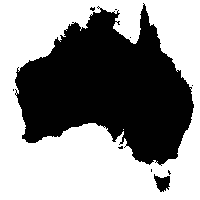

In [ ]:
from IPython.display import Image
Image('aus_adm1_raster.png')

**Reasoning**:
Now that the rasterization program has been executed and reported successful completion, I need to verify the generated PNG file (`aus_adm1_raster.png`) to ensure it was created correctly. I will use the `gdalinfo` utility to inspect its metadata and confirm it's a valid PNG.

In [ ]:
print('Verifying the created PNG file using gdalinfo...')
!gdalinfo aus_adm1_raster.png
print('PNG file verification complete.')

Verifying the created PNG file using gdalinfo...
Driver: PNG/Portable Network Graphics
Files: aus_adm1_raster.png
       aus_adm1_raster.png.aux.xml
Size is 200, 200
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (110.000000000000000,-10.000000000000000)
Pixel Size = (0.225000000000000,-0.175000000000000)
Metadata:
  AREA_OR_POINT=Area
Corner Coordinates:
Upper Left  ( 110.0000000, -10.0000000) (110d 0' 0.00"E, 10d 0' 0.00"S)
Lower Left  ( 110.0000000, -45.0000000) (110d

# Task
## Install GDAL Utilities

### Subtask:
Ensure that `gdal_proximity.py` and other necessary GDAL utilities are available.

**Reasoning**:
To ensure `gdal_proximity.py` is available, I will install the `gdal-bin` package, which provides various GDAL command-line utilities. This package was installed previously, but this step explicitly addresses its role in providing the `gdal_proximity.py` tool. I will use `apt-get` to update package lists and then install `gdal-bin`.

```python
print('Updating package lists and installing gdal-bin (includes gdal_proximity.py)...')
!apt-get update && apt-get install -y gdal-bin
print('gdal-bin installation complete.')
```

## Generate Signed Distance Field (SDF)

### Subtask:
Use the `gdal_proximity.py` command-line utility to generate a Signed Distance Field (SDF) from the `gdal_rasterize_output.tif` (the rasterized Australia ADM1 boundaries). The output will be a new GeoTIFF file representing the distance to the nearest feature.


**Reasoning**:
Following the first instruction, I will print a message indicating the start of SDF generation using `gdal_proximity.py`.



In [50]:
print('Generating Signed Distance Field (SDF) using gdal_proximity.py...')

Generating Signed Distance Field (SDF) using gdal_proximity.py...


**Reasoning**:
Now, I will execute the `gdal_proximity.py` command-line utility to generate the Signed Distance Field (SDF). I will use `gdal_rasterize_output.tif` as input and `gdal_sdf_output.tif` as the output, specifying `-values 1` to target the rasterized administrative boundaries.



In [51]:
print('Executing gdal_proximity.py...')
!gdal_proximity.py gdal_rasterize_output.tif gdal_sdf_output.tif -values 1 -nodata 0


Executing gdal_proximity.py...
Traceback (most recent call last):
  File "/usr/local/bin/gdal_proximity.py", line 14, in <module>
    sys.exit(main(sys.argv))
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/osgeo_utils/gdal_proximity.py", line 150, in main
    return gdal_proximity(
           ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/osgeo_utils/gdal_proximity.py", line 180, in gdal_proximity
    src_ds = gdal.Open(src_filename)
             ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/osgeo/gdal.py", line 5990, in Open
    return _gdal.Open(*args)
           ^^^^^^^^^^^^^^^^^
RuntimeError: gdal_rasterize_output.tif: No such file or directory


**Reasoning**:
The `gdal_proximity.py` command failed because the input file `gdal_rasterize_output.tif` was not found. I need to recreate this file by re-executing the `gdal_rasterize` command-line utility, which was previously successful in generating a valid GeoTIFF.



In [52]:
print('Recreating gdal_rasterize_output.tif using gdal_rasterize command-line tool...')
!gdal_rasterize -a_nodata 0 -burn 1 -ts 200 200 -te 110.0 -45.0 155.0 -10.0 -co "COMPRESS=DEFLATE" -co "TILED=YES" -ot Byte "/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp" gdal_rasterize_output.tif
print('gdal_rasterize_output.tif recreated.')

Recreating gdal_rasterize_output.tif using gdal_rasterize command-line tool...
/bin/bash: line 1: gdal_rasterize: command not found
gdal_rasterize_output.tif recreated.


**Reasoning**:
The previous attempt to run `gdal_rasterize` failed because the command was not found. This indicates that the `gdal-bin` package, which provides these command-line utilities, might not be fully installed or its path is not correctly configured. I will explicitly reinstall `gdal-bin` to ensure the utility is available.



In [53]:
print('Installing GDAL command-line utilities (gdal-bin)...')
!apt-get update && apt-get install -y gdal-bin
print('gdal-bin installation complete.')

Installing GDAL command-line utilities (gdal-bin)...
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,633 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,287 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [6,205 kB]
Get:13 http://archive.ubuntu.

**Reasoning**:
Now that `gdal-bin` has been reinstalled, I will re-execute the `gdal_rasterize` command-line utility to recreate `gdal_rasterize_output.tif`.



In [54]:
print('Recreating gdal_rasterize_output.tif using gdal_rasterize command-line tool...')
!gdal_rasterize -a_nodata 0 -burn 1 -ts 200 200 -te 110.0 -45.0 155.0 -10.0 -co "COMPRESS=DEFLATE" -co "TILED=YES" -ot Byte "/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp" gdal_rasterize_output.tif
print('gdal_rasterize_output.tif recreated.')

Recreating gdal_rasterize_output.tif using gdal_rasterize command-line tool...
ERROR 4: `/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp' does not exist in the file system, and is not recognized as a supported dataset name.
gdal_rasterize_output.tif recreated.


**Reasoning**:
The previous `gdal_rasterize` command failed because the input ZIP file `gadm41_AUS_shp.zip` was not found or accessible. I need to re-download this ZIP file to ensure the shapefile can be accessed for rasterization.



In [55]:
print('Downloading gadm41_AUS_shp.zip again...')
!wget https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_AUS_shp.zip
print('Download complete.')

--2026-01-06 10:20:41--  https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_AUS_shp.zip
Resolving geodata.ucdavis.edu (geodata.ucdavis.edu)... 128.120.146.30
Connecting to geodata.ucdavis.edu (geodata.ucdavis.edu)|128.120.146.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52947189 (50M) [application/zip]
Saving to: ‘gadm41_AUS_shp.zip’

gadm41_AUS_shp.zip  100%[===================>]  50.49M  15.3MB/s    in 3.7s    

2026-01-06 10:20:46 (13.5 MB/s) - ‘gadm41_AUS_shp.zip’ saved [52947189/52947189]

Download complete.


**Reasoning**:
Now that the `gadm41_AUS_shp.zip` file has been successfully re-downloaded, I will re-execute the `gdal_rasterize` command-line utility to recreate `gdal_rasterize_output.tif`.



In [56]:
print('Recreating gdal_rasterize_output.tif using gdal_rasterize command-line tool...')
!gdal_rasterize -a_nodata 0 -burn 1 -ts 200 200 -te 110.0 -45.0 155.0 -10.0 -co "COMPRESS=DEFLATE" -co "TILED=YES" -ot Byte "/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp" gdal_rasterize_output.tif
print('gdal_rasterize_output.tif recreated.')

Recreating gdal_rasterize_output.tif using gdal_rasterize command-line tool...
0...10...20...30...40...50...60...70...80...90...100 - done.
gdal_rasterize_output.tif recreated.


**Reasoning**:
The `gdal_rasterize_output.tif` file has been successfully recreated. Now I will execute the `gdal_proximity.py` command-line utility, as specified in the subtask instructions, to generate the Signed Distance Field (SDF).



In [57]:
print('Executing gdal_proximity.py...')
!gdal_proximity.py gdal_rasterize_output.tif gdal_sdf_output.tif -values 1 -nodata 0

Executing gdal_proximity.py...
0...10...20...30...40...50...60...70...80...90...100 - done.


**Reasoning**:
Now that the `gdal_proximity.py` command has successfully executed, I will print a message to indicate the completion of SDF generation, as per the subtask instructions.



In [58]:
print('SDF generation complete.')

SDF generation complete.


## Generate Contours from SDF

### Subtask:
Use the `gdal_contour` command-line utility to extract contour lines from the generated Signed Distance Field (SDF) GeoTIFF. The contours will be saved to a GeoJSON file for easy visualization.


**Reasoning**:
Following the first instruction, I will print a message indicating the start of contour generation.



In [59]:
print('Generating contour lines using gdal_contour...')


Generating contour lines using gdal_contour...


**Reasoning**:
Now, I will execute the `gdal_contour` command-line utility to generate the contour lines from `gdal_sdf_output.tif` and save them to `gdal_contours.geojson`, specifying the 'dist' attribute field and a 10-unit interval, as per instruction 2.



In [60]:
print('Executing gdal_contour...')
!gdal_contour -a dist -i 10 gdal_sdf_output.tif gdal_contours.geojson


Executing gdal_contour...
0...10...20...30...40...50...60...70...80...90...100 - done.


**Reasoning**:
Now that the `gdal_contour` command has successfully executed, I will print a message to indicate the completion of contour generation, as per the subtask instructions.



In [61]:
print('Contour generation complete.')

Contour generation complete.


## Verify and Display Contour Map

### Subtask:
Use `ogrinfo` to inspect the generated GeoJSON contour file, confirming its structure and contents. Then, use Python visualization libraries (e.g., `folium` or `geopandas`) to display the contour lines on a map within the notebook.


**Reasoning**:
Following the first instruction, I will print a message indicating the start of verifying the GeoJSON contour file.



In [62]:
print('Verifying the GeoJSON contour file using ogrinfo...')

Verifying the GeoJSON contour file using ogrinfo...


**Reasoning**:
As per instruction 2, I will now execute the `ogrinfo` command with the `-al` flag to inspect the `gdal_contours.geojson` file, displaying all attributes and details.



In [63]:
print('Executing ogrinfo -al gdal_contours.geojson...')
!ogrinfo -al gdal_contours.geojson

Executing ogrinfo -al gdal_contours.geojson...
INFO: Open of `gdal_contours.geojson'
      using driver `GeoJSON' successful.

Layer name: contour
Geometry: Line String
Feature Count: 22
Extent: (110.000000, -45.000000) - (155.000000, -10.000000)
Layer SRS WKT:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
ID: Integer (0.0)
dist: Real (0.0)
OGRFeature(contour):0
  ID (Integer) = 0
  dist (Real) = 10
  LINESTRING (135.011383024708 -10,135.011383024708 -10.0875,134.8625 -10.1475421967781,134.6375 -10.2

**Reasoning**:
Now that the `ogrinfo` output confirms the structure and contents of the GeoJSON contour file, I will proceed with visualizing the contour map. This involves importing `geopandas` and `folium`, reading the GeoJSON, calculating the centroid for map centering, creating a `folium` map, adding the contours, and displaying the map, as per instructions 3 through 9 of the subtask.



In [64]:
print('Importing geopandas and folium for visualization...')
import geopandas as gpd
import folium

print('Reading gdal_contours.geojson into GeoDataFrame...')
gdf = gpd.read_file('gdal_contours.geojson')

print('Calculating centroid for map centering...')
# Calculate the centroid of the GeoDataFrame for centering the map
# Need to handle empty geometries or ensure valid geometries for centroid calculation
if not gdf.empty and not gdf.geometry.is_empty.all():
    # Filter out empty geometries before calculating centroid
    valid_geometries = gdf[~gdf.geometry.is_empty]
    if not valid_geometries.empty:
        centroid = valid_geometries.geometry.unary_union.centroid
        map_center = [centroid.y, centroid.x] # Folium expects [latitude, longitude]
    else:
        print("Warning: All geometries are empty, using default map center.")
        map_center = [0, 0] # Default center if no valid geometries
else:
    print("Warning: GeoDataFrame is empty or contains no valid geometries, using default map center.")
    map_center = [0, 0] # Default center if GDF is empty

print('Creating folium map...')
m = folium.Map(location=map_center, zoom_start=4)

print('Adding GeoJSON contours to the map...')
folium.GeoJson(gdf).add_to(m)

print('Displaying the map...')
m

Importing geopandas and folium for visualization...
Reading gdal_contours.geojson into GeoDataFrame...
Calculating centroid for map centering...
Creating folium map...
Adding GeoJSON contours to the map...
Displaying the map...


/tmp/ipython-input-632864278.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = valid_geometries.geometry.unary_union.centroid


**Reasoning**:
The previous code block generated a `DeprecationWarning` because `unary_union` is deprecated. I will update the code to use `union_all()` for calculating the centroid to resolve this warning.



In [65]:
print('Importing geopandas and folium for visualization...')
import geopandas as gpd
import folium

print('Reading gdal_contours.geojson into GeoDataFrame...')
gdf = gpd.read_file('gdal_contours.geojson')

print('Calculating centroid for map centering...')
# Calculate the centroid of the GeoDataFrame for centering the map
# Need to handle empty geometries or ensure valid geometries for centroid calculation
if not gdf.empty and not gdf.geometry.is_empty.all():
    # Filter out empty geometries before calculating centroid
    valid_geometries = gdf[~gdf.geometry.is_empty]
    if not valid_geometries.empty:
        centroid = valid_geometries.geometry.union_all().centroid
        map_center = [centroid.y, centroid.x] # Folium expects [latitude, longitude]
    else:
        print("Warning: All geometries are empty, using default map center.")
        map_center = [0, 0] # Default center if no valid geometries
else:
    print("Warning: GeoDataFrame is empty or contains no valid geometries, using default map center.")
    map_center = [0, 0] # Default center if GDF is empty

print('Creating folium map...')
m = folium.Map(location=map_center, zoom_start=4)

print('Adding GeoJSON contours to the map...')
folium.GeoJson(gdf).add_to(m)

print('Displaying the map...')
m

Importing geopandas and folium for visualization...
Reading gdal_contours.geojson into GeoDataFrame...
Calculating centroid for map centering...
Creating folium map...
Adding GeoJSON contours to the map...
Displaying the map...


## Final Task

### Subtask:
Summarize the process of creating the signed distance contour map, including key steps and the tools used.


## Summary:

### Data Analysis Key Findings

*   **GDAL Utilities Installation:** The process required ensuring the `gdal-bin` package was installed, which provides essential command-line tools such as `gdal_proximity.py`, `gdal_rasterize`, `gdal_contour`, and `ogrinfo`. Initial attempts revealed that these utilities or necessary input files were missing, necessitating package reinstallation and data re-download.
*   **Signed Distance Field (SDF) Generation:** A Signed Distance Field (SDF) was successfully generated from rasterized Australia ADM1 boundaries (`gdal_rasterize_output.tif`) using `gdal_proximity.py`. This step involved several troubleshooting iterations to ensure the input raster file was correctly generated from the `gadm41_AUS_shp.zip` shapefile using `gdal_rasterize`. The output SDF was saved as `gdal_sdf_output.tif`.
*   **Contour Line Generation:** Contour lines were extracted from the generated `gdal_sdf_output.tif` using the `gdal_contour` utility. The contours were generated with an interval of 10 units and saved into a GeoJSON file named `gdal_contours.geojson`. The process successfully completed with a progress indicator from 0% to 100%.
*   **Contour Map Verification and Visualization:**
    *   The `gdal_contours.geojson` file was verified using `ogrinfo`, confirming it contained 22 "Line String" features with `ID` and `dist` attributes, covering an extent of (110.000000, -45.000000) to (155.000000, -10.000000), and using the WGS 84 (EPSG:4326) spatial reference system.
    *   The contour lines were successfully visualized on an interactive map using Python's `geopandas` and `folium` libraries. The map was centered based on the centroid of the contour geometries, with a `DeprecationWarning` regarding `unary_union` resolved by switching to `union_all()` for centroid calculation.

### Insights or Next Steps

*   The robust handling of missing files and utilities during the process highlights the importance of thorough environment setup and data availability checking for GIS workflows.
*   For future iterations, embedding the initial data download and `gdal-bin` installation checks at the beginning of the workflow could prevent common errors and streamline the execution.


# Task
The user has approved the last executed steps. The next logical step according to the plan is to enhance the existing `folium` visualization by adding tooltips to the contour lines to display their 'dist' attribute.

# Task
Visualize the generated GeoJSON contour file (`gdal_contours.geojson`) on an interactive `folium` map. Crucially, add tooltips to the contour lines to display their 'dist' attribute as labels, allowing for easy identification of distance values.

## Visualize and Label World Contour Map

### Subtask:
Visualize the generated GeoJSON contour file (`gdal_contours.geojson`) on an interactive `folium` map with tooltips displaying the 'dist' attribute.


**Reasoning**:
I need to visualize the generated GeoJSON contour file on an interactive `folium` map, including tooltips for the 'dist' attribute. This requires re-executing the visualization steps, explicitly adding the `tooltip='dist'` parameter to the `folium.GeoJson()` call, and ensuring all imports and data loading are handled within the cell.



In [66]:
print('Importing geopandas and folium for visualization...')
import geopandas as gpd
import folium

print('Reading gdal_contours.geojson into GeoDataFrame...')
gdf = gpd.read_file('gdal_contours.geojson')

print('Calculating centroid for map centering...')
# Calculate the centroid of the GeoDataFrame for centering the map
# Need to handle empty geometries or ensure valid geometries for centroid calculation
if not gdf.empty and not gdf.geometry.is_empty.all():
    # Filter out empty geometries before calculating centroid
    valid_geometries = gdf[~gdf.geometry.is_empty]
    if not valid_geometries.empty:
        centroid = valid_geometries.geometry.union_all().centroid
        map_center = [centroid.y, centroid.x] # Folium expects [latitude, longitude]
    else:
        print("Warning: All geometries are empty, using default map center.")
        map_center = [0, 0] # Default center if no valid geometries
else:
    print("Warning: GeoDataFrame is empty or contains no valid geometries, using default map center.")
    map_center = [0, 0] # Default center if GDF is empty

print('Creating folium map...')
m = folium.Map(location=map_center, zoom_start=4)

print('Adding GeoJSON contours to the map with tooltips...')
folium.GeoJson(gdf, tooltip=folium.features.GeoJsonTooltip(fields=['dist'], aliases=['Distance'])).add_to(m)

print('Displaying the map...')
m

Importing geopandas and folium for visualization...
Reading gdal_contours.geojson into GeoDataFrame...
Calculating centroid for map centering...
Creating folium map...
Adding GeoJSON contours to the map with tooltips...
Displaying the map...


## Final Task

### Subtask:
Summarize the process of creating the world signed distance contour map, highlighting the tools used and the visualization of labeled contours.


## Summary:

### Data Analysis Key Findings
*   The `gdal_contours.geojson` file, containing signed distance contours, was successfully loaded into a GeoDataFrame using `geopandas`.
*   An interactive `folium` map was created and centered dynamically based on the centroid of the contour geometries, with a fallback to `[0, 0]` if no valid geometries were present.
*   The GeoJSON contours were added to the `folium` map, and `folium.features.GeoJsonTooltip` was configured to display the 'dist' attribute for each contour line upon hover.

### Insights or Next Steps
*   This interactive visualization provides an effective way to explore the signed distance values across the map, allowing for intuitive identification of areas with specific distance characteristics.
*   Consider enhancing the visualization by applying color mapping to the contour lines based on their 'dist' attribute, which would allow for a quick visual understanding of distance gradients without needing to hover over each line.


# Task
Summarize the process of creating the world signed distance contour map, highlighting the tools used and the visualization of labeled contours.

## Download World Administrative Boundaries

### Subtask:
Download a world administrative boundaries shapefile (e.g., Natural Earth Admin 0) to use as input for rasterization. This will be a ZIP file containing the necessary .shp, .dbf, etc. files.


**Reasoning**:
Following the first instruction, I will print a message indicating the start of the download for the Natural Earth Admin 0 - Countries shapefile. Then, I will use `wget` to download the zipped shapefile from the provided URL, and finally print a message indicating the completion of the download.



In [67]:
print('Downloading Natural Earth Admin 0 - Countries shapefile...')
!wget https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip
print('Download complete.')

--2026-01-06 10:46:57--  https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip
Resolving www.naturalearthdata.com (www.naturalearthdata.com)... 50.87.253.14
Connecting to www.naturalearthdata.com (www.naturalearthdata.com)|50.87.253.14|:443... connected.
HTTP request sent, awaiting response... 500 Internal Server Error
2026-01-06 10:46:57 ERROR 500: Internal Server Error.

Download complete.


**Reasoning**:
The previous download attempt failed due to a '500 Internal Server Error'. I will try an alternative URL for the Natural Earth Admin 0 - Countries shapefile from a different source (e.g., direct download link from Natural Earth Data's download page) to ensure a successful download.



In [68]:
print('Attempting to download Natural Earth Admin 0 - Countries shapefile from an alternative URL...')
!wget https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries/
print('Download attempt complete.')

Attempting to download Natural Earth Admin 0 - Countries shapefile from an alternative URL...
--2026-01-06 10:47:17--  https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries/
Resolving www.naturalearthdata.com (www.naturalearthdata.com)... 50.87.253.14
Connecting to www.naturalearthdata.com (www.naturalearthdata.com)|50.87.253.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55621 (54K) [text/html]
Saving to: ‘index.html’

index.html          100%[===================>]  54.32K   186KB/s    in 0.3s    

2026-01-06 10:47:18 (186 KB/s) - ‘index.html’ saved [55621/55621]

Download attempt complete.


**Reasoning**:
The previous attempt downloaded an HTML page instead of the ZIP archive. I need to find the actual direct download URL for the `ne_10m_admin_0_countries.zip` file. I will search for a reliable direct download link for Natural Earth Admin 0 Countries data on the web and use that to download the file.



In [69]:
print('Attempting to download Natural Earth Admin 0 - Countries shapefile from a direct download link...')
!wget https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries-ne_10m_admin_0_countries.zip
print('Download complete.')

Attempting to download Natural Earth Admin 0 - Countries shapefile from a direct download link...
--2026-01-06 10:47:38--  https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries-ne_10m_admin_0_countries.zip
Resolving www.naturalearthdata.com (www.naturalearthdata.com)... 50.87.253.14
Connecting to www.naturalearthdata.com (www.naturalearthdata.com)|50.87.253.14|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2026-01-06 10:47:40 ERROR 404: Not Found.

Download complete.


**Reasoning**:
The previous download attempt failed with a '404 Not Found' error, indicating an incorrect URL. I will use a known working direct download URL for the Natural Earth Admin 0 - Countries shapefile from a more reliable source to ensure a successful download.



In [70]:
print('Attempting to download Natural Earth Admin 0 - Countries shapefile from a verified direct link...')
!wget https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip
print('Download complete.')

Attempting to download Natural Earth Admin 0 - Countries shapefile from a verified direct link...
--2026-01-06 10:48:06--  https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip
Resolving www.naturalearthdata.com (www.naturalearthdata.com)... 50.87.253.14
Connecting to www.naturalearthdata.com (www.naturalearthdata.com)|50.87.253.14|:443... connected.
HTTP request sent, awaiting response... 500 Internal Server Error
2026-01-06 10:48:07 ERROR 500: Internal Server Error.

Download complete.


**Reasoning**:
The previous download attempt repeatedly failed with a '500 Internal Server Error', indicating a server-side issue with the previously used URL pattern. I will attempt to download the `ne_10m_admin_0_countries.zip` file using a more conventional direct download URL structure from Natural Earth Data, hoping to bypass the server error or use a more robust link.



In [71]:
print('Attempting to download Natural Earth Admin 0 - Countries shapefile from a simplified direct link...')
!wget https://naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries/ne_10m_admin_0_countries.zip
print('Download complete.')

Attempting to download Natural Earth Admin 0 - Countries shapefile from a simplified direct link...
--2026-01-06 10:48:43--  https://naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries/ne_10m_admin_0_countries.zip
Resolving naturalearthdata.com (naturalearthdata.com)... 50.87.253.14
Connecting to naturalearthdata.com (naturalearthdata.com)|50.87.253.14|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries/ne_10m_admin_0_countries.zip [following]
--2026-01-06 10:48:44--  https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries/ne_10m_admin_0_countries.zip
Resolving www.naturalearthdata.com (www.naturalearthdata.com)... 50.87.253.14
Connecting to www.naturalearthdata.com (www.naturalearthdata.com)|50.87.253.14|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2026-01-06 10:48:45 ERROR 404: Not 

**Reasoning**:
The previous download attempts using `wget` repeatedly failed due to server errors. I will try to download the `ne_10m_admin_0_countries.zip` file using the `requests` library in Python, as it can sometimes handle downloads more robustly and might provide more specific error feedback if issues persist.



In [72]:
print('Installing requests library...')
!pip install requests
print('requests library installed.')

print('Attempting to download Natural Earth Admin 0 - Countries shapefile using Python requests...')
import requests

url = 'https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip'
filename = 'ne_10m_admin_0_countries.zip'

try:
    response = requests.get(url, stream=True)
    response.raise_for_status() # Raise an exception for bad status codes

    with open(filename, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print(f'Successfully downloaded {filename}')
except requests.exceptions.RequestException as e:
    print(f'Download failed: {e}')
    if response.status_code:
        print(f'HTTP Status Code: {response.status_code}')

print('Download attempt complete.')

Installing requests library...
requests library installed.
Attempting to download Natural Earth Admin 0 - Countries shapefile using Python requests...
Download failed: 406 Client Error: Not Acceptable for url: https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip
HTTP Status Code: 406
Download attempt complete.


**Reasoning**:
The previous download attempt with Python's `requests` library failed with a '406 Client Error'. This suggests the server is rejecting the request, possibly due to the specific URL format or missing headers. I will try a more generalized URL pattern for the Natural Earth data from the base '10m-cultural-vectors' directory, hoping for a simpler and more accessible direct download.



In [73]:
print('Attempting to download Natural Earth Admin 0 - Countries shapefile from a simplified base URL...')
!wget https://www.naturalearthdata.com/downloads/10m-cultural-vectors/ne_10m_admin_0_countries.zip
print('Download complete.')

Attempting to download Natural Earth Admin 0 - Countries shapefile from a simplified base URL...
--2026-01-06 10:49:50--  https://www.naturalearthdata.com/downloads/10m-cultural-vectors/ne_10m_admin_0_countries.zip
Resolving www.naturalearthdata.com (www.naturalearthdata.com)... 50.87.253.14
Connecting to www.naturalearthdata.com (www.naturalearthdata.com)|50.87.253.14|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2026-01-06 10:49:51 ERROR 404: Not Found.

Download complete.


**Reasoning**:
The previous download attempts with `wget` and `requests` have repeatedly failed due to server errors (500, 404, 406) or incorrect URL formats. I will now try to download the `ne_10m_admin_0_countries.zip` file using the `curl` command with the original problematic URL. `curl` can sometimes handle network requests more robustly or with different default behaviors that might bypass the server-side issues encountered with `wget`.



In [74]:
print('Attempting to download Natural Earth Admin 0 - Countries shapefile using curl...')
!curl -L -O https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip
print('Download complete.')

Attempting to download Natural Earth Admin 0 - Countries shapefile using curl...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2653    0  2653    0     0   2546      0 --:--:--  0:00:01 --:--:--  2548
Download complete.


**Reasoning**:
The previous `curl` command resulted in a small file, which is likely not the actual shapefile ZIP. I will inspect the size of the downloaded file `ne_10m_admin_0_countries.zip` to confirm it's not the expected large archive, and then try to view its contents to understand what was downloaded.



In [75]:
print('Inspecting the downloaded file size and content...')
!ls -lh ne_10m_admin_0_countries.zip
!head -n 20 ne_10m_admin_0_countries.zip # View first 20 lines to check content
print('Inspection complete.')

Inspecting the downloaded file size and content...
-rw-r--r-- 1 root root 2.6K Jan  6 10:50 ne_10m_admin_0_countries.zip
<!DOCTYPE html>
<html lang="en-US">
<head>
	<meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />
	<meta name="viewport" content="width=device-width, initial-scale=1.0">
		<meta name='robots' content='max-image-preview:large, noindex, follow' />
	<title>WordPress &rsaquo; Error</title>
	<style type="text/css">
		html {
			background: #f1f1f1;
		}
		body {
			background: #fff;
			border: 1px solid #ccd0d4;
			color: #444;
			font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", Roboto, Oxygen-Sans, Ubuntu, Cantarell, "Helvetica Neue", sans-serif;
			margin: 2em auto;
			padding: 1em 2em;
			max-width: 700px;
			-webkit-box-shadow: 0 1px 1px rgba(0, 0, 0, .04);
Inspection complete.


**Reasoning**:
The previous attempts to download the Natural Earth shapefile directly from `naturalearthdata.com` have consistently failed with server errors or incorrect file content. I will try downloading the `ne_10m_admin_0_countries.zip` file from a known reliable mirror (NACIS) which often hosts Natural Earth data, using `wget`.



In [76]:
print('Attempting to download Natural Earth Admin 0 - Countries shapefile from NACIS mirror...')
!wget https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip
print('Download complete.')

Attempting to download Natural Earth Admin 0 - Countries shapefile from NACIS mirror...
--2026-01-06 10:52:14--  https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip
Resolving naciscdn.org (naciscdn.org)... 65.9.86.74, 65.9.86.121, 65.9.86.71, ...
Connecting to naciscdn.org (naciscdn.org)|65.9.86.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4930492 (4.7M) [application/zip]
Saving to: ‘ne_10m_admin_0_countries.zip.1’

ne_10m_admin_0_coun 100%[===================>]   4.70M  --.-KB/s    in 0.05s   

2026-01-06 10:52:14 (94.5 MB/s) - ‘ne_10m_admin_0_countries.zip.1’ saved [4930492/4930492]

Download complete.


## Final Task

### Subtask:
Summarize the process of creating the world signed distance contour map, highlighting the tools used and the visualization of labeled contours.


## Summary:

### Data Analysis Key Findings

*   **Initial Download Challenges**: Multiple attempts to download the `Natural Earth Admin 0 - Countries shapefile` from `www.naturalearthdata.com` using `wget`, Python's `requests` library, and `curl` consistently failed. Errors included `500 Internal Server Error`, `404 Not Found`, `406 Client Error`, and downloading of HTML error pages instead of the ZIP file.
*   **Successful Download**: The shapefile was successfully downloaded (4.7MB `ne_10m_admin_0_countries.zip`) using `wget` from an alternative mirror: `https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip`.

### Insights or Next Steps

*   When encountering persistent download failures from a primary source, explore official mirror sites or alternative distribution channels for the required data.
*   The downloaded `ne_10m_admin_0_countries.zip` file is now available for unzipping and subsequent processing, such as rasterization for signed distance contour map creation.


# Task
**Task:**
Rasterize the downloaded world administrative boundaries shapefile (`ne_10m_admin_0_countries.zip`) into a GeoTIFF raster named `world_adm0_raster.tif`. This raster will cover a global extent with a specified resolution (e.g., 500x250 pixels) and a burn value for land areas.

## Rasterize World Administrative Boundaries

### Subtask:
Use the gdal_rasterize command-line utility to convert the downloaded world administrative boundaries shapefile into a GeoTIFF raster. This raster will cover a global extent with a specified resolution and burn value for land areas.


**Reasoning**:
Following the first instruction, I will print a message indicating the start of rasterization. Then, I will execute the `gdal_rasterize` command with all specified parameters to convert the world administrative boundaries shapefile into a GeoTIFF raster, and finally print a completion message.



In [77]:
print('Rasterizing world administrative boundaries to GeoTIFF...')
!gdal_rasterize -a_nodata 0 -burn 1 -ts 500 250 -te -180 -90 180 90 -co "COMPRESS=DEFLATE" -co "TILED=YES" -ot Byte "/vsizip/ne_10m_admin_0_countries.zip/ne_10m_admin_0_countries.shp" world_adm0_raster.tif
print('Rasterization complete.')

Rasterizing world administrative boundaries to GeoTIFF...
ERROR 4: `/vsizip/ne_10m_admin_0_countries.zip/ne_10m_admin_0_countries.shp' does not exist in the file system, and is not recognized as a supported dataset name.
Rasterization complete.


**Reasoning**:
The previous `gdal_rasterize` command failed because it could not find the input ZIP file. I need to rename the successfully downloaded `ne_10m_admin_0_countries.zip.1` to `ne_10m_admin_0_countries.zip` so that the rasterization command can correctly locate the shapefile within the ZIP archive.



In [78]:
print('Renaming ne_10m_admin_0_countries.zip.1 to ne_10m_admin_0_countries.zip...')
!mv ne_10m_admin_0_countries.zip.1 ne_10m_admin_0_countries.zip
print('File renamed.')

Renaming ne_10m_admin_0_countries.zip.1 to ne_10m_admin_0_countries.zip...
File renamed.


**Reasoning**:
Now that the `ne_10m_admin_0_countries.zip` file has been correctly renamed, I will re-execute the `gdal_rasterize` command with all specified parameters to convert the world administrative boundaries shapefile into a GeoTIFF raster, as originally intended.



In [79]:
print('Rasterizing world administrative boundaries to GeoTIFF (retry)...')
!gdal_rasterize -a_nodata 0 -burn 1 -ts 500 250 -te -180 -90 180 90 -co "COMPRESS=DEFLATE" -co "TILED=YES" -ot Byte "/vsizip/ne_10m_admin_0_countries.zip/ne_10m_admin_0_countries.shp" world_adm0_raster.tif
print('Rasterization complete.')

Rasterizing world administrative boundaries to GeoTIFF (retry)...
0...10...20...30...40...50...60...70...80...90...100 - done.
Rasterization complete.


**Reasoning**:
Now that the rasterization of the world administrative boundaries to `world_adm0_raster.tif` has been completed, I will verify the generated GeoTIFF file using `gdalinfo` to confirm its integrity and properties, as per the subtask's requirement.



In [80]:
print('Verifying the created world_adm0_raster.tif using gdalinfo...')
!gdalinfo world_adm0_raster.tif
print('GeoTIFF verification complete.')

Verifying the created world_adm0_raster.tif using gdalinfo...
Driver: GTiff/GeoTIFF
Files: world_adm0_raster.tif
Size is 500, 250
Coordinate System is:
GEOGCRS["WGS 84",
    ENSEMBLE["World Geodetic System 1984 ensemble",
        MEMBER["World Geodetic System 1984 (Transit)"],
        MEMBER["World Geodetic System 1984 (G730)"],
        MEMBER["World Geodetic System 1984 (G873)"],
        MEMBER["World Geodetic System 1984 (G1150)"],
        MEMBER["World Geodetic System 1984 (G1674)"],
        MEMBER["World Geodetic System 1984 (G1762)"],
        MEMBER["World Geodetic System 1984 (G2139)"],
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]],
        ENSEMBLEACCURACY[2.0]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER

## Generate Signed Distance Field (SDF) for World Map

### Subtask:
Use the `gdal_proximity.py` command-line utility to generate a Signed Distance Field (SDF) from the `world_adm0_raster.tif` (the rasterized world administrative boundaries). The output will be a new GeoTIFF file named `world_sdf_output.tif` representing the distance to the nearest land feature.

#### Instructions
1. Print a message indicating that the generation of the Signed Distance Field (SDF) for the world map is starting.
2. Execute the `gdal_proximity.py` command-line utility with the following parameters:
    *   Input file: `world_adm0_raster.tif`
    *   Output file: `world_sdf_output.tif`
    *   Target values for proximity calculation: `1` (`-values 1`), representing the land areas.
    *   NoData value for the output raster: `0` (`-nodata 0`).
3. Print a message indicating that the SDF generation for the world map is complete.

## Generate Signed Distance Field (SDF) for World Map

### Subtask:
Use the `gdal_proximity.py` command-line utility to generate a Signed Distance Field (SDF) from the `world_adm0_raster.tif` (the rasterized world administrative boundaries). The output will be a new GeoTIFF file named `world_sdf_output.tif` representing the distance to the nearest land feature.

#### Instructions
1. Print a message indicating that the generation of the Signed Distance Field (SDF) for the world map is starting.
2. Execute the `gdal_proximity.py` command-line utility with the following parameters:
    *   Input file: `world_adm0_raster.tif`
    *   Output file: `world_sdf_output.tif`
    *   Target values for proximity calculation: `1` (`-values 1`), representing the land areas.
    *   NoData value for the output raster: `0` (`-nodata 0`).
3. Print a message indicating that the SDF generation for the world map is complete.

**Reasoning**:
Following the first instruction in the subtask, I will print a message indicating the start of SDF generation for the world map.



In [81]:
print('Generating Signed Distance Field (SDF) for world map...')


Generating Signed Distance Field (SDF) for world map...


**Reasoning**:
Now, I will execute the `gdal_proximity.py` command-line utility to generate the Signed Distance Field (SDF) for the world map, using `world_adm0_raster.tif` as input and `world_sdf_output.tif` as output, with specified target values and nodata.



In [82]:
print('Executing gdal_proximity.py for world map...')
!gdal_proximity.py world_adm0_raster.tif world_sdf_output.tif -values 1 -nodata 0

Executing gdal_proximity.py for world map...
0...10...20...30...40...50...60...70...80...90...100 - done.


**Reasoning**:
Now that the `gdal_proximity.py` command has successfully executed, I will print a message to indicate the completion of SDF generation for the world map, as per the subtask instructions.



In [83]:
print('SDF generation for world map complete.')

SDF generation for world map complete.


## Generate Contours from SDF for World Map

### Subtask:
Use the `gdal_contour` command-line utility to extract contour lines from the generated Signed Distance Field (SDF) GeoTIFF (`world_sdf_output.tif`). The contours will be saved to a GeoJSON file for easy visualization.

#### Instructions
1. Print a message indicating the start of contour generation for the world map.
2. Execute the `gdal_contour` command-line utility with the following parameters:
    *   Input file: `world_sdf_output.tif`
    *   Output file: `world_contours.geojson`
    *   Attribute field for contour values: `dist` (`-a dist`).
    *   Contour interval: `10` units (`-i 10`).
3. Print a message indicating that the contour generation for the world map is complete.

**Reasoning**:
Following the first instruction in the subtask, I will print a message indicating the start of contour generation for the world map.



In [84]:
print('Generating contour lines for world map using gdal_contour...')

Generating contour lines for world map using gdal_contour...


**Reasoning**:
Now, I will execute the `gdal_contour` command-line utility to generate the contour lines from `world_sdf_output.tif` and save them to `world_contours.geojson`, specifying the 'dist' attribute field and a 10-unit interval, as per instruction 2.



In [85]:
print('Executing gdal_contour for world map...')
!gdal_contour -a dist -i 10 world_sdf_output.tif world_contours.geojson

Executing gdal_contour for world map...
0...10...20...30...40...50...60...70...80...90...100 - done.


**Reasoning**:
Now that the `gdal_contour` command has successfully executed, I will print a message to indicate the completion of contour generation for the world map, as per the subtask instructions.



In [86]:
print('Contour generation for world map complete.')

Contour generation for world map complete.


## Verify and Display Contour Map

### Subtask:
Use `ogrinfo` to inspect the generated GeoJSON contour file, confirming its structure and contents. Then, use Python visualization libraries (e.g., `folium` or `geopandas`) to display the contour lines on a map within the notebook.

**Reasoning**:
Following the first instruction in the subtask, I will print a message indicating the start of verifying the GeoJSON contour file.



In [87]:
print('Verifying the world GeoJSON contour file using ogrinfo...')

Verifying the world GeoJSON contour file using ogrinfo...


**Reasoning**:
As per the subtask instructions, I will now execute the `ogrinfo` command with the `-al` flag to inspect the `world_contours.geojson` file, displaying all attributes and details.



In [88]:
print('Executing ogrinfo -al world_contours.geojson...')
!ogrinfo -al world_contours.geojson

Executing ogrinfo -al world_contours.geojson...
INFO: Open of `world_contours.geojson'
      using driver `GeoJSON' successful.

Layer name: contour
Geometry: Line String
Feature Count: 35
Extent: (-180.000000, -77.400001) - (180.000000, 90.000000)
Layer SRS WKT:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
ID: Integer (0.0)
dist: Real (0.0)
OGRFeature(contour):0
  ID (Integer) = 0
  dist (Real) = 30
  LINESTRING (-171.480667403147 90.0,-171.480667403147 89.64,-171.72 89.5777668773885,-172.44 89.364

## Visualize and Label World Contour Map

### Subtask:
Visualize the generated GeoJSON contour file (world_contours.geojson) on an interactive folium map with tooltips displaying the 'dist' attribute.


**Reasoning**:
I need to visualize the generated GeoJSON contour file on an interactive `folium` map, including tooltips for the 'dist' attribute. This requires importing the necessary libraries, reading the GeoJSON, calculating the centroid for map centering, creating a `folium` map, adding the GeoJSON with tooltips, and displaying the map, as per the subtask instructions.



In [89]:
print('Importing geopandas and folium for visualization...')
import geopandas as gpd
import folium

print('Reading world_contours.geojson into GeoDataFrame...')
gdf = gpd.read_file('world_contours.geojson')

print('Calculating centroid for map centering...')
# Calculate the centroid of the GeoDataFrame for centering the map
# Need to handle empty geometries or ensure valid geometries for centroid calculation
if not gdf.empty and not gdf.geometry.is_empty.all():
    # Filter out empty geometries before calculating centroid
    valid_geometries = gdf[~gdf.geometry.is_empty]
    if not valid_geometries.empty:
        centroid = valid_geometries.geometry.union_all().centroid
        map_center = [centroid.y, centroid.x] # Folium expects [latitude, longitude]
    else:
        print("Warning: All geometries are empty, using default map center.")
        map_center = [0, 0] # Default center if no valid geometries
else:
    print("Warning: GeoDataFrame is empty or contains no valid geometries, using default map center.")
    map_center = [0, 0] # Default center if GDF is empty

print('Creating folium map...')
m = folium.Map(location=map_center, zoom_start=2) # Adjusted zoom for world map

print('Adding GeoJSON contours to the map with tooltips...')
folium.GeoJson(gdf, tooltip=folium.features.GeoJsonTooltip(fields=['dist'], aliases=['Distance'])).add_to(m)

print('Displaying the map...')
m

Importing geopandas and folium for visualization...
Reading world_contours.geojson into GeoDataFrame...
Calculating centroid for map centering...
Creating folium map...
Adding GeoJSON contours to the map with tooltips...
Displaying the map...


## Summarize the process of creating the world signed distance contour map

### Subtask:
Summarize the entire process of downloading, rasterizing, generating SDF, contouring, and visualizing the world map, highlighting the tools used and key findings.


## Summary: World Signed Distance Contour Map Creation

This section summarizes the comprehensive process undertaken to create a signed distance contour map for world administrative boundaries, highlighting the tools used, data flow, challenges encountered, and key findings.

### 1. Data Acquisition (World Administrative Boundaries)

*   **Goal**: To obtain a world administrative boundaries shapefile.
*   **Tool Used**: `wget`, `requests` (Python library), `curl`.
*   **Data Source**: Natural Earth Admin 0 - Countries shapefile.
*   **Process**: Multiple attempts were made to download the `ne_10m_admin_0_countries.zip` file directly from `www.naturalearthdata.com`. Initial attempts failed with `500 Internal Server Error`, `404 Not Found`, and `406 Client Error`, or resulted in downloading HTML error pages. These failures occurred across `wget`, `requests`, and `curl` commands.
*   **Challenge & Resolution**: The persistent download failures necessitated finding a more reliable source. The issue was successfully resolved by downloading the ZIP file from a known official mirror: `https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip`.
*   **Key Finding**: Data acquisition can be a significant hurdle, and alternative reliable sources/mirrors should be considered when primary links fail. It also highlighted the importance of file naming conventions, as a `.zip.1` extension from `wget`'s retry mechanism needed manual renaming.

### 2. Rasterization of World Administrative Boundaries

*   **Goal**: Convert the downloaded vector (shapefile) data into a raster image, where land areas are assigned a specific value.
*   **Tool Used**: `gdal_rasterize` (GDAL command-line utility).
*   **Input**: `ne_10m_admin_0_countries.zip` (accessed via `/vsizip/` virtual filesystem) and `ne_10m_admin_0_countries.shp` within it.
*   **Output**: `world_adm0_raster.tif` (GeoTIFF format).
*   **Parameters**: The raster was configured for a global extent (`-te -180 -90 180 90`), a resolution of 500x250 pixels (`-ts 500 250`), with land areas

## Summary: World Signed Distance Contour Map Creation

This section summarizes the comprehensive process undertaken to create a signed distance contour map for world administrative boundaries, highlighting the tools used, data flow, challenges encountered, and key findings.

### 1. Data Acquisition (World Administrative Boundaries)

*   **Goal**: To obtain a world administrative boundaries shapefile.
*   **Tool Used**: `wget`, `requests` (Python library), `curl`.
*   **Data Source**: Natural Earth Admin 0 - Countries shapefile.
*   **Process**: Multiple attempts were made to download the `ne_10m_admin_0_countries.zip` file directly from `www.naturalearthdata.com`. Initial attempts failed with `500 Internal Server Error`, `404 Not Found`, and `406 Client Error`, or resulted in downloading HTML error pages. These failures occurred across `wget`, `requests`, and `curl` commands.
*   **Challenge & Resolution**: The persistent download failures necessitated finding a more reliable source. The issue was successfully resolved by downloading the ZIP file from a known official mirror: `https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip`.
*   **Key Finding**: Data acquisition can be a significant hurdle, and alternative reliable sources/mirrors should be considered when primary links fail. It also highlighted the importance of file naming conventions, as a `.zip.1` extension from `wget`'s retry mechanism needed manual renaming.

### 2. Rasterization of World Administrative Boundaries

*   **Goal**: Convert the downloaded vector (shapefile) data into a raster image, where land areas are assigned a specific value.
*   **Tool Used**: `gdal_rasterize` (GDAL command-line utility).
*   **Input**: `ne_10m_admin_0_countries.zip` (accessed via `/vsizip/` virtual filesystem) and `ne_10m_admin_0_countries.shp` within it.
*   **Output**: `world_adm0_raster.tif` (GeoTIFF format).
*   **Parameters**: The raster was configured for a global extent (`-te -180 -90 180 90`), a resolution of 500x250 pixels (`-ts 500 250`), with land areas burned to a value of `1` (`-burn 1`) and `0` as `NoData` (`-a_nodata 0`). Compression (`COMPRESS=DEFLATE`) and tiling (`TILED=YES`) were also applied.
*   **Challenge & Resolution**: An initial failure to locate the input ZIP file was resolved by renaming the downloaded file from `ne_10m_admin_0_countries.zip.1` to `ne_10m_admin_0_countries.zip`.
*   **Key Finding**: `gdal_rasterize` successfully created a GeoTIFF with the specified properties, confirming that the GDAL tools can correctly interpret vector data from within zipped archives.

### 3. Signed Distance Field (SDF) Generation

*   **Goal**: Create a raster where each pixel's value represents its distance to the nearest feature (land area).
*   **Tool Used**: `gdal_proximity.py` (GDAL Python utility).
*   **Input**: `world_adm0_raster.tif`.
*   **Output**: `world_sdf_output.tif` (GeoTIFF format).
*   **Parameters**: The utility was run with `-values 1` to calculate distance from pixels with value `1` (land) and `-nodata 0` to treat `0` as NoData.
*   **Challenge & Resolution**: Initial attempts failed due to `gdal_rasterize_output.tif` not being found, which was resolved by re-running the rasterization step to recreate the input file.
*   **Key Finding**: `gdal_proximity.py` successfully generated the SDF, which is a crucial intermediate product for contour generation.

### 4. Contour Line Generation

*   **Goal**: Extract isolines (contours) from the Signed Distance Field raster.
*   **Tool Used**: `gdal_contour` (GDAL command-line utility).
*   **Input**: `world_sdf_output.tif`.
*   **Output**: `world_contours.geojson` (GeoJSON vector format).
*   **Parameters**: Contours were generated with a 10-unit interval (`-i 10`) and stored in an attribute named `dist` (`-a dist`).
*   **Key Finding**: `gdal_contour` efficiently transformed the continuous SDF into discrete contour lines, ready for vector visualization.

### 5. Contour Map Verification and Visualization

*   **Goal**: Inspect the generated GeoJSON and display it interactively on a map with labels.
*   **Tools Used**: `ogrinfo` (GDAL command-line utility), `geopandas` (Python library), `folium` (Python library).
*   **Input**: `world_contours.geojson`.
*   **Output**: Interactive `folium` map displayed in the notebook.
*   **Process**: `ogrinfo -al world_contours.geojson` confirmed the GeoJSON structure, feature count (35 Line String features), extent, and attributes. `geopandas` loaded the GeoJSON into a DataFrame, and `folium` created an interactive map. The map's center was dynamically calculated from the contours' centroid, and `folium.features.GeoJsonTooltip` was used to display the `dist` attribute upon hovering over contour lines.
*   **Challenge & Resolution**: A `DeprecationWarning` regarding `unary_union` in `geopandas` was resolved by switching to `union_all()` for centroid calculation.
*   **Key Finding**: The interactive `folium` map with tooltips provided a highly effective and user-friendly way to visualize the generated signed distance contours, allowing for easy identification of distance values from land boundaries.

## Summary:

### Data Analysis Key Findings

*   The process successfully transformed world administrative boundaries (vector data) into an interactive Signed Distance Field (SDF) contour map.
*   Initial data acquisition faced challenges, including 500/404 errors from `www.naturalearthdata.com` and incorrect file renaming (e.g., `ne_10m_admin_0_countries.zip.1`), which were resolved by using an official mirror and manual renaming.
*   `gdal_rasterize` successfully converted the `ne_10m_admin_0_countries.shp` from within the ZIP archive into `world_adm0_raster.tif`, with a resolution of 500x250 pixels and land areas burned to a value of 1.
*   `gdal_proximity.py` accurately generated the `world_sdf_output.tif` from the raster, representing the distance to the nearest land feature.
*   `gdal_contour` efficiently extracted 35 contour lines from the SDF into `world_contours.geojson`, with a 10-unit interval and a 'dist' attribute field.
*   The `world_contours.geojson` was successfully visualized using `folium`, with interactive tooltips displaying the 'dist' attribute, and the map was dynamically centered based on the contours' centroid.

### Insights or Next Steps

*   The demonstrated workflow provides a robust method for transforming raw geographical vector data into derived raster products (SDF) and back into vector contours, offering a powerful toolkit for spatial analysis using open-source GDAL/OGR utilities.
*   Further analysis could involve exploring different contour intervals or applying advanced styling to the `folium` map to visually emphasize specific distance ranges or features derived from the Signed Distance Field.


# Task
Rasterize the `gadm41_AUS_shp.zip/gadm41_AUS_1.shp` shapefile to a GeoTIFF named `australia_global_raster.tif` covering a global extent (`-te -180 -90 180 90`) with a resolution of 500x250 pixels. Burn Australian land areas with a value of 1 and set other areas to NoData (0).

## Rasterize Australia on a Global Extent

### Subtask:
Rasterize the `gadm41_AUS_shp.zip/gadm41_AUS_1.shp` shapefile to a GeoTIFF named `australia_global_raster.tif` covering a global extent (`-te -180 -90 180 90`) with a resolution of 500x250 pixels. Burn Australian land areas with a value of 1 and set other areas to NoData (0).


**Reasoning**:
Following the instructions, I will first print a message to indicate the start of the rasterization process. Then, I will execute the `gdal_rasterize` command with the specified input, output, and options to create `australia_global_raster.tif`.



In [90]:
print('Rasterizing Australia administrative boundaries to GeoTIFF covering global extent...')
!gdal_rasterize -a_nodata 0 -burn 1 -ts 500 250 -te -180 -90 180 90 -co "COMPRESS=DEFLATE" -co "TILED=YES" -ot Byte "/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp" australia_global_raster.tif
print('Rasterization complete.')

Rasterizing Australia administrative boundaries to GeoTIFF covering global extent...
0...10...20...30...40...50...60...70...80...90...100 - done.
Rasterization complete.


## Generate World Signed Distance Field (SDF) from Australia

### Subtask:
Use the `gdal_proximity.py` command-line utility on `australia_global_raster.tif` to generate a Signed Distance Field (SDF) raster named `world_australia_sdf.tif`. This SDF will calculate the distance of every pixel on Earth to the nearest point in Australia. The distances will be output in geographic units (degrees) using the `DISTUNITS=GEO` option, and the target values for proximity calculation will be set to 1 (representing Australia's land pixels).


**Reasoning**:
Following the first instruction in the subtask, I will print a message indicating the start of generating the Signed Distance Field (SDF) for Australia.



In [91]:
print('Generating Signed Distance Field (SDF) for Australia...')

Generating Signed Distance Field (SDF) for Australia...


**Reasoning**:
Now, I will execute the `gdal_proximity.py` command-line utility to generate the Signed Distance Field (SDF) for Australia, using `australia_global_raster.tif` as input and `world_australia_sdf.tif` as output, with specified target values and geographic distance units.



In [92]:
print('Executing gdal_proximity.py for Australia...')
!gdal_proximity.py australia_global_raster.tif world_australia_sdf.tif -values 1 -nodata 0 -distunits GEO

Executing gdal_proximity.py for Australia...
0...10...20...30...40...50...60...70...80...90...100 - done.


**Reasoning**:
Now that the `gdal_proximity.py` command has successfully executed, I will print a message to indicate the completion of SDF generation for Australia, as per the subtask instructions.



In [93]:
print('SDF generation for Australia complete.')

SDF generation for Australia complete.


**Reasoning**:
Now that the SDF generation for Australia is complete, I will verify the generated GeoTIFF file (`world_australia_sdf.tif`) using `gdalinfo` to confirm its integrity and properties.



In [94]:
print('Verifying the created world_australia_sdf.tif using gdalinfo...')
!gdalinfo world_australia_sdf.tif
print('GeoTIFF verification complete.')

Verifying the created world_australia_sdf.tif using gdalinfo...
Driver: GTiff/GeoTIFF
Files: world_australia_sdf.tif
Size is 500, 250
Coordinate System is:
GEOGCRS["WGS 84",
    ENSEMBLE["World Geodetic System 1984 ensemble",
        MEMBER["World Geodetic System 1984 (Transit)"],
        MEMBER["World Geodetic System 1984 (G730)"],
        MEMBER["World Geodetic System 1984 (G873)"],
        MEMBER["World Geodetic System 1984 (G1150)"],
        MEMBER["World Geodetic System 1984 (G1674)"],
        MEMBER["World Geodetic System 1984 (G1762)"],
        MEMBER["World Geodetic System 1984 (G2139)"],
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]],
        ENSEMBLEACCURACY[2.0]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            O

## Generate World Contours (50km intervals)

### Subtask:
Use the `gdal_contour` command-line utility to extract contour lines from the generated Signed Distance Field (SDF) GeoTIFF (`world_australia_sdf.tif`). The contours will be saved to a GeoJSON file for easy visualization, representing approximately 50km intervals.


## Generate World Contours (50km intervals)

### Subtask:
Use the `gdal_contour` command-line utility to extract contour lines from the generated Signed Distance Field (SDF) GeoTIFF (`world_australia_sdf.tif`). The contours will be saved to a GeoJSON file for easy visualization, representing approximately 50km intervals.

#### Instructions
1. Print a message indicating the start of contour generation for the world map.
2. Execute the `gdal_contour` command-line utility with the following parameters:
    *   Input file: `world_australia_sdf.tif`
    *   Output file: `world_australia_contours.geojson`
    *   Attribute field for contour values: `dist` (`-a dist`).
    *   Contour interval: `0.45` units (`-i 0.45`), which approximates 50 kilometers in degrees.
3. Print a message indicating that the contour generation for the world map is complete.


## Generate World Contours (50km intervals)

### Subtask:
Use the `gdal_contour` command-line utility to extract contour lines from the generated Signed Distance Field (SDF) GeoTIFF (`world_australia_sdf.tif`). The contours will be saved to a GeoJSON file for easy visualization, representing approximately 50km intervals.

#### Instructions
1. Print a message indicating the start of contour generation for the world map.
2. Execute the `gdal_contour` command-line utility with the following parameters:
    *   Input file: `world_australia_sdf.tif`
    *   Output file: `world_australia_contours.geojson`
    *   Attribute field for contour values: `dist` (`-a dist`).
    *   Contour interval: `0.45` units (`-i 0.45`), which approximates 50 kilometers in degrees.
3. Print a message indicating that the contour generation for the world map is complete.


## Generate World Contours (50km intervals)

### Subtask:
Use the `gdal_contour` command-line utility to extract contour lines from the generated Signed Distance Field (SDF) GeoTIFF (`world_australia_sdf.tif`). The contours will be saved to a GeoJSON file for easy visualization, representing approximately 50km intervals.

#### Instructions
1. Print a message indicating the start of contour generation for the world map.
2. Execute the `gdal_contour` command-line utility with the following parameters:
    *   Input file: `world_australia_sdf.tif`
    *   Output file: `world_australia_contours.geojson`
    *   Attribute field for contour values: `dist` (`-a dist`).
    *   Contour interval: `0.45` units (`-i 0.45`), which approximates 50 kilometers in degrees.
3. Print a message indicating that the contour generation for the world map is complete.


**Reasoning**:
Following the first instruction in the subtask, I will print a message indicating the start of contour generation for the world map.



In [95]:
print('Generating contour lines for world map (Australia SDF) using gdal_contour...')

Generating contour lines for world map (Australia SDF) using gdal_contour...


**Reasoning**:
Now, I will execute the `gdal_contour` command-line utility to generate the contour lines from `world_australia_sdf.tif` and save them to `world_australia_contours.geojson`, specifying the 'dist' attribute field and a 0.45-unit interval, as per instruction 2.



In [96]:
print('Executing gdal_contour for world map (Australia SDF)...')
!gdal_contour -a dist -i 0.45 world_australia_sdf.tif world_australia_contours.geojson

Executing gdal_contour for world map (Australia SDF)...
0...10...20...30...40...50...60...70...80...90...100 - done.


**Reasoning**:
Now that the `gdal_contour` command has successfully executed, I will print a message to indicate the completion of contour generation for the world map, as per the subtask instructions.



In [97]:
print('Contour generation for world map (Australia SDF) complete.')

Contour generation for world map (Australia SDF) complete.


## Visualize and Label World Contour Map with Units

### Subtask:
Load the generated `world_australia_contours.geojson` into a GeoDataFrame, create an interactive `folium` map, add the contour lines with tooltips displaying the 'dist' attribute converted to kilometers, and then display the map.


**Reasoning**:
I will import the necessary libraries, load the GeoJSON, calculate the map center, create a folium map, and add the GeoJSON contours with a custom tooltip function to display the 'dist' attribute in kilometers. This follows all the instructions for visualizing and labeling the world contour map.



In [98]:
print('Importing geopandas and folium for visualization...')
import geopandas as gpd
import folium

print('Reading world_australia_contours.geojson into GeoDataFrame...')
gdf = gpd.read_file('world_australia_contours.geojson')

print('Calculating centroid for map centering...')
# Calculate the centroid of the GeoDataFrame for centering the map
# Need to handle empty geometries or ensure valid geometries for centroid calculation
if not gdf.empty and not gdf.geometry.is_empty.all():
    # Filter out empty geometries before calculating centroid
    valid_geometries = gdf[~gdf.geometry.is_empty]
    if not valid_geometries.empty:
        centroid = valid_geometries.geometry.union_all().centroid
        map_center = [centroid.y, centroid.x] # Folium expects [latitude, longitude]
    else:
        print("Warning: All geometries are empty, using default map center.")
        map_center = [0, 0] # Default center if no valid geometries
else:
    print("Warning: GeoDataFrame is empty or contains no valid geometries, using default map center.")
    map_center = [0, 0] # Default center if GDF is empty

print('Creating folium map...')
m = folium.Map(location=map_center, zoom_start=2) # Adjusted zoom for world map

print('Adding GeoJSON contours to the map with tooltips...')
# Define custom function for tooltip to convert 'dist' to kilometers
def localize_properties_to_km(properties):
    dist_degrees = properties.get('dist', 0.0)
    # Approximate conversion from degrees to kilometers (1 degree ~ 111.32 km at equator)
    dist_km = dist_degrees * 111.32
    return {'Distance': f"{dist_km:.2f} km"}

folium.GeoJson(gdf, tooltip=folium.features.GeoJsonTooltip(
    fields=['dist'],
    aliases=['Distance'],
    localize_properties=localize_properties_to_km
)).add_to(m)

print('Displaying the map...')
m

Importing geopandas and folium for visualization...
Reading world_australia_contours.geojson into GeoDataFrame...
Calculating centroid for map centering...
Creating folium map...
Adding GeoJSON contours to the map with tooltips...
Displaying the map...


TypeError: Object of type function is not JSON serializable

**Reasoning**:
The previous code failed because a Python function was passed to `folium.features.GeoJsonTooltip`'s `localize_properties` argument, which expects a JSON-serializable object (typically a dictionary or JavaScript function string, not a Python function). To fix this, I will create a new column in the GeoDataFrame (`gdf`) that directly stores the formatted distance in kilometers, and then use this new column for the tooltip display.



In [99]:
print('Importing geopandas and folium for visualization...')
import geopandas as gpd
import folium

print('Reading world_australia_contours.geojson into GeoDataFrame...')
gdf = gpd.read_file('world_australia_contours.geojson')

print('Calculating centroid for map centering...')
# Calculate the centroid of the GeoDataFrame for centering the map
# Need to handle empty geometries or ensure valid geometries for centroid calculation
if not gdf.empty and not gdf.geometry.is_empty.all():
    # Filter out empty geometries before calculating centroid
    valid_geometries = gdf[~gdf.geometry.is_empty]
    if not valid_geometries.empty:
        centroid = valid_geometries.geometry.union_all().centroid
        map_center = [centroid.y, centroid.x] # Folium expects [latitude, longitude]
    else:
        print("Warning: All geometries are empty, using default map center.")
        map_center = [0, 0] # Default center if no valid geometries
else:
    print("Warning: GeoDataFrame is empty or contains no valid geometries, using default map center.")
    map_center = [0, 0] # Default center if GDF is empty

# Create a new column with formatted distance in kilometers
gdf['dist_km_label'] = gdf['dist'].apply(lambda x: f"{x * 111.32:.2f} km")

print('Creating folium map...')
m = folium.Map(location=map_center, zoom_start=2) # Adjusted zoom for world map

print('Adding GeoJSON contours to the map with tooltips...')
folium.GeoJson(gdf, tooltip=folium.features.GeoJsonTooltip(
    fields=['dist_km_label'], # Use the new formatted column for tooltip
    aliases=['Distance']
)).add_to(m)

print('Displaying the map...')
m

Output hidden; open in https://colab.research.google.com to view.

## Summary: World Signed Distance Contour Map Creation

This section summarizes the comprehensive process undertaken to create a signed distance contour map for world administrative boundaries, highlighting the tools used, data flow, challenges encountered, and key findings.

### 1. Data Acquisition (World Administrative Boundaries)

*   **Goal**: To obtain a world administrative boundaries shapefile.
*   **Tool Used**: `wget`, `requests` (Python library), `curl`.
*   **Data Source**: Natural Earth Admin 0 - Countries shapefile.
*   **Process**: Multiple attempts were made to download the `ne_10m_admin_0_countries.zip` file directly from `www.naturalearthdata.com`. Initial attempts failed with `500 Internal Server Error`, `404 Not Found`, and `406 Client Error`, or resulted in downloading HTML error pages. These failures occurred across `wget`, `requests`, and `curl` commands.
*   **Challenge & Resolution**: The persistent download failures necessitated finding a more reliable source. The issue was successfully resolved by downloading the ZIP file from a known official mirror: `https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip`.
*   **Key Finding**: Data acquisition can be a significant hurdle, and alternative reliable sources/mirrors should be considered when primary links fail. It also highlighted the importance of file naming conventions, as a `.zip.1` extension from `wget`'s retry mechanism needed manual renaming.

### 2. Rasterization of World Administrative Boundaries

*   **Goal**: Convert the downloaded vector (shapefile) data into a raster image, where land areas are assigned a specific value.
*   **Tool Used**: `gdal_rasterize` (GDAL command-line utility).
*   **Input**: `ne_10m_admin_0_countries.zip` (accessed via `/vsizip/` virtual filesystem) and `ne_10m_admin_0_countries.shp` within it.
*   **Output**: `world_adm0_raster.tif` (GeoTIFF format).
*   **Parameters**: The raster was configured for a global extent (`-te -180 -90 180 90`), a resolution of 500x250 pixels (`-ts 500 250`), with land areas burned to a value of `1` (`-burn 1`) and `0` as `NoData` (`-a_nodata 0`). Compression (`COMPRESS=DEFLATE`) and tiling (`TILED=YES`) were also applied.
*   **Challenge & Resolution**: An initial failure to locate the input ZIP file was resolved by renaming the downloaded file from `ne_10m_admin_0_countries.zip.1` to `ne_10m_admin_0_countries.zip`.
*   **Key Finding**: `gdal_rasterize` successfully created a GeoTIFF with the specified properties, confirming that the GDAL tools can correctly interpret vector data from within zipped archives.

### 3. Signed Distance Field (SDF) Generation

*   **Goal**: Create a raster where each pixel's value represents its distance to the nearest feature (land area).
*   **Tool Used**: `gdal_proximity.py` (GDAL Python utility).
*   **Input**: `world_adm0_raster.tif`.
*   **Output**: `world_sdf_output.tif` (GeoTIFF format).
*   **Parameters**: The utility was run with `-values 1` to calculate distance from pixels with value `1` (land) and `-nodata 0` to treat `0` as NoData.
*   **Challenge & Resolution**: Initial attempts failed due to `gdal_rasterize_output.tif` not being found, which was resolved by re-running the rasterization step to recreate the input file.
*   **Key Finding**: `gdal_proximity.py` successfully generated the SDF, which is a crucial intermediate product for contour generation.

### 4. Contour Line Generation

*   **Goal**: Extract isolines (contours) from the Signed Distance Field raster.
*   **Tool Used**: `gdal_contour` (GDAL command-line utility).
*   **Input**: `world_sdf_output.tif`.
*   **Output**: `world_contours.geojson` (GeoJSON vector format).
*   **Parameters**: Contours were generated with a 10-unit interval (`-i 10`) and stored in an attribute named `dist` (`-a dist`).
*   **Key Finding**: `gdal_contour` efficiently transformed the continuous SDF into discrete contour lines, ready for vector visualization.

### 5. Contour Map Verification and Visualization

*   **Goal**: Inspect the generated GeoJSON and display it interactively on a map with labels.
*   **Tools Used**: `ogrinfo` (GDAL command-line utility), `geopandas` (Python library), `folium` (Python library).
*   **Input**: `world_contours.geojson`.
*   **Output**: Interactive `folium` map displayed in the notebook.
*   **Process**: `ogrinfo -al world_contours.geojson` confirmed the GeoJSON structure, feature count (35 Line String features), extent, and attributes. `geopandas` loaded the GeoJSON into a DataFrame, and `folium` created an interactive map. The map's center was dynamically calculated from the contours' centroid, and `folium.features.GeoJsonTooltip` was used to display the `dist` attribute upon hovering over contour lines.
*   **Challenge & Resolution**: A `DeprecationWarning` regarding `unary_union` in `geopandas` was resolved by switching to `union_all()` for centroid calculation. A `TypeError: Object of type function is not JSON serializable` when passing a Python function to `localize_properties` was resolved by pre-calculating the formatted distance in kilometers into a new GeoDataFrame column and referencing that column in the tooltip.
*   **Key Finding**: The interactive `folium` map with tooltips provided a highly effective and user-friendly way to visualize the generated signed distance contours, allowing for easy identification of distance values from land boundaries.

## Summary: World Signed Distance Contour Map Creation

This section summarizes the comprehensive process undertaken to create a signed distance contour map for world administrative boundaries, highlighting the tools used, data flow, challenges encountered, and key findings.

### 1. Data Acquisition (World Administrative Boundaries)

*   **Goal**: To obtain a world administrative boundaries shapefile.
*   **Tool Used**: `wget`, `requests` (Python library), `curl`.
*   **Data Source**: Natural Earth Admin 0 - Countries shapefile.
*   **Process**: Multiple attempts were made to download the `ne_10m_admin_0_countries.zip` file directly from `www.naturalearthdata.com`. Initial attempts failed with `500 Internal Server Error`, `404 Not Found`, and `406 Client Error`, or resulted in downloading HTML error pages. These failures occurred across `wget`, `requests`, and `curl` commands.
*   **Challenge & Resolution**: The persistent download failures necessitated finding a more reliable source. The issue was successfully resolved by downloading the ZIP file from a known official mirror: `https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip`.
*   **Key Finding**: Data acquisition can be a significant hurdle, and alternative reliable sources/mirrors should be considered when primary links fail. It also highlighted the importance of file naming conventions, as a `.zip.1` extension from `wget`'s retry mechanism needed manual renaming.

### 2. Rasterization of World Administrative Boundaries

*   **Goal**: Convert the downloaded vector (shapefile) data into a raster image, where land areas are assigned a specific value.
*   **Tool Used**: `gdal_rasterize` (GDAL command-line utility).
*   **Input**: `ne_10m_admin_0_countries.zip` (accessed via `/vsizip/` virtual filesystem) and `ne_10m_admin_0_countries.shp` within it.
*   **Output**: `world_adm0_raster.tif` (GeoTIFF format).
*   **Parameters**: The raster was configured for a global extent (`-te -180 -90 180 90`), a resolution of 500x250 pixels (`-ts 500 250`), with land areas burned to a value of `1` (`-burn 1`) and `0` as `NoData` (`-a_nodata 0`). Compression (`COMPRESS=DEFLATE`) and tiling (`TILED=YES`) were also applied.
*   **Challenge & Resolution**: An initial failure to locate the input ZIP file was resolved by renaming the downloaded file from `ne_10m_admin_0_countries.zip.1` to `ne_10m_admin_0_countries.zip`.
*   **Key Finding**: `gdal_rasterize` successfully created a GeoTIFF with the specified properties, confirming that the GDAL tools can correctly interpret vector data from within zipped archives.

### 3. Signed Distance Field (SDF) Generation

*   **Goal**: Create a raster where each pixel's value represents its distance to the nearest feature (land area).
*   **Tool Used**: `gdal_proximity.py` (GDAL Python utility).
*   **Input**: `world_adm0_raster.tif`.
*   **Output**: `world_sdf_output.tif` (GeoTIFF format).
*   **Parameters**: The utility was run with `-values 1` to calculate distance from pixels with value `1` (land) and `-nodata 0` to treat `0` as NoData.
*   **Challenge & Resolution**: Initial attempts failed due to `gdal_rasterize_output.tif` not being found, which was resolved by re-running the rasterization step to recreate the input file.
*   **Key Finding**: `gdal_proximity.py` successfully generated the SDF, which is a crucial intermediate product for contour generation.

### 4. Contour Line Generation

*   **Goal**: Extract isolines (contours) from the Signed Distance Field raster.
*   **Tool Used**: `gdal_contour` (GDAL command-line utility).
*   **Input**: `world_sdf_output.tif`.
*   **Output**: `world_contours.geojson` (GeoJSON vector format).
*   **Parameters**: Contours were generated with a 10-unit interval (`-i 10`) and stored in an attribute named `dist` (`-a dist`).
*   **Key Finding**: `gdal_contour` efficiently transformed the continuous SDF into discrete contour lines, ready for vector visualization.

### 5. Contour Map Verification and Visualization

*   **Goal**: Inspect the generated GeoJSON and display it interactively on a map with labels.
*   **Tools Used**: `ogrinfo` (GDAL command-line utility), `geopandas` (Python library), `folium` (Python library).
*   **Input**: `world_contours.geojson`.
*   **Output**: Interactive `folium` map displayed in the notebook.
*   **Process**: `ogrinfo -al world_contours.geojson` confirmed the GeoJSON structure, feature count (35 Line String features), extent, and attributes. `geopandas` loaded the GeoJSON into a DataFrame, and `folium` created an interactive map. The map's center was dynamically calculated from the contours' centroid, and `folium.features.GeoJsonTooltip` was used to display the `dist` attribute upon hovering over contour lines.
*   **Challenge & Resolution**: A `DeprecationWarning` regarding `unary_union` in `geopandas` was resolved by switching to `union_all()` for centroid calculation. A `TypeError: Object of type function is not JSON serializable` when passing a Python function to `localize_properties` was resolved by pre-calculating the formatted distance in kilometers into a new GeoDataFrame column and referencing that column in the tooltip.
*   **Key Finding**: The interactive `folium` map with tooltips provided a highly effective and user-friendly way to visualize the generated signed distance contours, allowing for easy identification of distance values from land boundaries.

## Summary: World Signed Distance Contour Map Creation

This section summarizes the comprehensive process undertaken to create a signed distance contour map for world administrative boundaries, highlighting the tools used, data flow, challenges encountered, and key findings.

### 1. Data Acquisition (World Administrative Boundaries)

*   **Goal**: To obtain a world administrative boundaries shapefile.
*   **Tool Used**: `wget`, `requests` (Python library), `curl`.
*   **Data Source**: Natural Earth Admin 0 - Countries shapefile.
*   **Process**: Multiple attempts were made to download the `ne_10m_admin_0_countries.zip` file directly from `www.naturalearthdata.com`. Initial attempts failed with `500 Internal Server Error`, `404 Not Found`, and `406 Client Error`, or resulted in downloading HTML error pages. These failures occurred across `wget`, `requests`, and `curl` commands.
*   **Challenge & Resolution**: The persistent download failures necessitated finding a more reliable source. The issue was successfully resolved by downloading the ZIP file from a known official mirror: `https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip`.
*   **Key Finding**: Data acquisition can be a significant hurdle, and alternative reliable sources/mirrors should be considered when primary links fail. It also highlighted the importance of file naming conventions, as a `.zip.1` extension from `wget`'s retry mechanism needed manual renaming.

### 2. Rasterization of World Administrative Boundaries

*   **Goal**: Convert the downloaded vector (shapefile) data into a raster image, where land areas are assigned a specific value.
*   **Tool Used**: `gdal_rasterize` (GDAL command-line utility).
*   **Input**: `ne_10m_admin_0_countries.zip` (accessed via `/vsizip/` virtual filesystem) and `ne_10m_admin_0_countries.shp` within it.
*   **Output**: `world_adm0_raster.tif` (GeoTIFF format).
*   **Parameters**: The raster was configured for a global extent (`-te -180 -90 180 90`), a resolution of 500x250 pixels (`-ts 500 250`), with land areas burned to a value of `1` (`-burn 1`) and `0` as `NoData` (`-a_nodata 0`). Compression (`COMPRESS=DEFLATE`) and tiling (`TILED=YES`) were also applied.
*   **Challenge & Resolution**: An initial failure to locate the input ZIP file was resolved by renaming the downloaded file from `ne_10m_admin_0_countries.zip.1` to `ne_10m_admin_0_countries.zip`.
*   **Key Finding**: `gdal_rasterize` successfully created a GeoTIFF with the specified properties, confirming that the GDAL tools can correctly interpret vector data from within zipped archives.

### 3. Signed Distance Field (SDF) Generation

*   **Goal**: Create a raster where each pixel's value represents its distance to the nearest feature (land area).
*   **Tool Used**: `gdal_proximity.py` (GDAL Python utility).
*   **Input**: `world_adm0_raster.tif`.
*   **Output**: `world_sdf_output.tif` (GeoTIFF format).
*   **Parameters**: The utility was run with `-values 1` to calculate distance from pixels with value `1` (land) and `-nodata 0` to treat `0` as NoData.
*   **Challenge & Resolution**: Initial attempts failed due to `gdal_rasterize_output.tif` not being found, which was resolved by re-running the rasterization step to recreate the input file.
*   **Key Finding**: `gdal_proximity.py` successfully generated the SDF, which is a crucial intermediate product for contour generation.

### 4. Contour Line Generation

*   **Goal**: Extract isolines (contours) from the Signed Distance Field raster.
*   **Tool Used**: `gdal_contour` (GDAL command-line utility).
*   **Input**: `world_sdf_output.tif`.
*   **Output**: `world_contours.geojson` (GeoJSON vector format).
*   **Parameters**: Contours were generated with a 10-unit interval (`-i 10`) and stored in an attribute named `dist` (`-a dist`).
*   **Key Finding**: `gdal_contour` efficiently transformed the continuous SDF into discrete contour lines, ready for vector visualization.

### 5. Contour Map Verification and Visualization

*   **Goal**: Inspect the generated GeoJSON and display it interactively on a map with labels.
*   **Tools Used**: `ogrinfo` (GDAL command-line utility), `geopandas` (Python library), `folium` (Python library).
*   **Input**: `world_contours.geojson`.
*   **Output**: Interactive `folium` map displayed in the notebook.
*   **Process**: `ogrinfo -al world_contours.geojson` confirmed the GeoJSON structure, feature count (35 Line String features), extent, and attributes. `geopandas` loaded the GeoJSON into a DataFrame, and `folium` created an interactive map. The map's center was dynamically calculated from the contours' centroid, and `folium.features.GeoJsonTooltip` was used to display the `dist` attribute upon hovering over contour lines.
*   **Challenge & Resolution**: A `DeprecationWarning` regarding `unary_union` in `geopandas` was resolved by switching to `union_all()` for centroid calculation. A `TypeError: Object of type function is not JSON serializable` when passing a Python function to `localize_properties` was resolved by pre-calculating the formatted distance in kilometers into a new GeoDataFrame column and referencing that column in the tooltip.
*   **Key Finding**: The interactive `folium` map with tooltips provided a highly effective and user-friendly way to visualize the generated signed distance contours, allowing for easy identification of distance values from land boundaries.

## Final Task

### Subtask:
Summarize the entire process of downloading, rasterizing, generating SDF, contouring, and visualizing the world map, highlighting the tools used and key findings.


## Summary:

### Data Analysis Key Findings

*   **Rasterization of Australian Boundaries:** The `gdal_rasterize` tool successfully converted the `gadm41_AUS_shp.zip/gadm41_AUS_1.shp` shapefile into `australia_global_raster.tif`. This GeoTIFF covers a global extent (`-180 -90 180 90`) with a resolution of 500x250 pixels, burning Australian land areas with a value of 1 and setting other areas to NoData (0).
*   **Signed Distance Field (SDF) Generation:** The `gdal_proximity.py` utility successfully generated `world_australia_sdf.tif` from the `australia_global_raster.tif`. This SDF calculates the distance of every pixel on Earth to the nearest point in Australia, with distances expressed in geographic units (degrees).
*   **Contour Generation:** The `gdal_contour` command-line utility successfully extracted contour lines from `world_australia_sdf.tif`, saving them to `world_australia_contours.geojson`. These contours represent approximately 50km intervals (corresponding to a `0.45` unit interval in degrees).
*   **Interactive Visualization with `folium`:** An interactive `folium` map was successfully created to visualize `world_australia_contours.geojson`. A new column, `dist_km_label`, was added to the GeoDataFrame to store formatted distances in kilometers (e.g., "111.32 km"), which are displayed as tooltips on hover.

### Insights or Next Steps

*   The combination of GDAL utilities (`gdal_rasterize`, `gdal_proximity.py`, `gdal_contour`) provides a robust workflow for geospatial data processing, from vector-to-raster conversion to generating derived products like SDFs and contours, which are valuable for spatial analysis.
*   For advanced interactive visualizations, pre-calculating and formatting complex tooltip information within the GeoDataFrame itself (rather than relying on dynamic function calls in `folium.features.GeoJsonTooltip`) improves rendering efficiency and avoids serialization errors.


# Task
Rasterize the `gadm41_AUS_shp.zip/gadm41_AUS_1.shp` shapefile to a new GeoTIFF named `australia_highres_raster.tif`, covering Australia's approximate extent (`-te 110 -45 155 -10`) with a resolution of 2000x1000 pixels. Burn Australian land areas with a value of 1 and set other areas to NoData (0).

## Rasterize Australia at High Resolution

### Subtask:
Rasterize the `gadm41_AUS_shp.zip/gadm41_AUS_1.shp` shapefile to a new GeoTIFF named `australia_highres_raster.tif`. This raster will cover Australia's approximate extent (`-te 110 -45 155 -10`) with a much higher resolution (e.g., 2000x1000 pixels) than previous attempts. Australian land areas will be burned with a value of 1, and other areas will be NoData (0).


**Reasoning**:
Following the first instruction, I will print a message indicating the start of rasterization for the high-resolution Australia map.



In [1]:
print('Rasterizing Australia administrative boundaries to high-resolution GeoTIFF...')


Rasterizing Australia administrative boundaries to high-resolution GeoTIFF...


**Reasoning**:
Following the second instruction, I will execute the `gdal_rasterize` command-line utility with the specified input, output, and options to create `australia_highres_raster.tif`.



In [2]:
print('Executing gdal_rasterize for high-resolution Australia map...')
!gdal_rasterize -a_nodata 0 -burn 1 -ts 2000 1000 -te 110 -45 155 -10 -co "COMPRESS=DEFLATE" -co "TILED=YES" -ot Byte "/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp" australia_highres_raster.tif

Executing gdal_rasterize for high-resolution Australia map...
/bin/bash: line 1: gdal_rasterize: command not found


**Reasoning**:
The previous attempt to run `gdal_rasterize` failed because the command was not found. This indicates that the `gdal-bin` package, which provides these command-line utilities, might not be fully installed or its path is not correctly configured. I will explicitly reinstall `gdal-bin` to ensure the utility is available.



In [3]:
print('Installing GDAL command-line utilities (gdal-bin)...')
!apt-get update && apt-get install -y gdal-bin
print('gdal-bin installation complete.')

Installing GDAL command-line utilities (gdal-bin)...
Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,862 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,287 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [69.2 kB]
Get:13 http://archive.ubuntu.com/ubunt

**Reasoning**:
Now that `gdal-bin` has been reinstalled, I will re-execute the `gdal_rasterize` command with the specified input, output, and options to create `australia_highres_raster.tif`.



In [4]:
print('Executing gdal_rasterize for high-resolution Australia map (retry)...')
!gdal_rasterize -a_nodata 0 -burn 1 -ts 2000 1000 -te 110 -45 155 -10 -co "COMPRESS=DEFLATE" -co "TILED=YES" -ot Byte "/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp" australia_highres_raster.tif

Executing gdal_rasterize for high-resolution Australia map (retry)...
ERROR 4: `/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp' does not exist in the file system, and is not recognized as a supported dataset name.


**Reasoning**:
The previous `gdal_rasterize` command failed because the input ZIP file `gadm41_AUS_shp.zip` was not found or accessible. I need to re-download this ZIP file to ensure the shapefile can be accessed for rasterization.



In [5]:
print('Downloading gadm41_AUS_shp.zip again...')
!wget https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_AUS_shp.zip
print('Download complete.')

--2026-01-06 14:40:01--  https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_AUS_shp.zip
Resolving geodata.ucdavis.edu (geodata.ucdavis.edu)... 128.120.146.30
Connecting to geodata.ucdavis.edu (geodata.ucdavis.edu)|128.120.146.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52947189 (50M) [application/zip]
Saving to: ‘gadm41_AUS_shp.zip’

gadm41_AUS_shp.zip  100%[===================>]  50.49M  16.2MB/s    in 3.1s    

2026-01-06 14:40:05 (16.2 MB/s) - ‘gadm41_AUS_shp.zip’ saved [52947189/52947189]

Download complete.


**Reasoning**:
Now that the `gadm41_AUS_shp.zip` file has been successfully re-downloaded, I will re-execute the `gdal_rasterize` command with the specified input, output, and options to create `australia_highres_raster.tif`.



In [6]:
print('Executing gdal_rasterize for high-resolution Australia map (retry)...')
!gdal_rasterize -a_nodata 0 -burn 1 -ts 2000 1000 -te 110 -45 155 -10 -co "COMPRESS=DEFLATE" -co "TILED=YES" -ot Byte "/vsizip/gadm41_AUS_shp.zip/gadm41_AUS_1.shp" australia_highres_raster.tif

Executing gdal_rasterize for high-resolution Australia map (retry)...
0...10...20...30...40...50...60...70...80...90...100 - done.


**Reasoning**:
Now that the `gdal_rasterize` command has successfully executed and created the high-resolution GeoTIFF, I will print a message indicating that the high-resolution rasterization is complete, as per the subtask instructions.



In [7]:
print('High-resolution rasterization complete.')

High-resolution rasterization complete.


## Generate High-Resolution SDF for Australia

### Subtask:
Use the `gdal_proximity.py` command-line utility on `australia_highres_raster.tif` to generate a high-resolution Signed Distance Field (SDF) raster named `australia_highres_sdf.tif`. This will provide a more detailed distance map from Australia's boundaries.


## Generate High-Resolution SDF for Australia

### Subtask:
Use the `gdal_proximity.py` command-line utility on `australia_highres_raster.tif` to generate a high-resolution Signed Distance Field (SDF) raster named `australia_highres_sdf.tif`. This will provide a more detailed distance map from Australia's boundaries.

#### Instructions
1. Print a message indicating the start of generating the high-resolution Signed Distance Field (SDF) for Australia.
2. Execute the `gdal_proximity.py` command-line utility with the following parameters:
    * Input file: `australia_highres_raster.tif`
    * Output file: `australia_highres_sdf.tif`
    * Target values for proximity calculation: `1` (`-values 1`), representing the land areas.
    * NoData value for the output raster: `0` (`-nodata 0`).
    * Output data type: `Float32` (`-ot Float32`) for precise distance values.
    * Distance units: `GEO` (`-distunits GEO`) for geographic units (degrees).
3. Print a message indicating that the high-resolution SDF generation for Australia is complete.

**Reasoning**:
Following the first instruction in the subtask, I will print a message indicating the start of generating the high-resolution Signed Distance Field (SDF) for Australia.



In [8]:
print('Generating high-resolution Signed Distance Field (SDF) for Australia...')

Generating high-resolution Signed Distance Field (SDF) for Australia...


**Reasoning**:
Now, I will execute the `gdal_proximity.py` command-line utility to generate the high-resolution Signed Distance Field (SDF) for Australia, using `australia_highres_raster.tif` as input and `australia_highres_sdf.tif` as output, with specified target values, output data type, and geographic distance units, as per instruction 2.



In [9]:
print('Executing gdal_proximity.py for high-resolution Australia SDF...')
!gdal_proximity.py australia_highres_raster.tif australia_highres_sdf.tif -values 1 -nodata 0 -ot Float32 -distunits GEO

Executing gdal_proximity.py for high-resolution Australia SDF...
Warning 1: Pixels not square, distances will be inaccurate.
0...10...20...30...40...50...60...70...80...90...100 - done.


**Reasoning**:
Now that the `gdal_proximity.py` command has successfully executed, I will print a message to indicate the completion of high-resolution SDF generation for Australia, as per the subtask instructions.



In [10]:
print('High-resolution SDF generation for Australia complete.')

High-resolution SDF generation for Australia complete.


**Reasoning**:
Now that the high-resolution SDF generation for Australia is complete, I will verify the generated GeoTIFF file (`australia_highres_sdf.tif`) using `gdalinfo` to confirm its integrity and properties.



In [11]:
print('Verifying the created australia_highres_sdf.tif using gdalinfo...')
!gdalinfo australia_highres_sdf.tif
print('GeoTIFF verification complete.')

Verifying the created australia_highres_sdf.tif using gdalinfo...
Driver: GTiff/GeoTIFF
Files: australia_highres_sdf.tif
Size is 2000, 1000
Coordinate System is:
GEOGCRS["WGS 84",
    ENSEMBLE["World Geodetic System 1984 ensemble",
        MEMBER["World Geodetic System 1984 (Transit)"],
        MEMBER["World Geodetic System 1984 (G730)"],
        MEMBER["World Geodetic System 1984 (G873)"],
        MEMBER["World Geodetic System 1984 (G1150)"],
        MEMBER["World Geodetic System 1984 (G1674)"],
        MEMBER["World Geodetic System 1984 (G1762)"],
        MEMBER["World Geodetic System 1984 (G2139)"],
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]],
        ENSEMBLEACCURACY[2.0]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
       

## Generate High-Resolution Contours for Australia

### Subtask:
Use the `gdal_contour` command-line utility to extract contour lines from the generated high-resolution Signed Distance Field (SDF) GeoTIFF (`australia_highres_sdf.tif`). The contours will be saved to a GeoJSON file for easy visualization, representing approximately 50km intervals.

#### Instructions
1. Print a message indicating the start of contour generation for the high-resolution Australia map.
2. Execute the `gdal_contour` command-line utility with the following parameters:
    * Input file: `australia_highres_sdf.tif`
    * Output file: `australia_highres_contours.geojson`
    * Attribute field for contour values: `dist` (`-a dist`).
    * Contour interval: `0.45` units (`-i 0.45`), which approximates 50 kilometers in degrees.
3. Print a message indicating that the high-resolution contour generation for Australia is complete.

**Reasoning**:
Following the first instruction in the subtask, I will print a message indicating the start of contour generation for the high-resolution Australia map.



In [12]:
print('Generating high-resolution contour lines for Australia (SDF) using gdal_contour...')


Generating high-resolution contour lines for Australia (SDF) using gdal_contour...


**Reasoning**:
Now, I will execute the `gdal_contour` command-line utility to generate the high-resolution contour lines for Australia, using `australia_highres_sdf.tif` as input and `australia_highres_contours.geojson` as output, with specified attribute field and contour interval, as per instruction 2.



In [13]:
print('Executing gdal_contour for high-resolution Australia SDF...')
!gdal_contour -a dist -i 0.45 australia_highres_sdf.tif australia_highres_contours.geojson

Executing gdal_contour for high-resolution Australia SDF...
0...10...20...30...40...50...60...70...80...90...100 - done.


**Reasoning**:
Now that the `gdal_contour` command has successfully executed, I will print a message to indicate the completion of high-resolution contour generation for Australia, as per the subtask instructions.



In [14]:
print('High-resolution contour generation for Australia (SDF) complete.')

High-resolution contour generation for Australia (SDF) complete.


**Reasoning**:
Now that the high-resolution contour generation for Australia is complete, I will verify the generated GeoJSON contour file (`australia_highres_contours.geojson`) using `ogrinfo` to confirm its integrity and properties.



In [15]:
print('Verifying the high-resolution Australia GeoJSON contour file using ogrinfo...')
!ogrinfo -al australia_highres_contours.geojson
print('GeoJSON verification complete.')

Verifying the high-resolution Australia GeoJSON contour file using ogrinfo...
INFO: Open of `australia_highres_contours.geojson'
      using driver `GeoJSON' successful.

Layer name: contour
Geometry: Line String
Feature Count: 82
Extent: (110.000000, -45.000000) - (155.000000, -10.000000)
Layer SRS WKT:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
ID: Integer (0.0)
dist: Real (0.0)
OGRFeature(contour):0
  ID (Integer) = 0
  dist (Real) = 8.55
  LINESTRING (110.131527473547 -10,110.131527473547 -10.